Projet - **Implementez un Modele de Scoring** 


**Description du projet**  
"Prêt à dépenser" est une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).  

En tant que Data Scientist au sein de cette société, je suis charge du developpement de ce modele, ainsi que de repondre a la demande des clients d'une transparence vis-à-vis des décisions d’octroi de crédit. 

"Prêt à dépenser" décide aussi de mettre en place un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

**La mission**

1. Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
2. Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.


**Spécifications du dashboard**  
Doit etre interactif, et contenir les fonctionnalités suivantes :

- Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
- Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
- Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

Les données
Sont accessibles a l'adresse suivante:
https://www.kaggle.com/c/home-credit-default-risk/data


**Les Livrables**   
- Le dashboard interactif répondant aux spécifications ci-dessus et l’API de prédiction du score, déployées chacunes sur le cloud.
- Un dossier sur un outil de versioning de code contenant :
    - Le code de la modélisation (du prétraitement à la prédiction)
    - Le code générant le dashboard
    - Le code permettant de déployer le modèle sous forme d'API
- Une note méthodologique décrivant :
    - La méthodologie d'entraînement du modèle (2 pages maximum)
    - La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation (1 page maximum)
    - L’interprétabilité globale et locale du modèle (1 page maximum)
    - Les limites et les améliorations possibles (1 page maximum)
Un support de présentation pour la soutenance, détaillant le travail réalisé

##I. Partie-1 : Exploratory Data Analysis 


### Preparer l'environnement de travail

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# A Python implementation of global optimization with gaussian processes
# !pip install bayesian-optimization
# SHAP (SHapley Additive exPlanations) is a unified approach to explain
# the output of any machine learning model
!pip install shap

     |████████████████████████████████| 564 kB 4.4 MB/s 


In [3]:
import warnings
warnings.filterwarnings('ignore')
import gc
# #######################################
from prettytable import PrettyTable
# #######################################
import os
import timeit
import time
import textwrap
# #######################################
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
# #######################################
import seaborn as sns
sns.set(style="whitegrid")
# #######################################
# import lightgbm as lgb
# from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate

#sklearn.model_selection.GridSearchCV
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
from sklearn.metrics import f1_score, fbeta_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import average_precision_score, log_loss
from sklearn.metrics import make_scorer
import sklearn.metrics
# #######################################
import shap
# #######################################
from sklearn.pipeline import Pipeline
# #######################################
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
# #######################################
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
# #######################################
# Imbalance sklearn library
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_Pipeline
# #######################################
# Save / restore models entraine
import pickle
import joblib
# #######################################
from collections import Counter


In [4]:
# # Initialisation affichage & graphique
# pd.options.display.max_rows = 1000
# pd.options.display.max_columns = 1000

# plt.style.use('fivethirtyeight')
# plt.rcParams.update(
#     {
#      'xtick.labelsize':10,
#      'ytick.labelsize':10,
#      'axes.labelsize': 10,
#      'font.family': 'sans-serif',
#      'legend.fontsize': 8,
#      'axes.titlesize':12,
# #      'axes.titleweight':'bold',
#      'axes.facecolor': 'white'
#     })


In [5]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

['builtins',
 'builtins',
 'IPython.core.shadowns',
 'google.colab.drive',
 'warnings',
 'gc',
 'os',
 'timeit',
 'time',
 'textwrap',
 'pandas',
 'numpy',
 'matplotlib.patches',
 'matplotlib.pyplot',
 'seaborn',
 'sklearn',
 'shap',
 'imblearn',
 'pickle',
 'joblib',
 'types']

###Définir les différentes fonctions locales utilisées dans ce Notebook

In [6]:
# ####################################################
# Function pour afficher les infromations generales sur les df demandes
# ###################################################
def info_sur_df(liste_df, titre):
    t = PrettyTable(['Nom', 'Lignes', 'Colonnes', 'Nan %', 'dtypes'])
    for nom, df in liste_df.items():
        lines = df.shape[0]
        cols = df.shape[1]
#         nans_num = df.isna().sum().sum()
        nans_num = df.isna().sum()
#         nans_per = round(nans_num*100 / (lines*cols), 2)
        nans_per = round(nans_num*100 / (lines), 2)
        dtypes = df.dtypes
        t.add_row([nom, lines, cols, nans_per, dtypes])
    print(t.get_string(title='' + titre, sortby='Nom'))
# ##################################################

In [7]:
# ##############################################################
# Fonction pour collecter informations quantitative sur fichiers
# ##############################################################
def read_files(file_list):
    file_dict = {}
    for x in file_list:
        file = pd.read_csv('drive/MyDrive/P7-Project/' + x + '.csv')
        file_dict[x] = [file.shape[0], file.shape[1],
            round(file.isna().sum().sum()/file.size*100, 2),
            round(file.duplicated().sum().sum()/file.size*100, 2),
            file.select_dtypes(include=['object']).shape[1],
            file.select_dtypes(include=['float']).shape[1],
            file.select_dtypes(include=['int']).shape[1],
            file.select_dtypes(include=['bool']).shape[1],
            round(file.memory_usage().sum()/1024**2, 3)
            ]
    info_table = pd.DataFrame.from_dict(data = file_dict, 
            columns = ['Rows', 'Columns', '%NaN', '%Duplicate', 
                       'object_dtype','float_dtype', 'int_dtype', 
                       'bool_dtype', 'MB_Memory'], orient='index')
    return info_table
# ###############################################################

In [8]:
# ####################################################
# Fonction pour afficher les caracteristiques specifique du fichier 'prêts'
# ####################################################
# Target = 1: Difficultes de paiement, retard > X jours durant 1er Y paiements,
# Target = 0: Les autres cas
# ####################################################
def info_spec_df(df):
    df = (globals()[df])
    print(df.shape)
    print(df[["TARGET"]].value_counts())
    print('Nombre de Doublons : {}'.format(df['SK_ID_CURR'].duplicated().sum()))
    print('Nombre de Non-doublons : {}'.format(df['SK_ID_CURR'].nunique()))
    ds = df.isin([np.inf, -np.inf]).values.sum()
    print('Nombre de Infinite : {}'.format(ds))
    print('Ratio de Target = 1: {:.2%}'.format(df[df["TARGET"]
          == 1].shape[0] / df.shape[0]))
    print('Ratio de Target = 0: {:.2%}'.format(df[df["TARGET"]
       == 0].shape[0] / df.shape[0]))
    out_missing = taux_remplissage(df)
#    print(df.info())
    return out_missing

In [9]:
# ####################################################
# Function calcul du Taux de remplissage global du df
# ####################################################
def taux_remplissage(df):
    df_len = len(df)
    taux_remplissage_global = df.count().sum() / (df.shape[0]*df.shape[1])
    print('Taux de remplissage global: {:.3f}%'.format(
        taux_remplissage_global*100))
##############################################################
    missing_values = df.isnull().sum().sort_values(ascending=False)
    percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(
        ascending=False)
    out_missing = pd.concat([missing_values, percentage], axis=1,
                            keys=['Missing Values',
                                  '% of Total observations']).transpose()
    return out_missing
#############################################################

In [10]:
# ###########################################################
# Fonction pour afficher la matrice de confusion
# ###########################################################
def plot_confusion_matrix(y_true, y_pred):
    font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 10}
    plt.rc('font', **font)
    plt.figure(figsize=(8,4))
#     sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="YlGnBu")
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
    plt.ylabel('True classes', fontsize=14)
    plt.xlabel('Predicted classes', fontsize=14)
    plt.title('Matrice de confusion', fontsize=20)
    print(classification_report(y_true, y_pred))
# ###########################################################

In [11]:
# ####################################################
# Function to draw comparative Chart for the models & metrics
# communicated in the 'list_...' lists 
# ###################################################
def draw_perfo(titre):
  array_1 = np.array([list_models, list_pred_time, list_rmse, list_mae, list_r2])
# creating a list of column names
# column_values_1 = ['Model']
  index_values_1 = ['Model', 'Prediction time', 'RMSE', 'MAE', 'R2']
# creating the dataframe
  df_bench = pd.DataFrame(data = array_1,  
#                        columns = column_values_1,
                  index = index_values_1)
###########################################
  colors = ['g', 'r', 'm', 'b']
  f = plt.figure(figsize=(10,10)) 
  f.add_subplot(2,2,1)
  plt.bar(list_models, list_mae, color=colors)
  plt.title('Performances compared - '+titre)
  #plt.xlabel('Models')
  plt.xticks(rotation=45)
  plt.ylabel('Mean Absolute Error')

  f.add_subplot(2,2,2) 
  plt.bar(list_models, list_rmse, color=colors)
  plt.title('Performances compared - '+titre)
  #plt.xlabel('Models')
  plt.xticks(rotation=45)
  plt.ylabel('Root Mean Squared Error')

  f.add_subplot(2,2,3) 
  plt.bar(list_models, list_pred_time, color=colors)
  plt.title('Performances compared - '+titre)
  #plt.xlabel('Models')
  plt.xticks(rotation=45)
  plt.ylabel('Prediction Time (sec)')

  f.add_subplot(2,2,4) 
  plt.bar(list_models, list_r2, color=colors)
  plt.title('Performances compared - '+titre)
  #plt.xlabel('Models')
  plt.xticks(rotation=45)
  plt.ylabel('R2 Score')

  plt.tight_layout()
  plt.show()
# ###################################################

In [12]:
# ####################################################
# Function to print comparative Tables for the models & metrics
# communicated in the 'list_...' lists 
# ###################################################
def table_perfo(titre):
  from prettytable import PrettyTable
  t = PrettyTable(['Name', 'Prediction Time', 'RMSE', 'MAE','R2'])
  for i in range(0, len(list_models)):
    t.add_row([list_models[i], list_pred_time[i], list_rmse[i], list_mae[i], list_r2[i]])
    i=+1
  print(t.get_string(title='Target: '+titre+' - Performance compared (Sorted by Prediction Time)', sortby='Prediction Time'))
  print(t.get_string(title='Target: '+titre+' - Performance compared (Sorted by MAE)', sortby='MAE'))
  print(t.get_string(title='Target: '+titre+' - Performance compared (Sorted by RMSE)', sortby='RMSE'))
  print(t.get_string(title='Target: '+titre+' - Performance compared (Sorted by R2)', sortby='R2', reversesort=True))
# ####################################################

In [13]:
# ###################################################################
# Fonction pour detecter & lister les types de variables dans un dataframe
# ###################################################################
# Grab Column Names
def grab_col_names(df, cat_th=10, car_th=20, show_date=False):
    # cat_th: indique le nombre de val. uniques max ==> var. num. est cat.
    # car_th: indique le nombre de val. uniques min ==> var. cat. est num.
    date_cols = [col for col in df.columns if df[col].dtypes == "datetime64[ns]"]

    #cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    cat_cols = df.select_dtypes(["object", "category"]).columns.tolist()
    num_but_cat = [col for col in df.select_dtypes(
            ["float", "integer"]).columns if df[col].nunique() < cat_th]
    cat_but_num = [col for col in df.select_dtypes(
            ["object", "category"]).columns if df[col].nunique() > car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_num]
    num_cols = df.select_dtypes(["float", "integer"]).columns
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Nombre d\'Observations: {df.shape[0]}")
    print(f"Nombre de Variables: {df.shape[1]}")
    print('Nombre de variables de type: ')
    print(f'\tdate : {len(date_cols)}')
    print(f'\tcategorie: {len(cat_cols)}')
    print(f'\tnumerique: {len(num_cols)}')
    print(f'\tcategorie mais peut etre numerique: {len(cat_but_num)}')
    print(f'\tnumerique mais peut etre categorie: {len(num_but_cat)}')

    if show_date == True:
        return date_cols, cat_cols, cat_but_num, num_cols, num_but_cat
    else:
        return cat_cols, cat_but_num, num_cols, num_but_cat
# ###################################################################

In [14]:
# ######################################################################
# Fonction pour trouver et eliminer les missing values = 100% dans un df
# ######################################################################
def missing_values(data, plot=False):
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_Ratio": data.isnull(
            ).sum() / data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename(
        {"index": "Feature"}, axis=1)

    print("Number of Variables include Missing Values:", mst.shape[0], "\n")

    if mst[mst.Missing_Ratio >= 1.0].shape[0] > 0:
        print("Full Missing Variables:", mst[mst.Missing_Ratio >= 1.0].Feature.tolist())
        data.drop(mst[mst.Missing_Ratio >= 1.0].Feature.tolist(), axis=1, inplace=True)

        print("Full missing variables are deleted!", "\n")

    if plot:
        plt.figure(figsize=(25, 8))
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
        plt.show()

    print(mst, "\n")
# ######################################################################

In [15]:
# ##########################################################
# Fonction pour codage des varaibles categorielles
# ##########################################################
def get_dummies_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category",
                                            "object"]).columns.tolist()
    df = pd.get_dummies(df, columns=categorical_columns, prefix_sep='_',
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
# ##########################################################

In [16]:
# ##########################################################
# Fonction pour de-dummiser les colonnes encodees avec pd.get_dummies()
def undummify(df, prefix_sep="*"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [17]:
# ######################################################################
# Fonction pour afficher le nombre & ratio de chaque categorie presente dans
# une variable du df indique.
# ######################################################################
# Cette fonction peut afficher les categories 'rares' d'une variable,
# et appeller eventuellement la fonction 'Rare Encoder' pour les combiner afin
# de reduire le nombre de categories dans une variable.
# ######################################################################
def category_analyzer(df, variable, target = None):
    print(variable)
    description = df_glossary[df_glossary['Row'] == variable]['Description']
    print(textwrap.fill(str(description), 50))
    if target == None:
        print(pd.DataFrame({
            "COUNT": df[variable].value_counts(),
            "RATIO": df[variable].value_counts() / len(df)}), end="\n\n\n")
    else:
        temp = df[df[target].isnull() == False]
        print(pd.DataFrame({
            "COUNT":df[variable].value_counts(),
            "RATIO":df[variable].value_counts() / len(df),
            "TARGET_COUNT":df.groupby(variable)[target].count(),
            "TARGET_MEAN":temp.groupby(variable)[target].mean(),
            "TARGET_MEDIAN":temp.groupby(variable)[target].median(),
            "TARGET_STD":temp.groupby(variable)[target].std()}), end="\n\n\n")
# ######################################################################

In [18]:
# #####################################################################
# Fonction pour dessiner des graphes explicatifs des variables numeriques
# #####################################################################
def num_plot(df, num_cols, remove=["Id"], hist_bins=10, figsize=(20, 4)):
    num_cols2 = num_cols

    if len(remove) > 0:
        num_cols2 = [x for x in num_cols if (x not in remove)]

    font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 10}
    plt.rc('font', **font)
    for col in num_cols2:
##        fig, axes = plt.subplots(1, 3, figsize=figsize)
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        df.hist(str(col), bins=hist_bins, ax=axes[0])
        df.boxplot(str(col), ax=axes[1], vert=False);
#         try:
#             sns.kdeplot(np.array(df[str(col)]))
#         except:
#             ValueError

        axes[1].set_yticklabels([])
        axes[1].set_yticks([])
        axes[0].set_title(col + " | Histogram")
        axes[1].set_title(col + " | Boxplot")
#         axes[2].set_title(col + " | Density")
        plt.show()
# #####################################################################

In [19]:
# ######################################################################
# Fonction pour dessiner le hotmap des correlations entre var numeriques
# ######################################################################
def corr_plot(df, remove=["Id"], corr_coef = "pearson", figsize=(20, 20)):
    num_col2 = ['Id']
    if len(remove) > 0:
        num_cols2 = [x for x in df.columns if (x not in remove)]
    font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 10}
    plt.rc('font', **font)
    sns.set(font_scale=1.1)
    c = df[num_cols2].corr(method = corr_coef)
    mask = np.triu(c.corr(method = corr_coef))
    plt.figure(figsize=figsize)
    sns.heatmap(c,
                annot=True,
                fmt='.1f',
                cmap='coolwarm',
                square=True,
                mask=mask,
                linewidths=1,
                cbar=False)
    plt.show()
# ######################################################################

In [20]:
# ######################################################################
# Fonction pour detecter les variables a correlation enelvee
# ######################################################################
def high_correlation(df, remove=[
    'SK_ID_CURR', 'SK_ID_BUREAU'], corr_coef="pearson", corr_value = 0.7):
    if len(remove) > 0:
        cols = [x for x in df.columns if (x not in remove)]
        c = df[cols].corr(method=corr_coef)
    else:
        c = df.corr(method=corr_coef)

    for i in c.columns:
        cr = c.loc[i].loc[(c.loc[i] >= corr_value) | (
            c.loc[i] <= -corr_value)].drop(i)
        if len(cr) > 0:
            print(i)
            print("-------------------------------")
            print(cr.sort_values(ascending=False))
            print("\n")
# ######################################################################

In [21]:
# #####################################################################
# Fonction pour combiner les categories ayant un pourcentage < seuil
# #####################################################################
def rare_encoder(data, col, rare_perc):
    temp = data[col].value_counts() / len(data) < rare_perc
    data[col] = np.where(~data[col].isin(temp[temp < rare_perc].index),
                         "Rare", data[col])
# #####################################################################

In [22]:
# ##########################################################################
# Fonction pour calculer les metriques & Feature importances du modele 
# ##########################################################################
def modelfit(alg, dtrain, predictors, target, performCV=True, 
    printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors],
            dtrain[target], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values,
                                                     dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target],
                                                          dtrain_predprob))
    print("F-beta Score (Train): %.4g" % fbeta_score(dtrain[target],
                                            dtrain_predictions, beta = 1.5))
    if performCV:
        print("CV Score: Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (
            np.mean(cv_score),np.std(cv_score),np.min(cv_score),
                np.max(cv_score)))
                
    feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(
        ascending=False)
                
    #Print Feature Importance:
    if printFeatureImportance:
#        plt.rcParams.update({'font.size': 8})
        font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 10}
        plt.rc('font', **font)
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(
            ascending=False)
        feat_imp = feat_imp[:20]
        feat_imp.plot(kind='bar', title='Feature Importances', fontsize=10)
        plt.ylabel('Feature Importance Score', fontsize=10)
# ##########################################################################

In [23]:
# #####################################################################
# Fonction pour evaluer les modeles de classification
# #####################################################################
def eval_models(models):
    dfs = [] # contient les donneessresultats du 5-folds cross validation
    results = []
    names = []
    scoring = {'accuracy': 'accuracy',
           'precision_weighted': 'precision_weighted',
           'recall_weighted': 'recall_weighted',
           'f1_weighted': 'f1_weighted',
           'roc_auc': 'roc_auc',
           'fbeta': make_scorer(fbeta_score, average='weighted', beta=0.5)
           }
    target_names = ['conform', 'non-conform']

    for name, model in models:
        start_time_model = time.time()
        kfold = KFold(n_splits=5, shuffle=True, random_state=123)
        cv_results = cross_validate(model, X_train, y_train,
            cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)

        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        end_time = time.time()
        print('{} evaluation_time: {}'.format(name, (end_time - start_time_model), '\n'))
    return dfs, clf
# #####################################################################

In [24]:
# ################################################################
# Fonction pour affichier feature importance .....
# ################################################################
def display_feat_imp(model):
    model.feature_importances_
    feat_imp = pd.Series(model.feature_importances_, X_train.columns).sort_values(
        ascending=False)
    feat_imp_df = pd.DataFrame(feat_imp).reset_index()
    feat_imp_df.columns=['feature', 'importance']
    feat_imp_df = feat_imp_df.iloc[:30,]

    plt.figure(figsize=(12, 6))
    p = sns.barplot(
        x="importance",
        y="feature",
        data=feat_imp_df)
    p.set_xlabel("importance", fontsize = 10)
    p.set_ylabel("feature", fontsize = 10)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12) 
    plt.title('XGBoost Features (TRAIN dataset)', fontsize=12)
    plt.tight_layout()


In [25]:
# ################################################################
# Fonction pour afficher le ROC curve
# ################################################################
def display_roc_auc(clf):
    y_proba = clf.predict_proba(X_test)[:,1]
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_proba)
#    print('roc_auc_score: ', roc_auc_score(y_test, y_proba))

    font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 10}
    plt.rc('font', **font)
    plt.subplots(1, figsize=(6,6))
    plt.title('XGBoostClassifier ROC curve (TRAIN dataset)',
        fontsize=12)
    plt.plot(false_positive_rate, true_positive_rate,
             label='AUC = %0.4f' % (roc_auc_score(y_test, y_proba)))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
# ################################################################

In [26]:
# ###################################################################
# Fonction pour afficher la courbe recall-precision
# ###################################################################
def display_recall_prec_test(model):
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = model.predict(X_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
    lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
    lr_fbeta, lr_auc = fbeta_score(
        y_test, yhat, beta=1.5), auc(lr_recall, lr_precision)
    # summarize scores
#     print('XGBoost - TEST dataset: fbeta=%.3f f1=%.3f auc=%.3f' % (
#         lr_fbeta, lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 10}
    plt.rc('font', **font)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='AUC=%.3f' % (lr_auc))
    plt.title('XGBoostClassifier Recall-Precision (TEST dataset)', fontsize=12)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.show()
# ###################################################################

In [27]:
# ###################################################################
# Fonction pour afficher la courbe recall-precision
# ###################################################################
def display_recall_prec_train(model):
    # predict probabilities
    lr_probs = model.predict_proba(X_train)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = model.predict(X_train)
    lr_precision, lr_recall, _ = precision_recall_curve(y_train, lr_probs)
    lr_f1, lr_auc = f1_score(y_train, yhat), auc(lr_recall, lr_precision)
    lr_fbeta, lr_auc = fbeta_score(
        y_train, yhat, beta=1.5), auc(lr_recall, lr_precision)
    # summarize scores
#     print('XGBoost - TRAIN dataset: fbeta=%.3f f1=%.3f auc=%.3f' % (
#         lr_fbeta, lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(y_train[y_train==1]) / len(y_train)
    font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 10}
    plt.rc('font', **font)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='AUC=%.3f' % (lr_auc))
    plt.title('XGBoostClassifier Recall-Precision (TRAIN dataset)', fontsize=12)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.show()
# ###################################################################

In [252]:
# Fonction d'equilibrage des donnees & entrainement modele
# ###############################################
def smote_balancing(rate_over=0.2, rate_under=0.5):
    # Restorer les datasets d'oprigine X_train et y_train
    X_train = X_train_copy.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    y_train = y_train_copy.copy()
    # Le modele déjà tuné
    model_ = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,
    max_depth=7, min_samples_split=3100, min_samples_leaf=60, subsample=0.85,
        max_features=19, random_state=123, warm_start=True)
    # model_ = gbm_final
    # #######################################
    # Proceder a l'equilibrage avec SMOTE
    over_ = SMOTE(sampling_strategy=rate_over)
    under_ = RandomUnderSampler(sampling_strategy=rate_under)
    steps_ = [('o', over_), ('u', under_)]
    pipeline = imb_Pipeline(steps=steps_)
    # transformer les train datasets
    X_smote_, y_smote_ = pipeline.fit_resample(X_train, y_train)
    # Afficher les nombres avant et apres equilibrage
    counter_before_ = Counter(y_train)
    counter_after_ = Counter(y_smote_)
    print(counter_before_, counter_after_)
# ######################################
    # Fitter le model sur donnees SMOTE
    model_.fit(X_smote_, y_smote_)
    print(y_smote_.value_counts())
# ###############################################
    # Initialiser X_Train et y_train aux valeures equilibrees
    X_train = X_smote_
    y_train = y_smote_
# ###############################################
    y_score_ = model_.predict(X_test)
    acc_ = accuracy_score(y_test, y_score_)
    print('\nAccuracy score: % .4f' %acc_)
    df_cross_tab_ = pd.DataFrame(pd.crosstab(y_test, y_score_, margins=True))
    df_cross_tab_['accuracy'] = ''
    df_cross_tab_.iloc[0,3] = df_cross_tab_.iloc[0,0]/df_cross_tab_.iloc[0,2]
    df_cross_tab_.iloc[1,3] = df_cross_tab_.iloc[1,1]/df_cross_tab_.iloc[1,2]
    return df_cross_tab_.iloc[0,3], df_cross_tab_.iloc[1,3], model_
# ###############################################

In [29]:
# ######################################################################
# Fonction pour changer la largeur de la barre affiche avec plt librairie
# ######################################################################
def change_width(ax, new_value) :
    locs = ax.get_xticks()
    for i,patch in enumerate(ax.patches):
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(locs[i//4] - (new_value * .5))

# #####################################################################

In [30]:
# #####################################################################
# Fonction pour afficher le countplot() d'une variable categorielle
# #####################################################################
def plot_stat(data, feature, title) : 
    
    ax, fig = plt.subplots(figsize=(12,6)) 
    ax = sns.countplot(y=feature, data=data,
                       order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)

    for p in ax.patches:
                percentage = '{:.2f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=12)

    plt.show()
# #####################################################################

In [31]:
# #####################################################################
# Fonction pour afficher le barplot() de la repartition d'une variable 
# par rapport a une autre variable
# #####################################################################
def plot_percent_target1(data, feature, title) : 
    
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax, fig = plt.subplots(figsize=(12,6)) 
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Pourcentage des demandes rejectees")

    for p in ax.patches:
                percentage = '{:.2f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=12)

    plt.show()
# #####################################################################

In [32]:
# ###################################################################
# Fonction pour afficher la distribution d'une variable ........
# ###################################################################
def plot_distribution(feature, title):
    plt.figure(figsize=(12,6))

    t0 = df_application.loc[df_application['TARGET'] == 0]
    t1 = df_application.loc[df_application['TARGET'] == 1]
    
    sns.kdeplot(t0[feature].dropna(), color='blue', linewidth=2, 
                label="TARGET = 0")
    sns.kdeplot(t1[feature].dropna(), color='red', linewidth=2,
                label="TARGET = 1")
    plt.title(title)
    plt.ylabel('')
    plt.legend()
    plt.show()   
# ###################################################################

### Vue quantitative générale des données a exploiter

In [33]:
# Lecture des fichiers & collecter informatios
file_list = ['bureau_balance', 'bureau', 'POS_CASH_balance',
             'credit_card_balance', 'installments_payments',
             'previous_application', 'application_train', 'application_test']

start_time = time.time()

print(read_files(file_list))

end_time = time.time()
duration_time = end_time - start_time
print('\nTemps de lecture (Sec): {}'.format(duration_time))

                          Rows  Columns  ...  bool_dtype  MB_Memory
bureau_balance         9682641        3  ...           0    221.618
bureau                 1344048       17  ...           0    174.323
POS_CASH_balance       3362153        8  ...           0    205.210
credit_card_balance    1210475       23  ...           0    212.410
installments_payments  2485740        8  ...           0    151.718
previous_application    543969       37  ...           0    153.556
application_train       246600      122  ...           0    229.532
application_test         48744      121  ...           0     44.998

[8 rows x 9 columns]

Temps de lecture (Sec): 55.35422706604004


A noter:
- Nombre important d'observations dans les differents fichiers i.e > 9M dans bureau_balance
- Nombre de variables atteint 122 dans 'application'
- Nombre de variables numeriques flottants ~ 85 
- taille de memoire important.  

Les differents fichiers sont lies entre eux avec 2 cles: SK_ID_CURR (cle pricipale) et SK_ID_BUREAU (cle pour informations externes dans Credit-Bureau)

Nous allons entreprendre un EAD comme suit:
- Partir du fichier principal 'application train/test' avec focus sur les variables qui peuvent influencer les predictions
- Balayer les autres fichiers un par un afin d'economiser la RAM et temps de traitement
- Fusionner l'ensemble des fichiers en se basant sur 'application'

Le nettoyage final, avec feature engineering general, standardisation et equilibrage (balancing) des donnes, sera fait apres fusion .

In [34]:
# Lecture du fichier 'glossary' des variables
pd.set_option('max_colwidth', 200)
df_glossary = pd.read_csv(
    'drive/MyDrive/P7-Project/HomeCredit_columns_description.csv',
     encoding="ISO-8859-1")
df_glossary

Unnamed: 0  ...                                Special
0             1  ...                                    NaN
1             2  ...                                    NaN
2             5  ...                                    NaN
3             6  ...                                    NaN
4             7  ...                                    NaN
..          ...  ...                                    ...
214         217  ...                                    NaN
215         218  ...  time only relative to the application
216         219  ...  time only relative to the application
217         220  ...                                    NaN
218         221  ...                                    NaN

[219 rows x 5 columns]

### EDA & Feature Engineering de la table: applications_train / _test 
***Description***  
C'est la table principale. Elle est divisee en 2 parties: Train (avec Target), et Test (sans Target).  Elle contient une ligne par application pret.
***English***:  
- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.


In [35]:
# Lire le fichier 'application_train'
df_application_train = pd.read_csv(
    'drive/MyDrive/P7-Project/application_train.csv')
# Lire le fichier 'application_test'
df_application_test = pd.read_csv(
    'drive/MyDrive/P7-Project/application_test.csv')
# Collecter des informations générales sur les données 'df_previous_application'
liste_df = {'df_application_train': df_application_train,
            'df_application_test': df_application_test}
info_sur_df(liste_df, 'Informations sur dataframes')

+------------------------------------------------------------------------------------------------------------------------+
|                                              Informations sur dataframes                                               |
+----------------------+--------+----------+-------------------------------------+---------------------------------------+
|         Nom          | Lignes | Colonnes |                Nan %                |                 dtypes                |
+----------------------+--------+----------+-------------------------------------+---------------------------------------+
| df_application_test  | 48744  |   121    | SK_ID_CURR                     0.00 | SK_ID_CURR                      int64 |
|                      |        |          | NAME_CONTRACT_TYPE             0.00 | NAME_CONTRACT_TYPE             object |
|                      |        |          | CODE_GENDER                    0.00 | CODE_GENDER                    object |
|               

In [36]:
# Ajouter table 'application_test' en fin de 'train'
df_application = df_application_train.append(df_application_test)
df_application.shape

(295344, 122)

In [37]:
# Detecter et affichier informations sur missing values
missing_values(df_application, plot = False)

Number of Variables include Missing Values: 88 

                     Feature  Num_Missing  Missing_Ratio DataTypes
0             COMMONAREA_AVG       205947       0.697312   float64
1            COMMONAREA_MODE       205947       0.697312   float64
2            COMMONAREA_MEDI       205947       0.697312   float64
3    NONLIVINGAPARTMENTS_AVG       204650       0.692921   float64
4   NONLIVINGAPARTMENTS_MODE       204650       0.692921   float64
..                       ...          ...            ...       ...
83          FLAG_DOCUMENT_16            1       0.000003   float64
84          FLAG_DOCUMENT_17            1       0.000003   float64
85          FLAG_DOCUMENT_18            1       0.000003   float64
86          FLAG_DOCUMENT_19            1       0.000003   float64
87          FLAG_DOCUMENT_20            1       0.000003   float64

[88 rows x 4 columns] 



On peut voir que des colonnes indiquant un taux eleve de valeures manquantes. Ces colonnes sont plus liées aux caractéristiques de l'habitation et non des crédits. Ceci peute rapdiement etre remarque avec les colonnes en debut de la liste…. On a decide donc d'eliminer les colonnes ayant un niveau de valeures manquantes > 40%.   
Pour le reste, on procedera a l'imputation avec la moyenne.


In [38]:
# Afficher le statut des colonnes en termes de taux de remplissage / missing values
df_nans = taux_remplissage(df_application)

Taux de remplissage global: 75.573%


In [39]:
# Afficher le taux de valeures manquantes par colonne
df_nans

COMMONAREA_AVG  ...  SK_ID_CURR
Missing Values            205947.000000  ...         0.0
% of Total observations       69.731229  ...         0.0

[2 rows x 122 columns]

In [40]:
# Eliminer toutes les variables ayant un taux de remplissage < 60%
for col in df_nans.columns:
    if (df_nans.loc['% of Total observations', col] > 40):
        df_application.drop([col], axis=1, inplace=True)
df_nans = taux_remplissage(df_application)

Taux de remplissage global: 97.951%


In [41]:
# Imputer les valeures non-remplies restantes par les medianes sauf TARGET
df_application.fillna(df_application.drop(['TARGET'], axis=1).median(),
                      inplace=True)
taux_remplissage(df_application)

Taux de remplissage global: 99.334%


OCCUPATION_TYPE  ...  SK_ID_CURR
Missing Values              92932.000000  ...         0.0
% of Total observations        31.465681  ...         0.0

[2 rows x 73 columns]

In [42]:
print(df_application['TARGET'].value_counts())
print(df_application[np.isnan(df_application['TARGET'])].shape)

0.0    226607
1.0     19993
Name: TARGET, dtype: int64
(48744, 73)


In [43]:
# Detecter et afficher informations sur les variables 
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(
    df_application, car_th=10)
df_application.head()

Nombre d'Observations: 295344
Nombre de Variables: 73
Nombre de variables de type: 
	date : 0
	categorie: 49
	numerique: 22
	categorie mais peut etre numerique: 2
	numerique mais peut etre categorie: 39


SK_ID_CURR  TARGET  ... AMT_REQ_CREDIT_BUREAU_QRT AMT_REQ_CREDIT_BUREAU_YEAR
0      100002     1.0  ...                       0.0                        1.0
1      100003     0.0  ...                       0.0                        0.0
2      100004     0.0  ...                       0.0                        0.0
3      100006     0.0  ...                       0.0                        1.0
4      100007     0.0  ...                       0.0                        0.0

[5 rows x 73 columns]

In [44]:
# Analyser & affichier informations sur variables categorielles
print('Information sur les variables Categorielles: \n')
print(len(cat_cols), '\n')
for col in cat_cols:
    category_analyzer(df_application, col)

Information sur les variables Categorielles: 

49 

NAME_CONTRACT_TYPE
2
Identification if loan is cash or revolving 175
Contract product type (Cash loan, consumer loan
[POS] ,...) of the previous application Name:
Description, dtype: object
                  COUNT     RATIO
Cash loans       271537  0.919392
Revolving loans   23807  0.080608


CODE_GENDER
3    Gender of the client Name: Description,
dtype: object
      COUNT     RATIO
F    194968  0.660139
M    100372  0.339848
XNA       4  0.000014


FLAG_OWN_CAR
4    Flag if the client owns a car Name:
Description, dtype: object
    COUNT     RATIO
N  195176  0.660843
Y  100168  0.339157


FLAG_OWN_REALTY
5    Flag if client owns a house or flat Name:
Description, dtype: object
    COUNT     RATIO
Y  204882  0.693706
N   90462  0.306294


NAME_TYPE_SUITE
11         Who was accompanying client when he was
applying for the loan 194    Who accompanied
client when applying for the previous application
Name: Description, dtype: object
   

La plupart des variables catégorielles ont un nombre relativement petit d'entrées uniques. On va generalement les convertir en numerique avec Labelencoding ou OneHotEncoding 

In [45]:
# Analyser & affichier informations sur variables categorielles qui peuvent
# eventuellemnt etre numeriques
print('Information sur des Cat eventuellement num: \n')
print(len(cat_but_car), '\n')
for col in cat_but_car:
    category_analyzer(df_application, col)

Information sur des Cat eventuellement num: 

2 

OCCUPATION_TYPE
28    What kind of occupation does the client have
Name: Description, dtype: object
                       COUNT     RATIO
Laborers               53031  0.179557
Sales staff            30663  0.103821
Core staff             26524  0.089807
Managers               20677  0.070010
Drivers                17687  0.059886
High skill tech staff  10925  0.036991
Accountants             9508  0.032193
Medicine staff          8205  0.027781
Security staff          6354  0.021514
Cooking staff           5674  0.019211
Cleaning staff          4357  0.014752
Private service staff   2573  0.008712
Low-skill Laborers      1945  0.006586
Waiters/barmen staff    1258  0.004259
Secretaries             1248  0.004226
Realty agents            729  0.002468
HR staff                 551  0.001866
IT staff                 503  0.001703


ORGANIZATION_TYPE
40    Type of organization where client works
Name: Description, dtype: object
          

Ces variables sont limitees en nombre (~2). On va les OneHotEncoder apres avoir reduit le nombre de categories rares si possible.

In [46]:
# Analyser & affichier informations sur variables numeriques qui peuvent
# eventuellemnt etre categorielles
print('Information sur des num eventuellement cat : \n')
print(len(num_but_cat), '\n')
for col in num_but_cat:
    if col != 'TARGET':
        category_analyzer(df_application, col)

Information sur des num eventuellement cat : 

39 

FLAG_MOBIL
22    Did client provide mobile phone (1=YES,
0=NO) Name: Description, dtype: object
    COUNT     RATIO
1  295342  0.999993
0       2  0.000007


FLAG_EMP_PHONE
23    Did client provide work phone (1=YES, 0=NO)
Name: Description, dtype: object
    COUNT     RATIO
1  241633  0.818141
0   53711  0.181859


FLAG_WORK_PHONE
24    Did client provide home phone (1=YES, 0=NO)
Name: Description, dtype: object
    COUNT     RATIO
0  236261  0.799952
1   59083  0.200048


FLAG_CONT_MOBILE
25    Was mobile phone reachable (1=YES, 0=NO)
Name: Description, dtype: object
    COUNT     RATIO
1  294807  0.998182
0     537  0.001818


FLAG_PHONE
26    Did client provide home phone (1=YES, 0=NO)
Name: Description, dtype: object
    COUNT     RATIO
0  213160  0.721735
1   82184  0.278265


FLAG_EMAIL
27    Did client provide email (1=YES, 0=NO) Name:
Description, dtype: object
    COUNT     RATIO
0  273314  0.925409
1   22030  0.074591


REG

In [47]:
# Statistiques descriptives des variables numeriques
df_application.drop(['SK_ID_CURR'], axis = 1).describe(
    [.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

TARGET  ...  AMT_REQ_CREDIT_BUREAU_YEAR
mean  0.081075  ...                    1.794419
std   0.272950  ...                    1.763233
min   0.000000  ...                    0.000000
1%    0.000000  ...                    0.000000
10%   0.000000  ...                    0.000000
25%   0.000000  ...                    1.000000
50%   0.000000  ...                    1.000000
75%   0.000000  ...                    3.000000
80%   0.000000  ...                    3.000000
90%   0.000000  ...                    4.000000
95%   1.000000  ...                    5.000000
99%   1.000000  ...                    8.000000
max   1.000000  ...                   25.000000

[13 rows x 60 columns]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


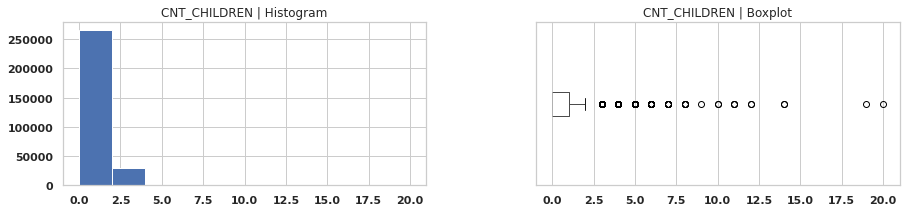

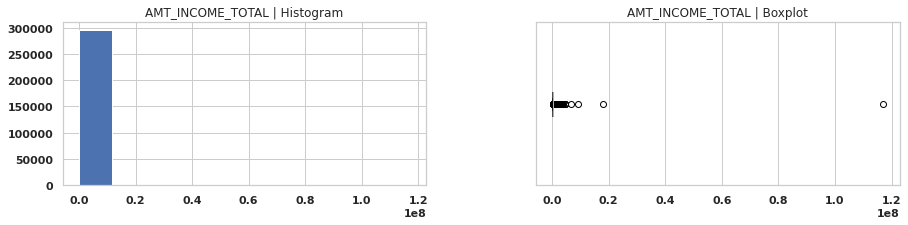

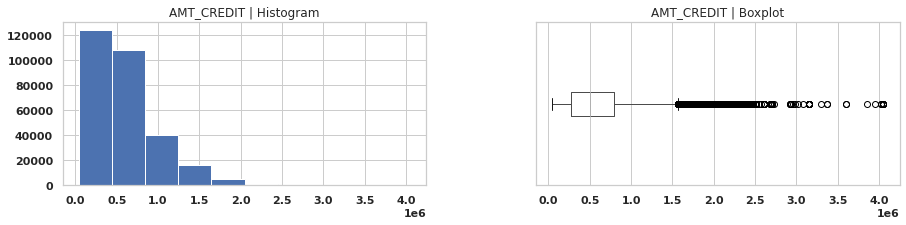

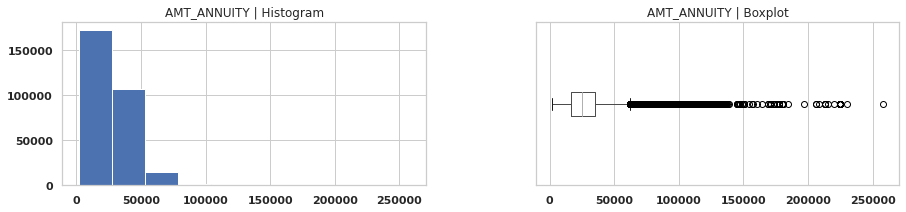

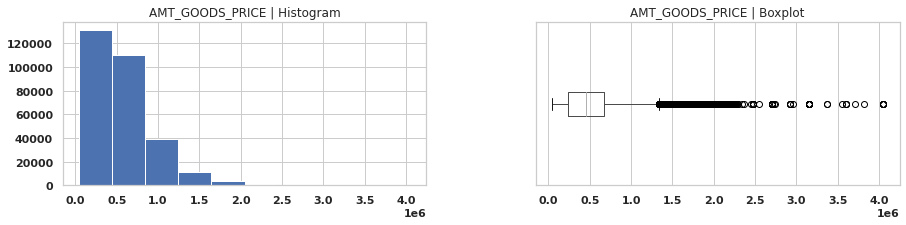

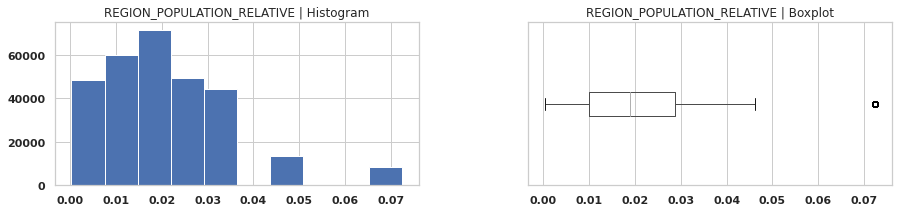

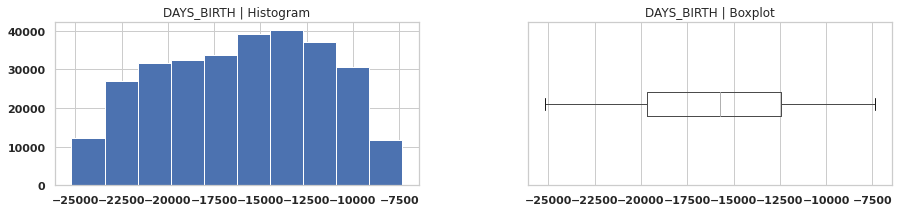

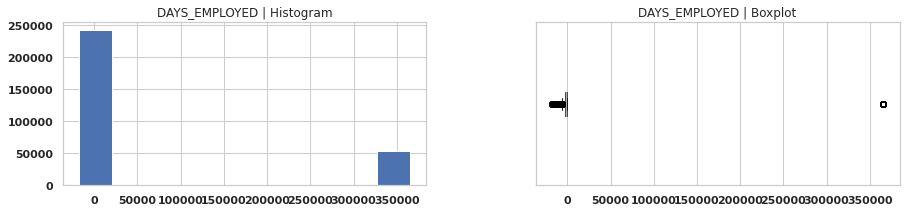

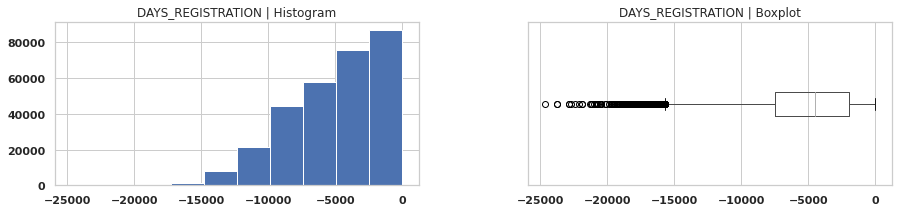

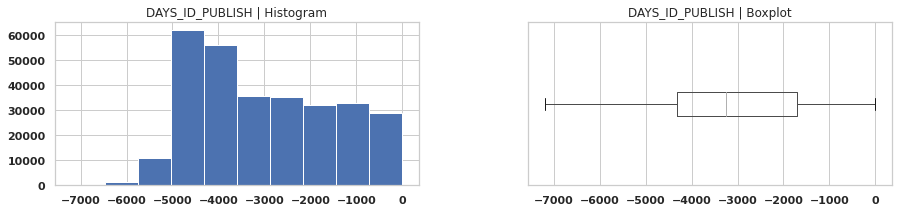

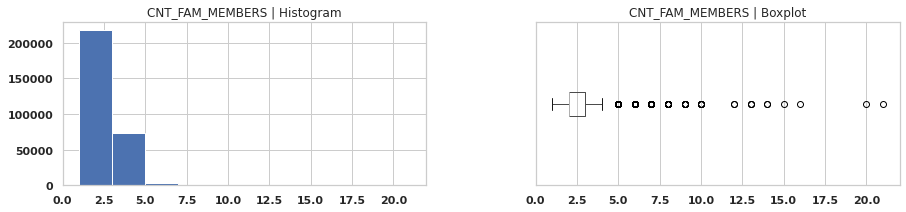

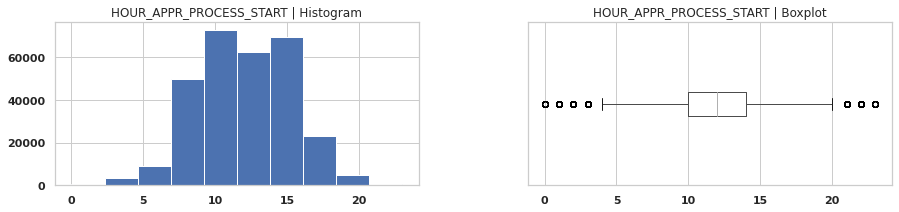

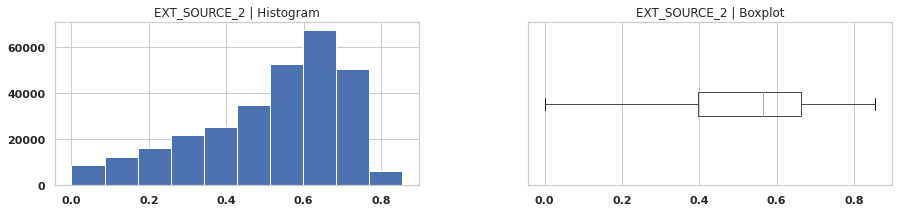

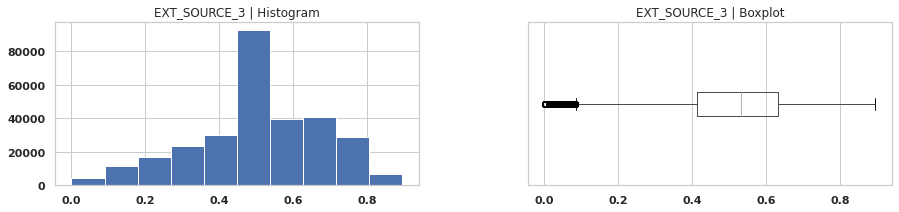

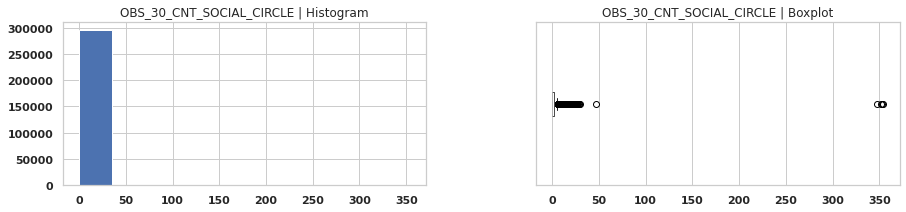

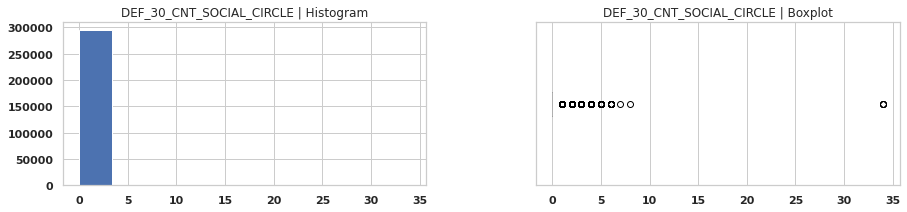

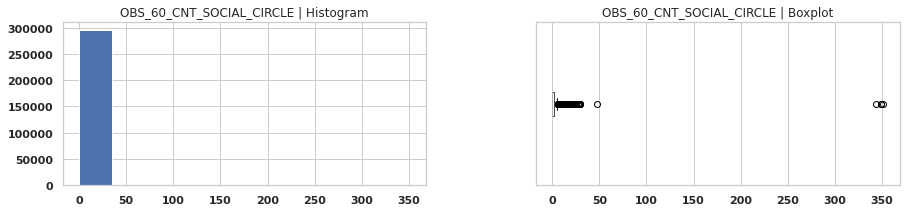

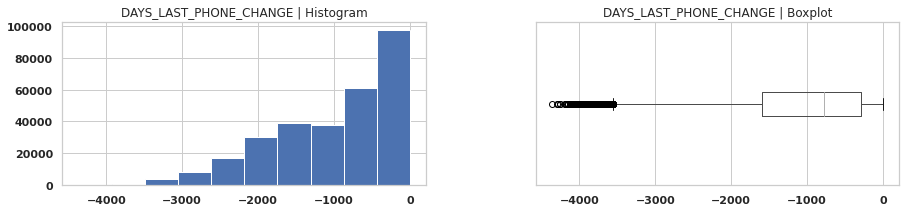

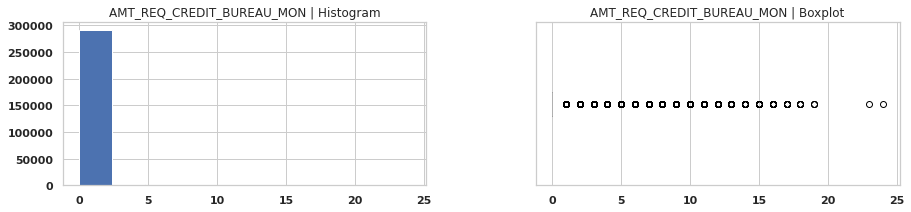

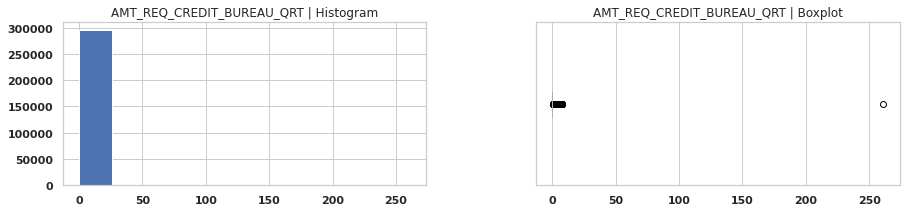

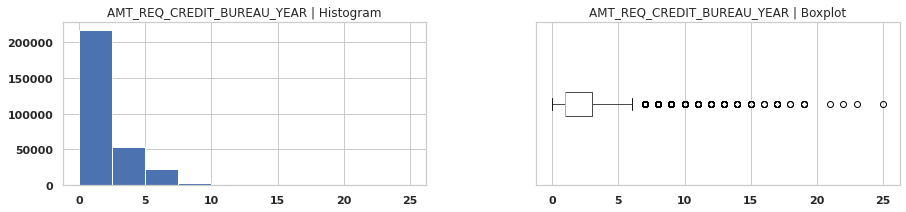

In [48]:
# Dessiner les plots pour les variables numeriques: Ces plots sont affiches 
# juste pour une vue generale et rapide. Une analyse detaillee des variables
# pertinentes suivra ... 
num_plot(df_application, num_cols=num_cols, remove=[
    'SK_ID_CURR'], figsize = (15,3))

Une analyse des informations presentes dans la description statistiques et histoigrames des variables, nous donnent une vue detaillee du comportement des variables en terme de districbution. On va regarder de plus pres quelques variables que nous jugons important pour notre cas.

Deux variables numeriques nous ont attire l'attention pour analyse un peu plus detaillee: DAYS_BIRTH et DAYS_EMPLOYED.

In [49]:
# Variable 'DAYS_BIRTH'
# A noter que cette variable est renseignee comme nombre de jours (-)
(df_application['DAYS_BIRTH']).describe()

count    295344.000000
mean     -16042.542845
std        4363.068939
min      -25201.000000
25%      -19678.000000
50%      -15756.000000
75%      -12422.000000
max       -7338.000000
Name: DAYS_BIRTH, dtype: float64

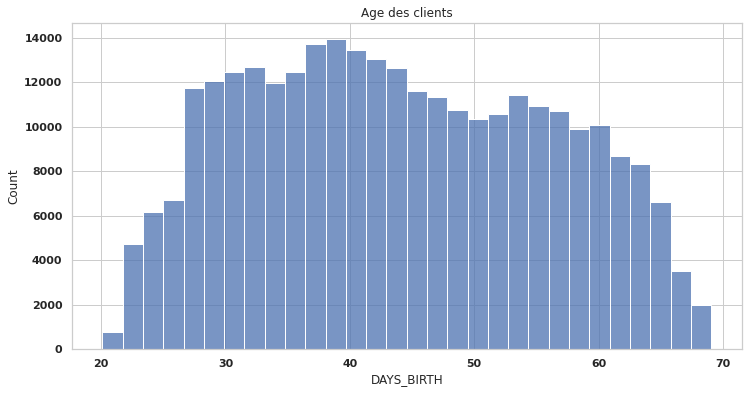

In [50]:
# Variable 'DAYS_BIRTH'
# A noter que cette variable est renseignee comme nombre de jours (-), avec 
ax = plt.figure(figsize=(12, 6))
sns.histplot((df_application['DAYS_BIRTH'] / -365), bins = 30).set_title('Age des clients')
plt.show()

In [51]:
# Variable 'DAYS_EMPLOYED'
# A noter que cette variable est renseignee comme nombre de jours (-)
(df_application['DAYS_EMPLOYED']).describe()

count    295344.000000
mean      64445.409059
std      141815.065797
min      -17546.000000
25%       -2789.000000
50%       -1226.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

On remarque ici un max de 365243 jours, ce qui est aberant, et je pesne que c'est une valeure par default prise en cas de non-information. Il faut donc eliminer cette valeur en la remplacant par la 'Mediane'..

In [52]:
# Imputation pour valeures aberantes dans 'DAYS_EMPLOYED'
df_application[df_application['DAYS_EMPLOYED'] == 365243]
days_employed_med = df_application['DAYS_EMPLOYED'].median()
df_application['DAYS_EMPLOYED'].replace({365243: days_employed_med},
                                        inplace=True)

(df_application['DAYS_EMPLOYED']).describe()

count    295344.000000
mean      -2186.671837
std        2159.590542
min      -17546.000000
25%       -2789.000000
50%       -1226.000000
75%        -952.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

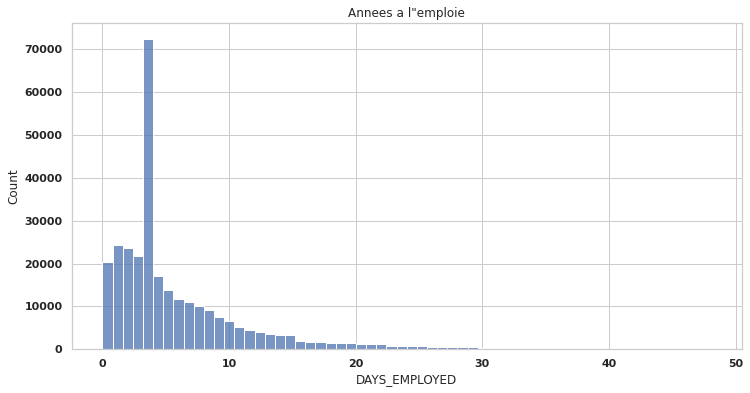

In [53]:
# Variable 'DAYS_EMPLOYED'
# A noter que cette variable est renseignee comme nombre de jours (-) 
plt.figure(figsize=(12, 6))
sns.histplot((df_application['DAYS_EMPLOYED'] / -365), bins = 60).set_title('Annees a l"emploie')
plt.show()

Pour les variables categorielles, on va explorer quelques unes qui nous semblent les plus pertinentes, comme:
- CODE_GENDER
- NAME_FAMILY_STATUS
- NAME_CONTRACT_TYPE
- FLAG_OWN_CAR
- NAME_INCOME_TYPE
- etc ...

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


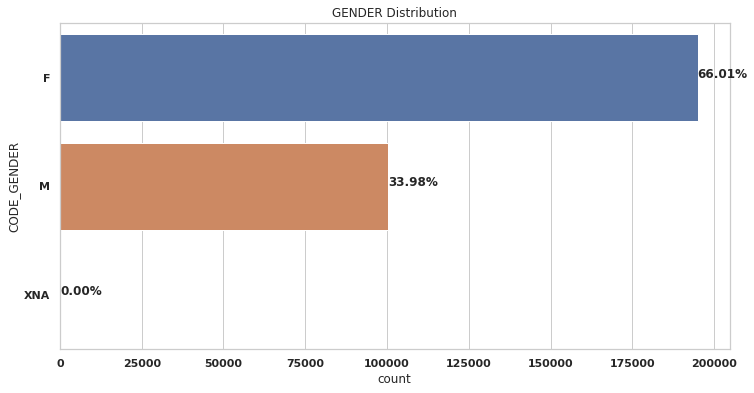

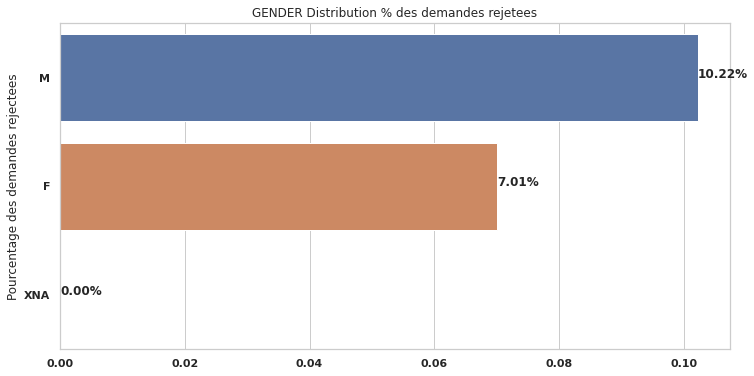

In [54]:
# Variable 'CODE_GENDER'
plot_stat(df_application, 'CODE_GENDER','GENDER Distribution')
plot_percent_target1(df_application, 'CODE_GENDER',
                     'GENDER Distribution % des demandes rejetees')

Les femmes sont plus nombreuses a demander des prets ~66% presque le double.  Aussi, les hommes sont plus sujets de non-remboursement ~10% compares aux femmes ~7%.

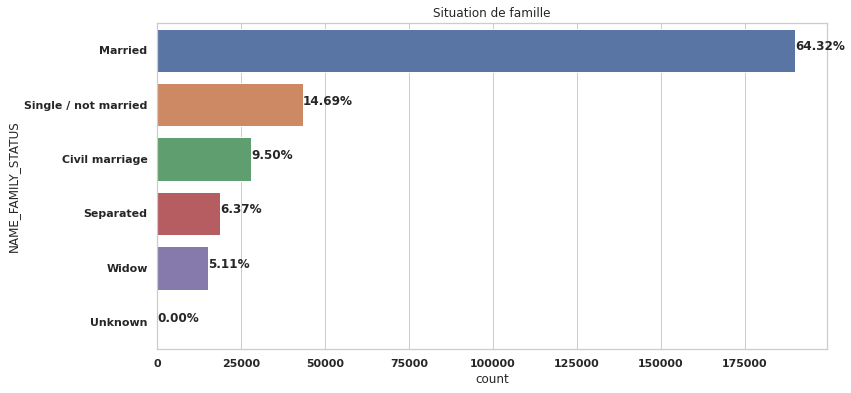

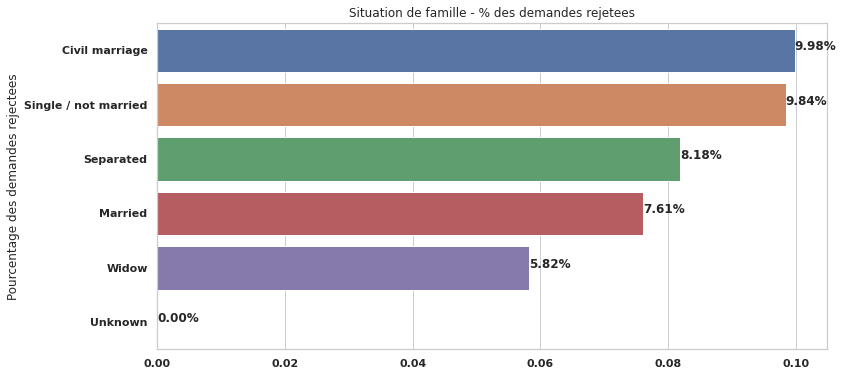

In [55]:
# Variable 'NAME_FAMILY_STATUS'
plot_stat(df_application, 'NAME_FAMILY_STATUS','Situation de famille')
plot_percent_target1(df_application, 'NAME_FAMILY_STATUS',
                     'Situation de famille - % des demandes rejetees')

In [56]:
df_application.head(3)

SK_ID_CURR  TARGET  ... AMT_REQ_CREDIT_BUREAU_QRT AMT_REQ_CREDIT_BUREAU_YEAR
0      100002     1.0  ...                       0.0                        1.0
1      100003     0.0  ...                       0.0                        0.0
2      100004     0.0  ...                       0.0                        0.0

[3 rows x 73 columns]

Les mariés sont en-tete des demandeurs de prêt, suivis des célibataires / non mariés.

Pour le non-remboursement, le mariage civil parait a risque plus élevé de non-remboursement (10%).  
On peut remqrques que les veuves sont les moins demandeurs mais aussi les plus sures...

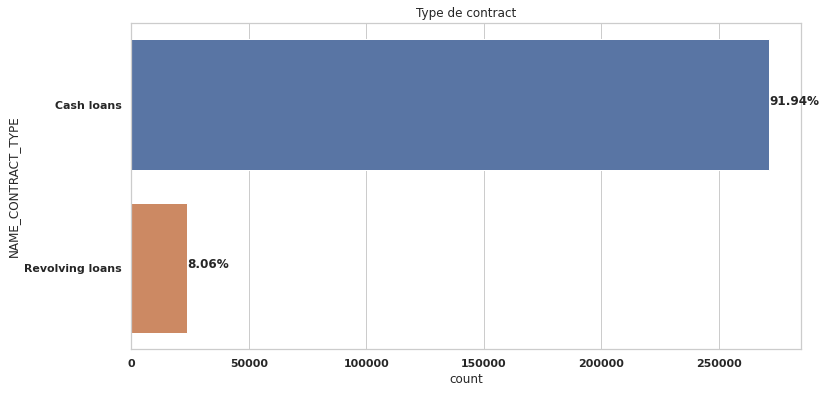

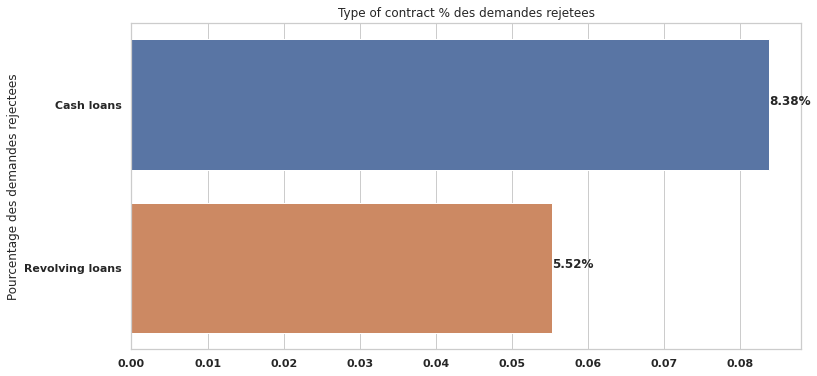

In [57]:
# Variable 'NAME_CONTRACT_TYPE'
plot_stat(df_application, 'NAME_CONTRACT_TYPE','Type de contract')
plot_percent_target1(df_application, 'NAME_CONTRACT_TYPE',
                     'Type of contract % des demandes rejetees')

Les prêts flexibles (revolving) presentent un petit % (~8%) de l'ensemble des demandes de prêts, alors qu'ils presentent un plus grand risque relativement par rapport aux demandes de cahs.

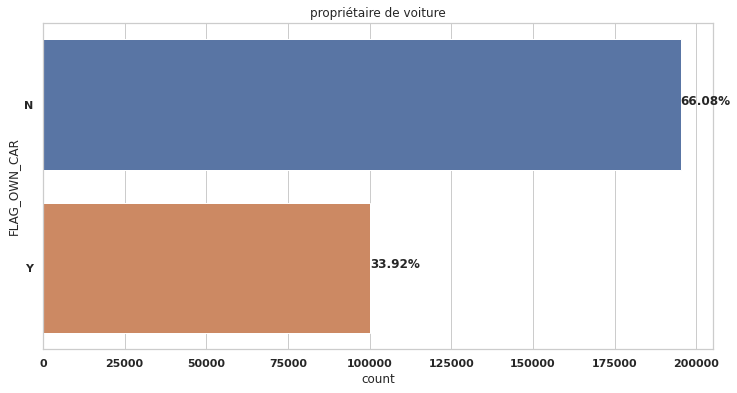

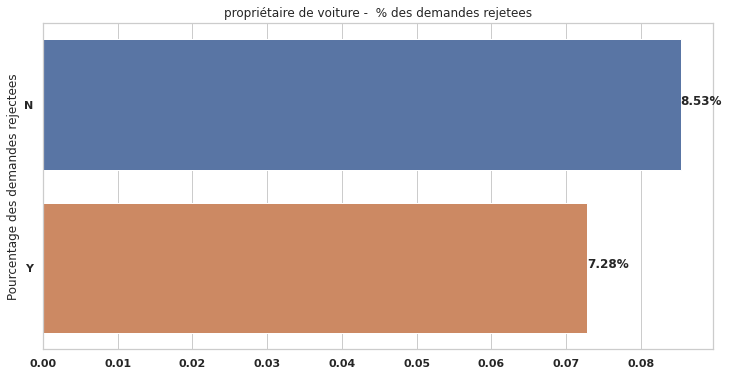

In [58]:
# Variable 'FLAG_OWN_CAR' 
plot_stat(df_application, 'FLAG_OWN_CAR','propriétaire de voiture')
plot_percent_target1(df_application, 'FLAG_OWN_CAR',
                     'propriétaire de voiture -  % des demandes rejetees')

Les non-propriétaire de voiture semblent etre meilleures demandeurs de prets. Alors, que pour le remboursement, les 2 categories sont presques a egalite (~8%)

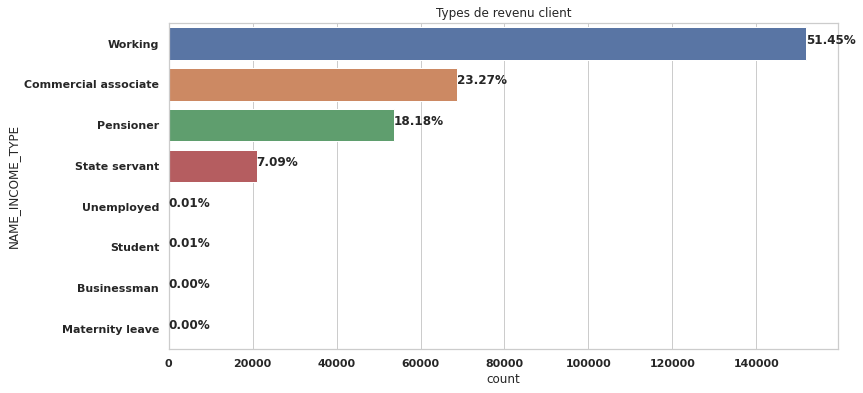

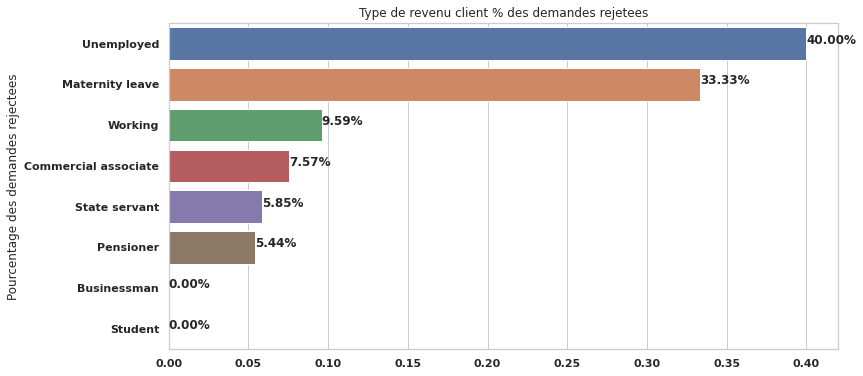

In [59]:
# Variable 'NAME_INCOME_TYPE'
plot_stat(df_application, 'NAME_INCOME_TYPE','Types de revenu client')
plot_percent_target1(df_application, 'NAME_INCOME_TYPE','Type de revenu client % des demandes rejetees')

La majorite des prets dans cette dimension est attribue aux categories 'working' et 'associé commercial', avec 52% et 24% respectivement. 

Les mauvais payeurs sont les clients categorises comme au chomage ou en congé de maternité avec 40% et 33% respectivement.

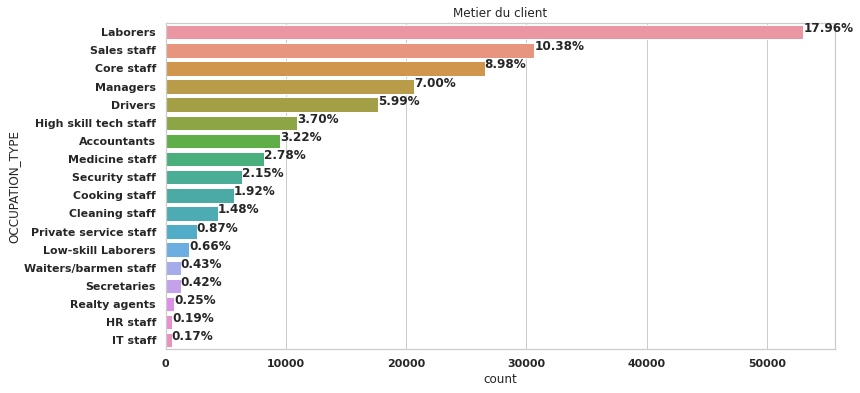

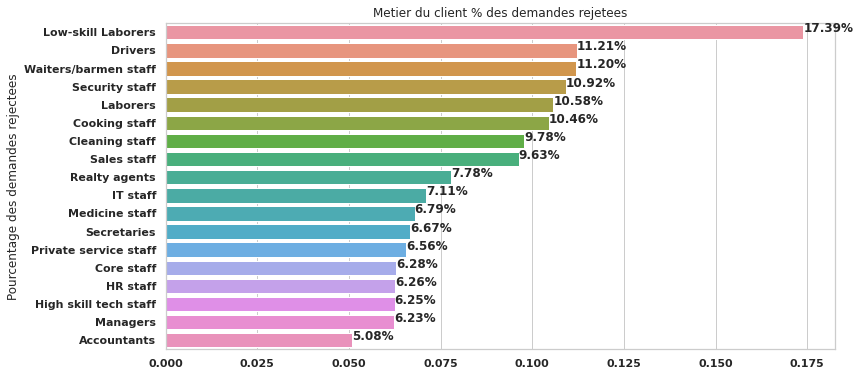

In [60]:
# Variable 'OCCUPATION_TYPE'
plot_stat(df_application, 'OCCUPATION_TYPE','Metier du client')
plot_percent_target1(df_application, 'OCCUPATION_TYPE','Metier du client % des demandes rejetees')

Les demandeurs de prêts les plus actifs dans cette variable sont les ouvriers, suivis par les vendeurs/commerciaux et le personnel de base. Les metiers les moins demandeurs de prets semblent etre le personnel informatique et ressources humaines.

Les catégories avec le risque de non-remboursement le plus élevé sont les 'ouvriers peu qualifiés' (plus de 17%) et les 'chauffeurs, suivies de pas trop de loin, les serveurs, personnel de sécurité, ....

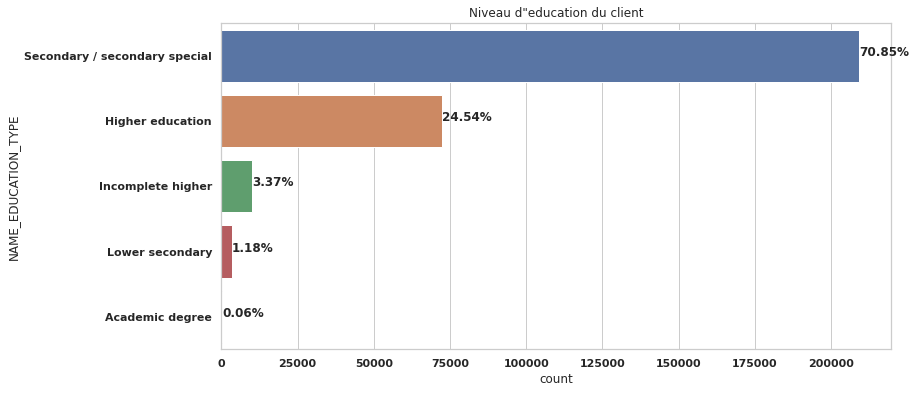

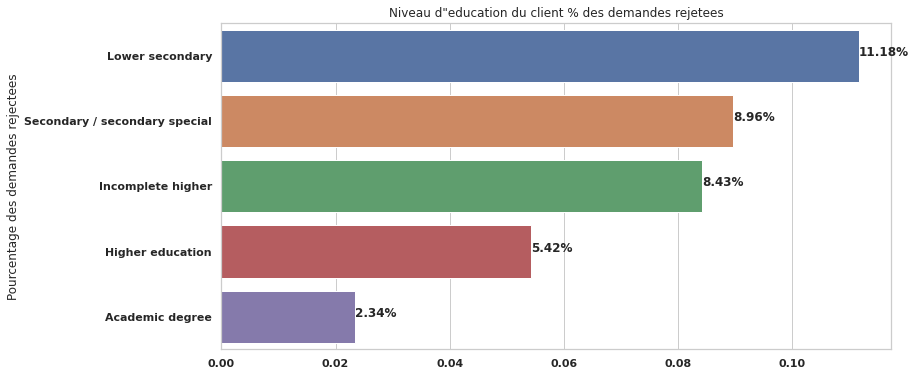

In [61]:
# Variable 'NAME_EDUCATION_TYPE'
plot_stat(df_application, 'NAME_EDUCATION_TYPE','Niveau d"education du client')
plot_percent_target1(df_application, 'NAME_EDUCATION_TYPE','Niveau d"education du client % des demandes rejetees')

Avec cette variable 'Niveau d'Education', la majorité des demandeurs de prets sont de la categorie 'éducation secondaire' avec ~ 71%, suivis de la categorie 'éducation supérieure'. Je pense que HE education represente un Bachelor degree, alors que diplome academique doit representer Matser / PhD...

La catégorie 'lower secondary' represente le plus haut niveau de non-remboursement des prets. (~11%). Les personnes les plus demandeurs de prets ont le moindre taux de non-rembouresement ......

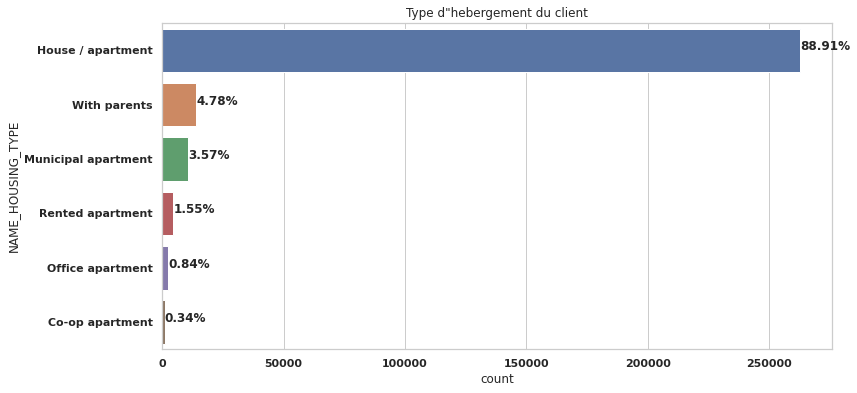

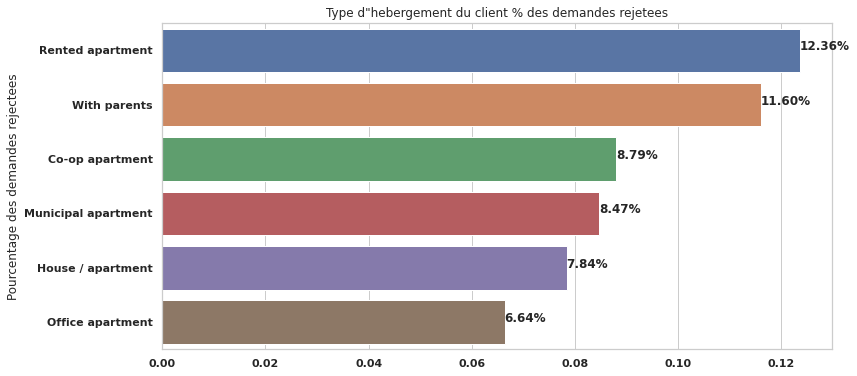

In [62]:
# Variable NAME_HOUSING_TYPE
plot_stat(df_application, 'NAME_HOUSING_TYPE','Type d"hebergement du client')
plot_percent_target1(df_application, 'NAME_HOUSING_TYPE','Type d"hebergement du client % des demandes rejetees')

Ici, les % le plsu eleve des demandeurs de prets revient aux clients habitants dans une maison / appartement. Ces clients representent une majorite tres elevee (~89%) par rapport au total des demandes. Alors, que les taux de non-remboursement les plus eleve sont attribues aux clients habtants dans des appartements meubles et chez leurs parents...

Nous allons proceder maintenant a une analyse de collinearite des variables independantes avec la TARGET.

In [63]:
# Afficher les coef de correlation des diff variables avec TARGET
print('Les 15 Correlations positives (par ordre croissant):\n', df_application.corr()['TARGET'].sort_values().tail(15))
print('Les 15 Correlations negatives (par ordre croissant)\n', df_application.corr()['TARGET'].sort_values().head(15))

Les 15 Correlations positives (par ordre croissant):
 LIVE_CITY_NOT_WORK_CITY        0.032678
DEF_60_CNT_SOCIAL_CIRCLE       0.032706
DEF_30_CNT_SOCIAL_CIRCLE       0.033003
DAYS_REGISTRATION              0.041896
REG_CITY_NOT_LIVE_CITY         0.044382
FLAG_DOCUMENT_3                0.045001
FLAG_EMP_PHONE                 0.045559
REG_CITY_NOT_WORK_CITY         0.051085
DAYS_ID_PUBLISH                0.052917
DAYS_LAST_PHONE_CHANGE         0.054844
REGION_RATING_CLIENT           0.059134
DAYS_EMPLOYED                  0.059363
REGION_RATING_CLIENT_W_CITY    0.061099
DAYS_BIRTH                     0.078047
TARGET                         1.000000
Name: TARGET, dtype: float64
Les 15 Correlations negatives (par ordre croissant)
 EXT_SOURCE_2                 -0.161440
EXT_SOURCE_3                 -0.155898
AMT_GOODS_PRICE              -0.039264
REGION_POPULATION_RELATIVE   -0.037556
AMT_CREDIT                   -0.030050
FLAG_DOCUMENT_6              -0.029379
FLAG_PHONE                   -

Notons que la variable 'DAYS_BIRTH' est la plus correllee negativement, mais comme discute plus haut, il s'agit de nombre de jours negatif. On peut donc considerer cette correlation est negative avec la meme valeure (- 0.078047).  
Pour ce qui est de correlation negative, les variables EXT_... paraissent importantes. Examinons les u  peu plus.


Voyons, pour conclure sur l'aspet d'age, le comportementd e cette variable avec les taux de remboursement / non-remboursement des prets.

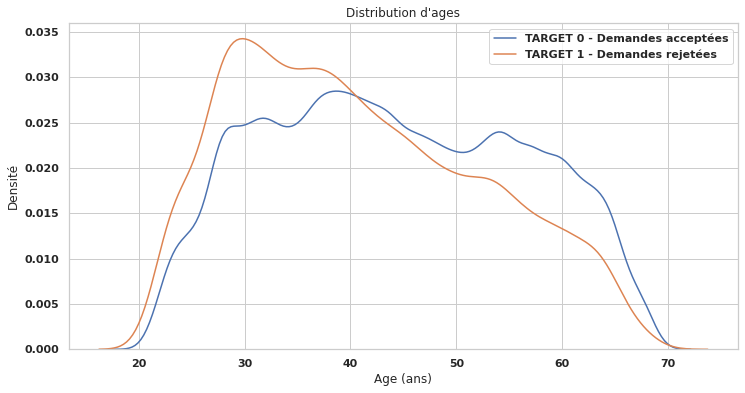

In [64]:
# Afficher la distribution d'age en fonction du TARGET
plt.figure(figsize = (12, 6))
sns.kdeplot(df_application[df_application['TARGET'] == 0]['DAYS_BIRTH'] / -365, label = 'TARGET 0 - Demandes acceptées')
sns.kdeplot(df_application[df_application['TARGET'] == 1]['DAYS_BIRTH'] / -365, label = 'TARGET 1 - Demandes rejetées')

plt.legend(), plt.xlabel('Age (ans)'), plt.ylabel('Densité'), plt.title("Distribution d'ages")
plt.show()

Le graphe affiche un résultat important (et plutot logique) de la capacité de rembourser les prets chez les jeunes ( < 40 ans) que les > 40....  

Pour les sources extérieures, qui representent les plus fortes corrélations linéaires avec le TARGET…
Comme on peut le voir dans la documentation, ces variables représentent un 'score normalisé à partir d'une source de données externe'.  
Essayons d'ecplorer un peu plus en detail ces variables.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


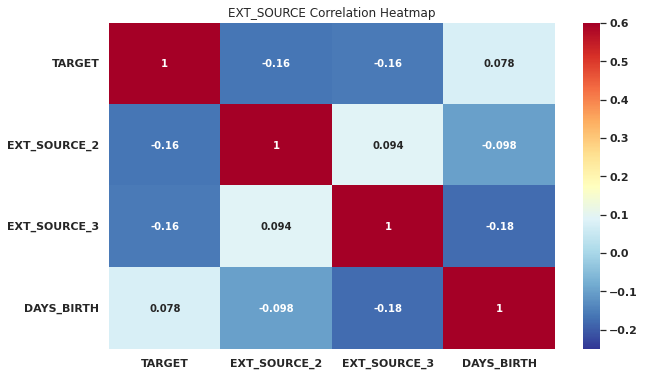

In [65]:
#Heatmap of correlations des EXT sources avec TARGET
plt.figure(figsize = (10,6))
sns.heatmap(df_application[['TARGET', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr(),
            cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6,
           )
plt.title('EXT_SOURCE Correlation Heatmap')
plt.show()

Le heatmap affiche (comme attendu) une corrélation (faible pourtant) entre les EXT sources et TARGET. Il s'agit de suivre l'évolution de cette correlation car ca peut etre une cause de non-remboursement... 

Passons maintenant a des variables categorielles plus en relation avec la nature de l'achat et le montant du crédit demandé ...

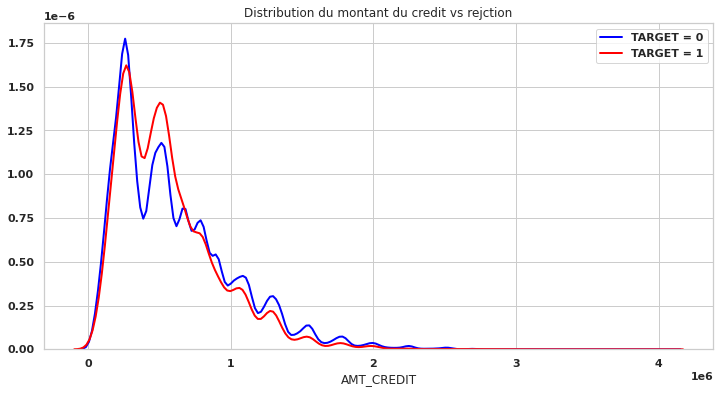

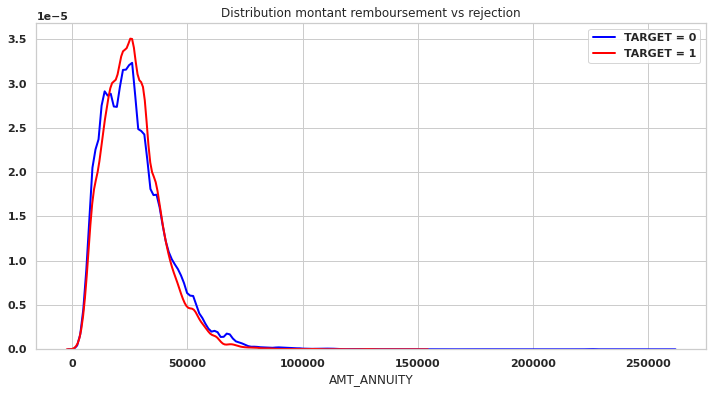

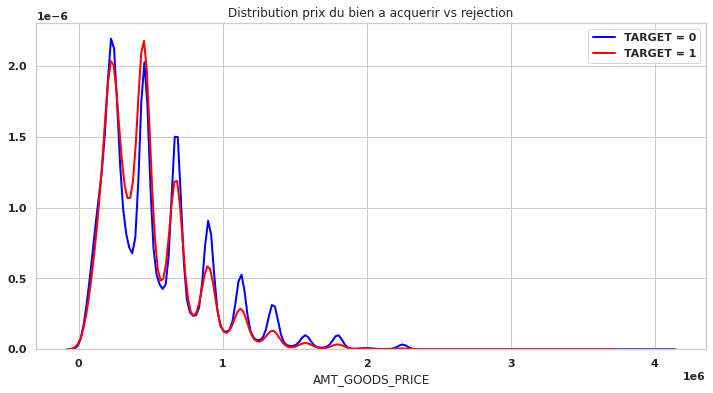

In [66]:
plot_distribution('AMT_CREDIT', 'Distribution du montant du credit vs rejction')
plot_distribution('AMT_ANNUITY', 'Distribution montant remboursement vs rejection')
plot_distribution('AMT_GOODS_PRICE', 'Distribution prix du bien a acquerir vs rejection')

Les graphes ci-haut affichent le comportement des variables ( en terme de nombre) par arpport au variable TARGET.  
Par exemple, le 'AMT_GOODS_PRICE' est plutot synchronis avec le TARGET: Si Montant augment alors le taux de non-remoboursement augmente, et vice versa...

In [67]:
# Detecter et lister les variables a correlation elevee >0.7
high_correlation(df_application, remove=['SK_ID_CURR'],
                 corr_coef = "spearman", corr_value = 0.7)

CNT_CHILDREN
-------------------------------
CNT_FAM_MEMBERS    0.811112
Name: CNT_CHILDREN, dtype: float64


AMT_CREDIT
-------------------------------
AMT_GOODS_PRICE    0.984442
AMT_ANNUITY        0.822844
Name: AMT_CREDIT, dtype: float64


AMT_ANNUITY
-------------------------------
AMT_CREDIT         0.822844
AMT_GOODS_PRICE    0.821171
Name: AMT_ANNUITY, dtype: float64


AMT_GOODS_PRICE
-------------------------------
AMT_CREDIT     0.984442
AMT_ANNUITY    0.821171
Name: AMT_GOODS_PRICE, dtype: float64


CNT_FAM_MEMBERS
-------------------------------
CNT_CHILDREN    0.811112
Name: CNT_FAM_MEMBERS, dtype: float64


REGION_RATING_CLIENT
-------------------------------
REGION_RATING_CLIENT_W_CITY    0.948576
Name: REGION_RATING_CLIENT, dtype: float64


REGION_RATING_CLIENT_W_CITY
-------------------------------
REGION_RATING_CLIENT    0.948576
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64


REG_REGION_NOT_WORK_REGION
-------------------------------
LIVE_REGION_NOT_WORK_REGION  

On peut remaquer des correlations assez elevees entre des variables comme:  
CNT_CHILDREN et CNT_FAM_MEMBERS , ou  
AMT_CREDIT, AMT_GOODS_PRICE et AMT_ANNUITY.  
Ou aussi, entre les variables en relation avec l'habitat, comme:  APARTMENTS_AVG
APARTMENTS_MEDI, LIVINGAPARTMENTS_AVG, LIVINGAPARTMENTS_MEDI, APARTMENTS_MODE,LIVINGAPARTMENTS_MODE, etc ..   
Mais, nous allons les laissons les revoir apres fusion des differents fichiers


Traitement de variables non-pertinentes, reduction de categories, feature engineering , encoding , ...

In [68]:
# Eliminer les observations contenant des valeures jugees erronnees 
df_application = df_application[~(df_application.CODE_GENDER.str.contains('XNA'))]  
df_application = df_application[df_application.NAME_FAMILY_STATUS != "Unknown"]
# Eliminer les variables non pertinantes
cols = ['NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START',
#        'FONDKAPREMONT_MODE', 'WALLSMATERIAL_MODE', 'HOUSETYPE_MODE','EMERGENCYSTATE_MODE',
        'FLAG_MOBIL', 'FLAG_EMP_PHONE','FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
        'FLAG_PHONE', 'FLAG_EMAIL']
df_application.drop(cols, axis = 1, inplace = True)

In [69]:
# Traiter les conflits concernant l'adresse du client
cols = ["REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION",
        "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY",
        "REG_CITY_NOT_WORK_CITY","LIVE_CITY_NOT_WORK_CITY"]
df_application["REGION"] = df_application[cols].sum(axis = 1)
df_application.drop(cols, axis = 1, inplace = True)

In [70]:
df_glossary[df_glossary['Row'] == 'FLAG_DOCUMENT_5']

Unnamed: 0  ... Special
99         102  ...     NaN

[1 rows x 5 columns]

In [71]:
# Eliminer toutes les variables debutant par 'FLAG_DOCUMENT' 
df_application.drop(df_application.columns[
    df_application.columns.str.contains("FLAG_DOCUMENT")],
        axis = 1, inplace = True)

In [72]:
# Combinaisons de categories
df_application["NAME_EDUCATION_TYPE"] = np.where(
    df_application.NAME_EDUCATION_TYPE == "Academic degree",
        "Higher education", df_application.NAME_EDUCATION_TYPE)

df_application["ORGANIZATION_TYPE"] = np.where(
    df_application.ORGANIZATION_TYPE.str.contains("Business Entity"),
        "Business Entity", df_application.ORGANIZATION_TYPE)
df_application["ORGANIZATION_TYPE"] = np.where(
    df_application.ORGANIZATION_TYPE.str.contains("Industry"),
        "Industry", df_application.ORGANIZATION_TYPE)
df_application["ORGANIZATION_TYPE"] = np.where(
    df_application.ORGANIZATION_TYPE.str.contains("Trade"),
        "Trade", df_application.ORGANIZATION_TYPE)
df_application["ORGANIZATION_TYPE"] = np.where(
    df_application.ORGANIZATION_TYPE.str.contains("Transport"),
        "Transport", df_application.ORGANIZATION_TYPE)
df_application["ORGANIZATION_TYPE"] = np.where(
    df_application.ORGANIZATION_TYPE.isin(["School", "Kindergarten", "University"]),
        "Education", df_application.ORGANIZATION_TYPE)
df_application["ORGANIZATION_TYPE"] = np.where(
    df_application.ORGANIZATION_TYPE.isin(["Emergency","Police", "Medicine",
        "Goverment", "Postal", "Military", "Security Ministries",
        "Legal Services"]), "Public", df_application.ORGANIZATION_TYPE)
df_application["ORGANIZATION_TYPE"] = np.where(
    df_application.ORGANIZATION_TYPE.isin(["Bank", "Insurance"]), "Finance",
        df_application.ORGANIZATION_TYPE)
df_application["ORGANIZATION_TYPE"] = np.where(
    df_application.ORGANIZATION_TYPE.isin(["Realtor", "Housing"]), "House",
        df_application.ORGANIZATION_TYPE)
df_application["ORGANIZATION_TYPE"] = np.where(
    df_application.ORGANIZATION_TYPE.isin(["Hotel", "Restaurant"]),
        "HotelRestaurant", df_application.ORGANIZATION_TYPE)
df_application["ORGANIZATION_TYPE"] = np.where(
    df_application.ORGANIZATION_TYPE.isin(["Cleaning","Electricity", "Telecom",
        "Mobile", "Advertising", "Religion", "Culture"]), "Other",
            df_application.ORGANIZATION_TYPE)

In [73]:
# Combinaisons de categories
df_application["OCCUPATION_TYPE"] = np.where(
    df_application.OCCUPATION_TYPE.isin(["Low-skill Laborers", "Cooking staff",
        "Security staff", "Private service staff", "Cleaning staff",
            "Waiters/barmen staff"]), "Low-skill Laborers",
                df_application.OCCUPATION_TYPE)

df_application["OCCUPATION_TYPE"] = np.where(
    df_application.OCCUPATION_TYPE.isin(["IT staff", "High skill tech staff"]),
        "High skill tech staff", df_application.OCCUPATION_TYPE)

In [74]:
# Combinaisons de categories avec la fonction 'rare_encoder'
rare_cols = ["NAME_TYPE_SUITE", "NAME_INCOME_TYPE"]

for cols in rare_cols:
    rare_encoder(df_application, cols, rare_perc = 0.01)

In [75]:
# Traiter les variables categorielles binaires (0 ou 1)
for bin_feature in ["NAME_CONTRACT_TYPE", 'CODE_GENDER', 'FLAG_OWN_CAR',
                    'FLAG_OWN_REALTY']:
    df_application[bin_feature], uniques = pd.factorize(df_application[bin_feature])

In [76]:
# Encoder variables categorielles avec 'one_hot_encoder'   
df_application, get_dummies_lit_application = get_dummies_encoder(df_application,
                                               nan_as_category=False)

In [77]:
# Remplacer 'Days '365243' par 'nan'. 365243 indqiue inconnue
df_application['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [78]:
# Creer nouveaux features (pourcentages)
df_application['DAYS_EMPLOYED_PERC'] = df_application['DAYS_EMPLOYED'] / df_application['DAYS_BIRTH']
df_application['INCOME_CREDIT_PERC'] = df_application['AMT_INCOME_TOTAL'] / df_application['AMT_CREDIT']
df_application['INCOME_PER_PERSON'] = df_application['AMT_INCOME_TOTAL'] / df_application['CNT_FAM_MEMBERS']
df_application['ANNUITY_INCOME_PERC'] = df_application['AMT_ANNUITY'] / df_application['AMT_INCOME_TOTAL']
df_application['PAYMENT_RATE'] = df_application['AMT_ANNUITY'] / df_application['AMT_CREDIT']

In [79]:
# Creer nouveaux features en relations avec score moyen des sources externes 
df_application["NEW_EXT_MEAN"] = df_application[['EXT_SOURCE_2',
    'EXT_SOURCE_3']].mean(axis=1)
df_application['NEW_APP_EXT_SOURCES_PROD'] = df_application[
    'EXT_SOURCE_2'] * df_application['EXT_SOURCE_3']

# Creer nouveau feature pourcentage prix du bien / montant credit
df_application["NEW_GOODS_CREDIT"] = df_application[
    "AMT_GOODS_PRICE"] / df_application["AMT_CREDIT"]

# Creer nouveau feature ratio: différence entre le produit et le prêt sur le
# revenu annuel total
df_application["NEW_C_GP"] = (df_application[
    "AMT_GOODS_PRICE"] - df_application["AMT_CREDIT"]) / df_application[
        "AMT_INCOME_TOTAL"]

# Creer nouveau feature age du client en annees:
# age indique en jours (negatif)*(-1) / 365 
df_application["NEW_APP_AGE"] = round(df_application["DAYS_BIRTH"] * -1 / 365)

df_application['NEW_LOAN_VALUE_RATIO'] = df_application[
    'AMT_CREDIT'] / df_application['AMT_GOODS_PRICE']

df_application['INCOME_PER_PERSON_PERC_PAYMENT_RATE'] = df_application[
    'INCOME_PER_PERSON'] / df_application['PAYMENT_RATE']

In [80]:
print('Shape du fichier \'application_train/test\' :',
    df_application.shape, '\n')
df_application.head()

Shape du fichier 'application_train/test' : (295338, 94) 



SK_ID_CURR  ...  INCOME_PER_PERSON_PERC_PAYMENT_RATE
0      100002  ...                         3.333374e+06
1      100003  ...                         4.891602e+06
2      100004  ...                         1.350000e+06
3      100006  ...                         7.109652e+05
4      100007  ...                         2.850587e+06

[5 rows x 94 columns]

In [81]:
# #####################################################
df_application.reset_index(inplace = True)
# #####################################################

In [82]:
# 'Feather' format binaire: Plus rapide pour transferer entre systemes
# Ecrire le fichier au format 'Feather' sur disque
df_application.to_feather('drive/MyDrive/P7-Project/applicationfeather')

print('Shape du fichier \'df_application\' apres EAD: ',
    df_application.shape, "\n")

Shape du fichier 'df_application' apres EAD:  (295338, 95) 



In [83]:
# Nettoyer la RAM
del df_application, df_application_test, df_application_train

Note:  Fichiers traites:

***df_application***: Fichiers application_train & application_test  


### EDA & Feature Engineering de la table: bureau_balance
**Description**:  
Balances mensuels des prets anciens enregistres dans Credit-Bureau.  
Cette table contient un historique mensuel sur status des prets precedants enregistres par le Credit-Bureau.  
Elle contient 1 ligne par mois pour chaque ancien credit enregistre par Credit-Bureau. 
'MONTHS_BALANCE': Indique le nombre relatif des mois versemnents precedents
(-1) indique le mois le plus proche de la date d'application.
Dans 'STATUS', DPD indique 'Days Past Due' nombre de jours en retard de paiement.  
**English**:  
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
STATUS: "Status of Credit Bureau loan during the month (active, closed, DPD0-30,…
C means closed,
X means status unknown,
0 means no DPD,
1 means maximal did during month between 1-30,
2 means DPD 31-60,
… 5 means DPD 120+ or sold or written off)"


In [84]:
# Lire le fichier 'bureau_balance'
df_bureau_balance = pd.read_csv('drive/MyDrive/P7-Project/bureau_balance.csv')

# Collecter des informations générales sur les données 'bureau'
liste_df = {'df_bureau_balance': df_bureau_balance}
info_sur_df(liste_df, 'Informations sur dataframes')

+-------------------------------------------------------------------------------------------+
|                                Informations sur dataframes                                |
+-------------------+---------+----------+-----------------------+--------------------------+
|        Nom        |  Lignes | Colonnes |         Nan %         |          dtypes          |
+-------------------+---------+----------+-----------------------+--------------------------+
| df_bureau_balance | 9682641 |    3     | SK_ID_BUREAU      0.0 | SK_ID_BUREAU       int64 |
|                   |         |          | MONTHS_BALANCE    0.0 | MONTHS_BALANCE     int64 |
|                   |         |          | STATUS            0.0 | STATUS            object |
|                   |         |          |     dtype: float64    |      dtype: object       |
+-------------------+---------+----------+-----------------------+--------------------------+


In [85]:
# Initialiser le df_bureau_balance_sample; 
df_bureau_balance_sample = df_bureau_balance.copy()
df_bureau_balance_sample.head(5)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [86]:
# Traitement des valeures NaN, non-conformes, imputation, outliers ....netoyage
# sera fait apres fusion avec le fichier bureau ...

In [87]:
# Afficher des informations detaillees sur les variables
cat_cols, cat_but_num, num_cols, num_but_cat = grab_col_names(
    df_bureau_balance_sample, car_th=10)

# Afficher la liste des variables categorielles ou presque!
print(cat_cols, cat_but_num)
# Afficher la liste des variables numeriques ou presque!
print(num_cols, num_but_cat)

Nombre d'Observations: 9682641
Nombre de Variables: 3
Nombre de variables de type: 
	date : 0
	categorie: 1
	numerique: 2
	categorie mais peut etre numerique: 0
	numerique mais peut etre categorie: 0
['STATUS'] []
['SK_ID_BUREAU', 'MONTHS_BALANCE'] []


In [88]:
# Verifier les categories des variables categorielles
for variable in cat_cols + cat_but_num:
    category_analyzer(df_bureau_balance_sample, variable)

STATUS
141    Status of Credit Bureau loan during the
month (active, closed, DPD0-30,ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï
¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½
ï¿½ï¿½ï¿½ï¿½ [C means closed, X means status
unknown, 0 ... Name: Description, dtype: object
     COUNT     RATIO
C  4820710  0.497871
0  2638086  0.272455
X  2106876  0.217593
1    84172  0.008693
5    19844  0.002049
2     8066  0.000833
3     2984  0.000308
4     1903  0.000197




In [89]:
# Analyser les variables numeriques
df_bureau_balance_sample.drop(['SK_ID_BUREAU'], axis = 1).describe(
    [.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

MONTHS_BALANCE
mean      -30.304627
std        23.686332
min       -96.000000
1%        -91.000000
10%       -67.000000
25%       -45.000000
50%       -25.000000
75%       -11.000000
80%        -8.000000
90%        -4.000000
95%        -2.000000
99%         0.000000
max         0.000000

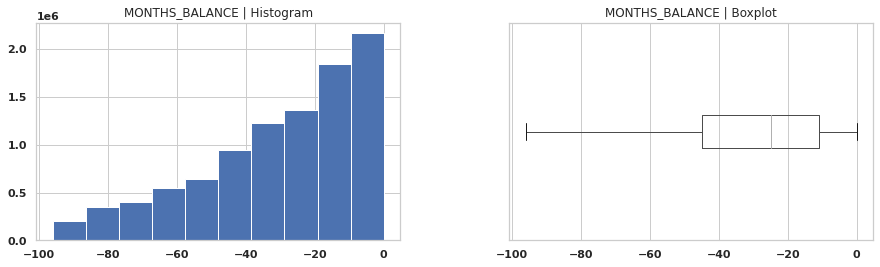

In [90]:
# Dessiner les plots pour les 4 variables suivantes par EXEMPLE
num_variables = ['MONTHS_BALANCE']
num_plot(df_bureau_balance_sample, num_cols=num_variables, remove=[
    'SK_ID_BUREAU'], figsize = (15,4))

In [91]:
# Frequences des differents STATUS
df_bureau_balance_sample.STATUS.value_counts()

C    4820710
0    2638086
X    2106876
1      84172
5      19844
2       8066
3       2984
4       1903
Name: STATUS, dtype: int64

In [92]:
# Codage des colonnes 'categorielles'
df_bureau_balance_sample_ohe, get_dummies_burea_balance = get_dummies_encoder(df_bureau_balance_sample, nan_as_category=False)
df_bureau_balance_sample_ohe.head()

SK_ID_BUREAU  MONTHS_BALANCE  STATUS_0  ...  STATUS_5  STATUS_C  STATUS_X
0       5715448               0         0  ...         0         1         0
1       5715448              -1         0  ...         0         1         0
2       5715448              -2         0  ...         0         1         0
3       5715448              -3         0  ...         0         1         0
4       5715448              -4         0  ...         0         1         0

[5 rows x 10 columns]

In [93]:
# Proceder a l'agrégation pour n'avoir qu'une observation par id 'SK_ID_BUREAU'
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

for col in get_dummies_burea_balance:
    bb_aggregations[col] = ['mean']
print(bb_aggregations)
# 
df_bureau_balance_sample_agg = df_bureau_balance_sample_ohe.groupby(
    'SK_ID_BUREAU').agg(bb_aggregations)
print(df_bureau_balance_sample_agg.shape)

{'MONTHS_BALANCE': ['min', 'max', 'size'], 'STATUS_0': ['mean'], 'STATUS_1': ['mean'], 'STATUS_2': ['mean'], 'STATUS_3': ['mean'], 'STATUS_4': ['mean'], 'STATUS_5': ['mean'], 'STATUS_C': ['mean'], 'STATUS_X': ['mean']}
(285010, 11)


In [94]:
df_bureau_balance_sample_agg

MONTHS_BALANCE           ... STATUS_5  STATUS_C  STATUS_X
                        min max size  ...     mean      mean      mean
SK_ID_BUREAU                          ...                             
5001710                 -82   0   83  ...      0.0  0.578313  0.361446
5001711                  -3   0    4  ...      0.0  0.000000  0.250000
5001712                 -18   0   19  ...      0.0  0.473684  0.000000
5001713                 -21   0   22  ...      0.0  0.000000  1.000000
5001714                 -14   0   15  ...      0.0  0.000000  1.000000
...                     ...  ..  ...  ...      ...       ...       ...
6837600                  -5   0    6  ...      0.0  0.000000  0.166667
6837601                 -47   0   48  ...      0.0  0.937500  0.000000
6837602                 -57 -17   41  ...      0.0  0.000000  1.000000
6837603                 -52 -35   18  ...      0.0  0.500000  0.000000
6837604                 -96 -35   62  ...      0.0  0.645161  0.032258

[285010 rows x 11 columns]

In [95]:
# Renommer les colonnes pour plus de calrté
df_bureau_balance_sample_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
    for e in df_bureau_balance_sample_agg.columns.tolist()])
df_bureau_balance_sample_agg.columns

Index(['MONTHS_BALANCE_MIN', 'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_SIZE',
       'STATUS_0_MEAN', 'STATUS_1_MEAN', 'STATUS_2_MEAN', 'STATUS_3_MEAN',
       'STATUS_4_MEAN', 'STATUS_5_MEAN', 'STATUS_C_MEAN', 'STATUS_X_MEAN'],
      dtype='object')

In [96]:
# Creer des variables avec la somme des moyennes des status pour chaque id
df_bureau_balance_sample_agg[
    "STATUS_C0_MEAN_SUM"] = df_bureau_balance_sample_agg[["STATUS_C_MEAN",
                                       "STATUS_0_MEAN"]].sum(axis = 1)
df_bureau_balance_sample_agg[
    "STATUS_12_MEAN_SUM"] = df_bureau_balance_sample_agg[["STATUS_1_MEAN",
                                       "STATUS_2_MEAN"]].sum(axis = 1)
df_bureau_balance_sample_agg[
    "STATUS_345_MEAN_SUM"] = df_bureau_balance_sample_agg[["STATUS_3_MEAN",
                                        "STATUS_4_MEAN",
                                        "STATUS_5_MEAN"]].sum(axis = 1)
df_bureau_balance_sample_agg[
    "STATUS_12345_MEAN_SUM"] = df_bureau_balance_sample_agg[["STATUS_1_MEAN",
                                          "STATUS_2_MEAN",
                                          "STATUS_3_MEAN",
                                          "STATUS_4_MEAN",
                                          "STATUS_5_MEAN"]].sum(axis = 1)

In [97]:
# Creer une variable pour identifier le mois de cloture du pret pour chaque id
closed = df_bureau_balance_sample[df_bureau_balance_sample.STATUS == "C"]
closed = closed.groupby(
    "SK_ID_BUREAU").MONTHS_BALANCE.min().reset_index().rename(
        {"MONTHS_BALANCE":"MONTHS_BALANCE_FIRST_C"}, axis = 1)
closed["MONTHS_BALANCE_FIRST_C"] = np.abs(closed["MONTHS_BALANCE_FIRST_C"])
df_bureau_balance_sample_agg = pd.merge(
    df_bureau_balance_sample_agg, closed, how = "left", on = "SK_ID_BUREAU")
df_bureau_balance_sample_agg["MONTHS_BALANCE_CLOSED_DIF"] = np.abs(
    df_bureau_balance_sample_agg.MONTHS_BALANCE_MIN) - df_bureau_balance_sample_agg.MONTHS_BALANCE_FIRST_C

In [98]:
df_bureau_balance_sample_agg

SK_ID_BUREAU  ...  MONTHS_BALANCE_CLOSED_DIF
0            5001710  ...                       35.0
1            5001711  ...                        NaN
2            5001712  ...                       10.0
3            5001713  ...                        NaN
4            5001714  ...                        NaN
...              ...  ...                        ...
285005       6837600  ...                        NaN
285006       6837601  ...                        3.0
285007       6837602  ...                        NaN
285008       6837603  ...                        9.0
285009       6837604  ...                       22.0

[285010 rows x 18 columns]

Note:  Fichiers traites:
***df_bureau_balance_sample: Fichier bureau_balances*** 


### EDA & Feature Engineering de la table: bureau
**Description**:  
Contient un historique sur les prets anciens donnés par d'autres organismes financiers transmis au Bureau de Crédit (Credit Bureau).  
Pour chaque pret (loan) dans notre fichier de base 'applications', on peut trouver 0-n prets octroyés au client correspondant avant la date de l'application pour le pret.  
**English**:  
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [99]:
# Lire le fichier 'bureau'
df_bureau = pd.read_csv("drive/MyDrive/P7-Project/bureau.csv")

# Collecter des informations générales sur les données 'bureau'
liste_df = {'df_bureau': df_bureau}
info_sur_df(liste_df, 'Informations sur dataframes')

+------------------------------------------------------------------------------------------------------+
|                                     Informations sur dataframes                                      |
+-----------+---------+----------+---------------------------------+-----------------------------------+
|    Nom    |  Lignes | Colonnes |              Nan %              |               dtypes              |
+-----------+---------+----------+---------------------------------+-----------------------------------+
| df_bureau | 1344048 |    17    | SK_ID_CURR                 0.00 | SK_ID_CURR                  int64 |
|           |         |          | SK_ID_BUREAU               0.00 | SK_ID_BUREAU                int64 |
|           |         |          | CREDIT_ACTIVE              0.00 | CREDIT_ACTIVE              object |
|           |         |          | CREDIT_CURRENCY            0.00 | CREDIT_CURRENCY            object |
|           |         |          | DAYS_CREDIT         

Note:  Fichiers traites:
***df_app_sample: Fichier applications***  
***df_bureau_balance_sample: Fichier bureau_balances***  
***df_bureau_sample: Fichier bureau*** 

In [100]:
# Proceder a la fusion avec la table 'bureau' avec 'bureau_balance'
df_bbb_merge = pd.merge(df_bureau, df_bureau_balance_sample_agg,
                        how='left', on='SK_ID_BUREAU')
# ##############################################################
print('Taille de df_bbb_merge: {}'.format(df_bbb_merge.shape))
print('Nombre de clients referés dans "bureau": {}'.format(
    len(df_bbb_merge['SK_ID_CURR'].unique())))
print('Nombre de records dans "bureau_balance": {}'.format(
    len(df_bbb_merge['SK_ID_BUREAU'].unique())))

Taille de df_bbb_merge: (1344048, 34)
Nombre de clients referés dans "bureau": 262916
Nombre de records dans "bureau_balance": 1344048


Number of Variables include Missing Values: 30 



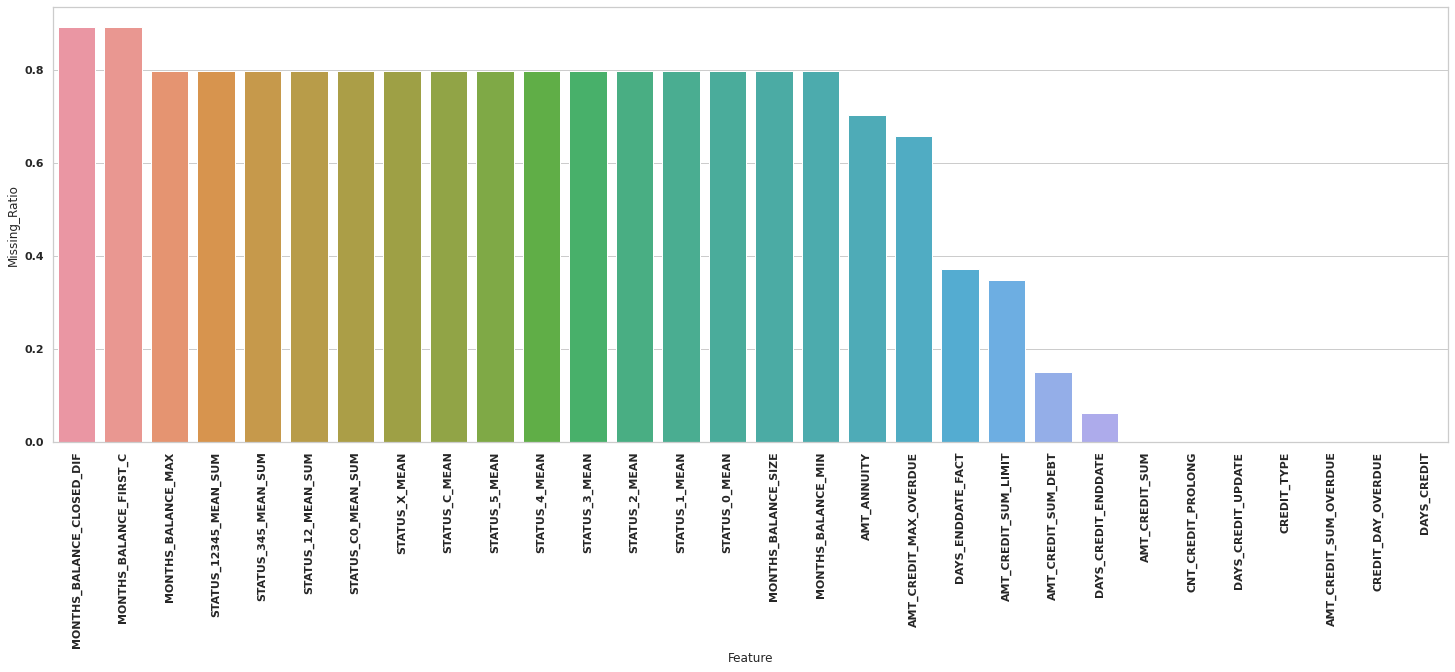

                      Feature  Num_Missing  Missing_Ratio DataTypes
0   MONTHS_BALANCE_CLOSED_DIF      1198372   8.916140e-01   float64
1      MONTHS_BALANCE_FIRST_C      1198372   8.916140e-01   float64
2          MONTHS_BALANCE_MAX      1073590   7.987736e-01   float64
3       STATUS_12345_MEAN_SUM      1073590   7.987736e-01   float64
4         STATUS_345_MEAN_SUM      1073590   7.987736e-01   float64
5          STATUS_12_MEAN_SUM      1073590   7.987736e-01   float64
6          STATUS_C0_MEAN_SUM      1073590   7.987736e-01   float64
7               STATUS_X_MEAN      1073590   7.987736e-01   float64
8               STATUS_C_MEAN      1073590   7.987736e-01   float64
9               STATUS_5_MEAN      1073590   7.987736e-01   float64
10              STATUS_4_MEAN      1073590   7.987736e-01   float64
11              STATUS_3_MEAN      1073590   7.987736e-01   float64
12              STATUS_2_MEAN      1073590   7.987736e-01   float64
13              STATUS_1_MEAN      1073590   7.9

In [101]:
# Detecter et eliminer les missing values = 100% dans df_bbb_merge
missing_values(df_bbb_merge, plot = True)

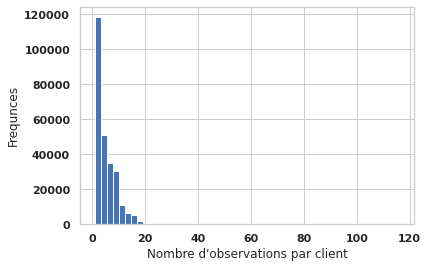

max       116.000000
std         4.236510
median      4.000000
min         1.000000
mean        5.112081
Name: SK_ID_BUREAU, dtype: float64

In [102]:
# Calculer le nombre d'observations par client referés dans Credit-Bureau
df_bbb_merge.groupby("SK_ID_CURR").SK_ID_BUREAU.count().hist(bins=50)
plt.xlabel('Nombre d\'observations par client')
plt.ylabel('Frequnces')
plt.show()
df_bbb_merge.groupby("SK_ID_CURR").SK_ID_BUREAU.count().agg({"min", "max", "mean", "median", "std"})

In [103]:
# Afficher des informations detaillees sur les variables
cat_cols, cat_but_num, num_cols, num_but_cat = grab_col_names(
    df_bbb_merge, car_th=10)

# Afficher la liste des variables categorielles ou presque!
print(cat_cols, cat_but_num)
# Afficher la liste des variables numeriques ou presque!
print(num_cols, num_but_cat)

Nombre d'Observations: 1344048
Nombre de Variables: 34
Nombre de variables de type: 
	date : 0
	categorie: 3
	numerique: 30
	categorie mais peut etre numerique: 1
	numerique mais peut etre categorie: 1
['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CNT_CREDIT_PROLONG'] ['CREDIT_TYPE']
['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'MONTHS_BALANCE_MIN', 'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_SIZE', 'STATUS_0_MEAN', 'STATUS_1_MEAN', 'STATUS_2_MEAN', 'STATUS_3_MEAN', 'STATUS_4_MEAN', 'STATUS_5_MEAN', 'STATUS_C_MEAN', 'STATUS_X_MEAN', 'STATUS_C0_MEAN_SUM', 'STATUS_12_MEAN_SUM', 'STATUS_345_MEAN_SUM', 'STATUS_12345_MEAN_SUM', 'MONTHS_BALANCE_FIRST_C', 'MONTHS_BALANCE_CLOSED_DIF'] ['CNT_CREDIT_PROLONG']


In [104]:
# Verifier les categories des variables categorielles
for variable in cat_cols + cat_but_num:
    category_analyzer(df_bbb_merge, variable)

CREDIT_ACTIVE
124    Status of the Credit Bureau (CB) reported
credits Name: Description, dtype: object
           COUNT     RATIO
Closed    843268  0.627409
Active    495639  0.368766
Sold        5128  0.003815
Bad debt      13  0.000010


CREDIT_CURRENCY
125    Recoded currency of the Credit Bureau
credit Name: Description, dtype: object
              COUNT         RATIO
currency 1  1342939  9.991749e-01
currency 2      960  7.142602e-04
currency 3      141  1.049070e-04
currency 4        7  5.208147e-06
currency          1  7.440210e-07


CNT_CREDIT_PROLONG
131    How many times was the Credit Bureau credit
prolonged Name: Description, dtype: object
       COUNT         RATIO
0.0  1336886  9.946713e-01
1.0     5957  4.432133e-03
2.0      991  7.373249e-04
3.0      144  1.071390e-04
4.0       48  3.571301e-05
5.0       16  1.190434e-05
9.0        2  1.488042e-06
6.0        2  1.488042e-06
8.0        1  7.440210e-07


CREDIT_TYPE
136    Type of Credit Bureau credit (Car,
cash,...) Nam

L'analyse des categories des variables categorielles permet de: 
- Eliminer la variable CREDIT_CURRENCY. 99.9% presque ont la valeure currency 1.
- Re-arranger CREDIT_ACTIVE pour avoir 3 categories: Active, Closed et Sold_BadDebt (combinaison des categories rares 'Sold' et 'Bad debt'.
- Re-arranger CREDIT_TYPE pour combiner plusieures categories rares. 

In [105]:
# Analyser les variables numeriques
df_bbb_merge.drop(["SK_ID_CURR" ,"SK_ID_BUREAU"], axis = 1).describe(
    [.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

DAYS_CREDIT  ...  MONTHS_BALANCE_CLOSED_DIF
mean -1138.180170  ...                  11.891094
std    793.268479  ...                  10.953526
min  -2922.000000  ...                   0.000000
1%   -2866.000000  ...                   0.000000
10%  -2437.000000  ...                   3.000000
25%  -1659.000000  ...                   5.000000
50%   -984.000000  ...                   9.000000
75%   -472.000000  ...                  13.000000
80%   -383.000000  ...                  17.000000
90%   -214.000000  ...                  25.000000
95%   -124.000000  ...                  36.000000
99%    -38.000000  ...                  57.000000
max      0.000000  ...                  94.000000

[13 rows x 29 columns]

Les statisques descriptives avec percentilles detailles informent sur le comportement des variables umeriques.  

Par exemple, AMT_CREDIT_MAX_OVERDUE a un maximum de 115,987,200 mais son 99 percentile est de 42,530. Les outliers sont a cosnsiderer pour un meilleur resultats.

On peut aussi dessiner des graphes comme histogrammes, boxplots, ... pour mieux comprendre le comportement des variavbles numeriques.

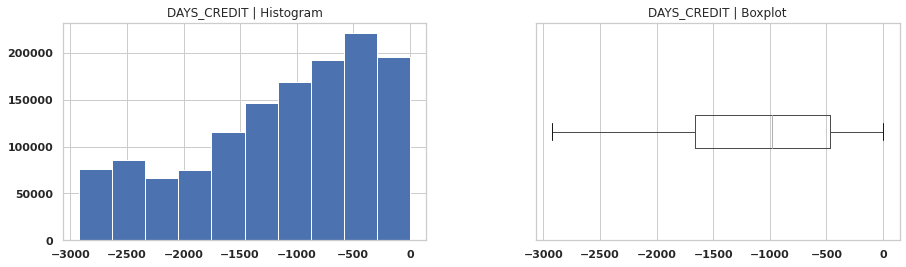

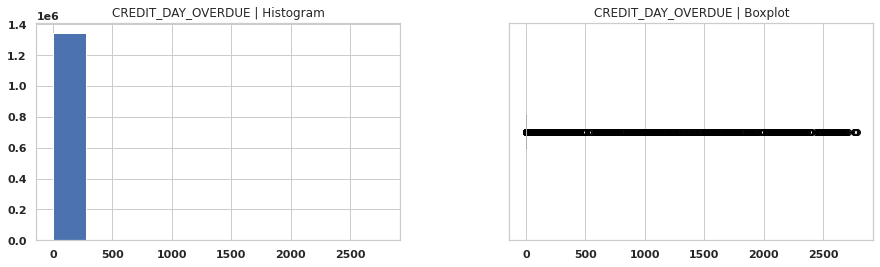

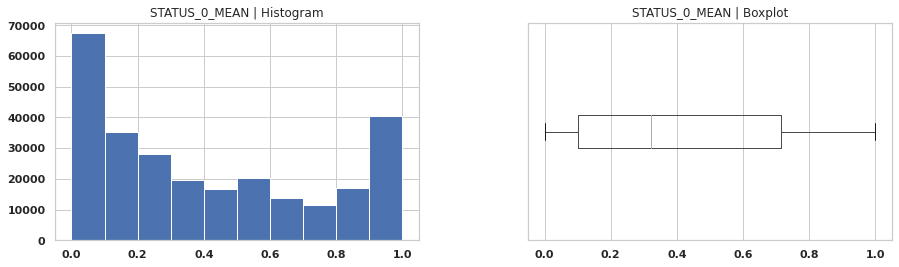

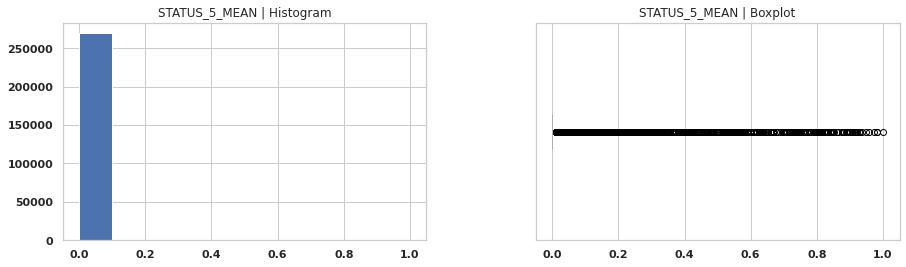

In [106]:
# Dessiner les plots pour les 4 variables suivantes par EXEMPLE
num_variables = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'STATUS_0_MEAN',
                 'STATUS_5_MEAN']
num_plot(df_bbb_merge, num_cols=num_variables, remove=[
    'SK_ID_CURR','SK_ID_BUREAU'], figsize = (15,4))

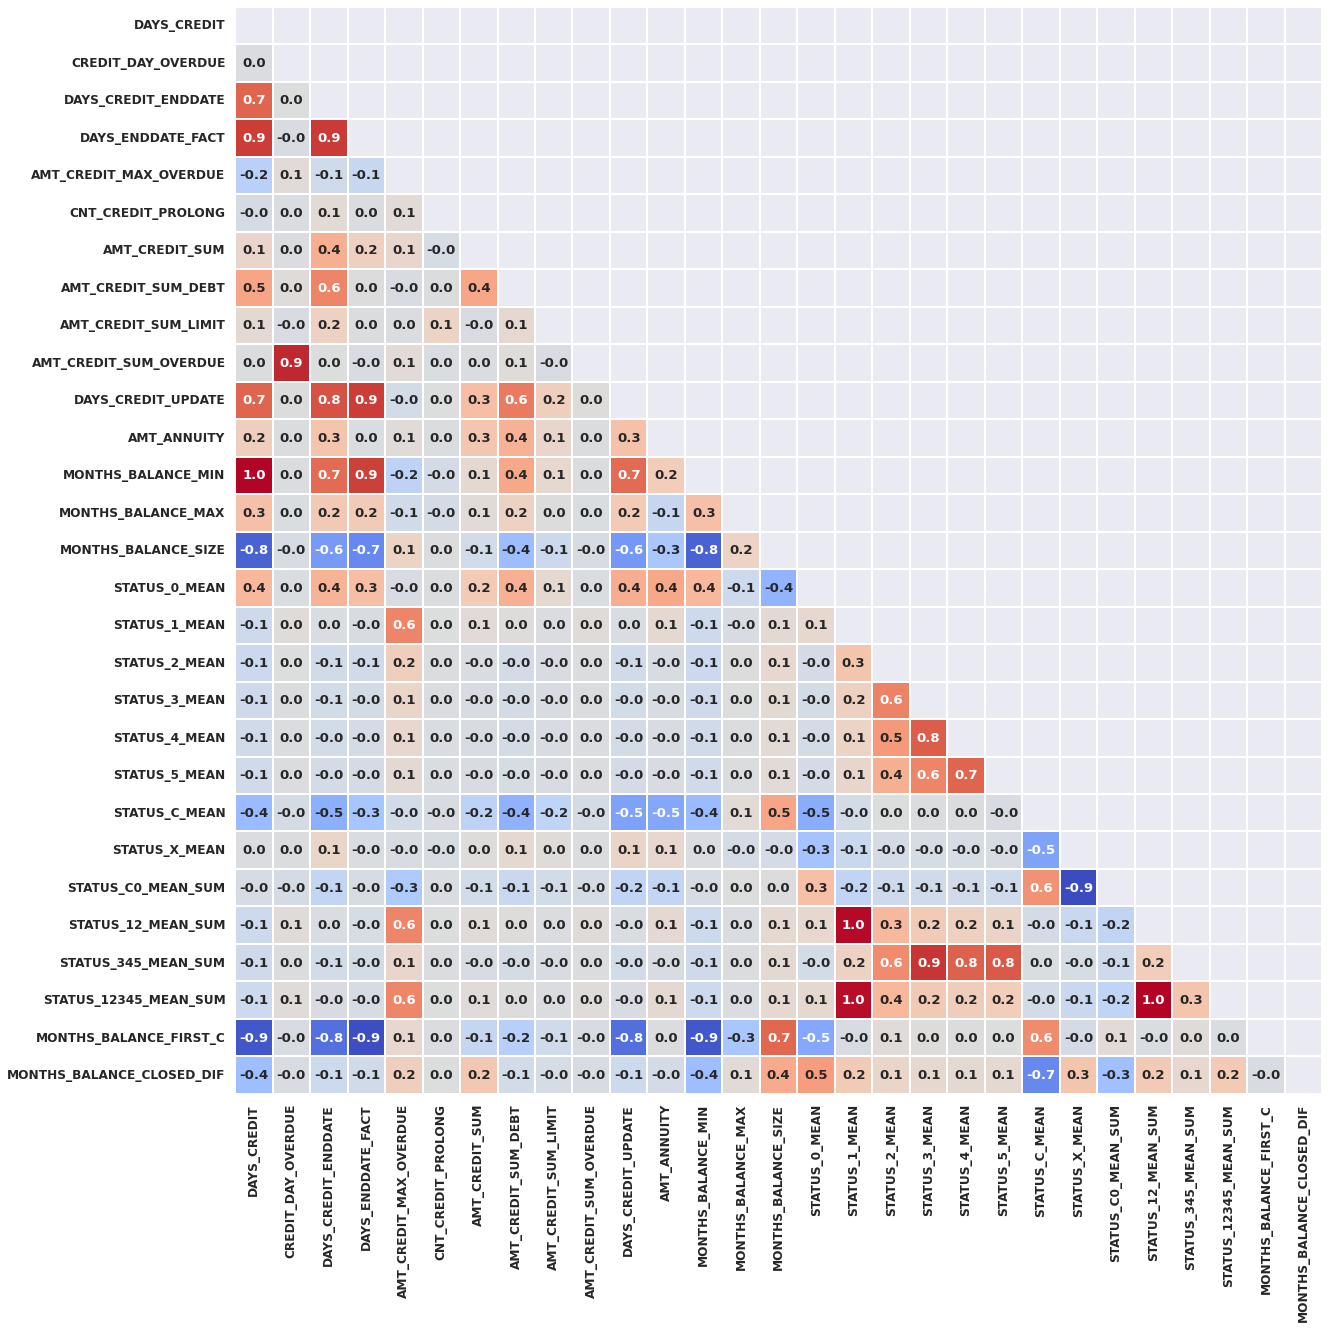

In [107]:
# Analyser la Correlation entre les variables numeriques
corr_plot(df_bbb_merge, remove=['SK_ID_CURR','SK_ID_BUREAU'], corr_coef = "spearman")

In [108]:
# Detecter et lister les variables a correlation elevee dans df_bbb_merge
high_correlation(df_bbb_merge, remove=[
    'SK_ID_CURR','SK_ID_BUREAU'], corr_coef = "spearman", corr_value = 0.7)

DAYS_CREDIT
-------------------------------
MONTHS_BALANCE_MIN        0.999906
DAYS_ENDDATE_FACT         0.873130
DAYS_CREDIT_UPDATE        0.741540
DAYS_CREDIT_ENDDATE       0.739244
MONTHS_BALANCE_SIZE      -0.838201
MONTHS_BALANCE_FIRST_C   -0.892225
Name: DAYS_CREDIT, dtype: float64


CREDIT_DAY_OVERDUE
-------------------------------
AMT_CREDIT_SUM_OVERDUE    0.934372
Name: CREDIT_DAY_OVERDUE, dtype: float64


DAYS_CREDIT_ENDDATE
-------------------------------
DAYS_ENDDATE_FACT         0.879859
DAYS_CREDIT_UPDATE        0.808365
DAYS_CREDIT               0.739244
MONTHS_BALANCE_MIN        0.715870
MONTHS_BALANCE_FIRST_C   -0.776672
Name: DAYS_CREDIT_ENDDATE, dtype: float64


DAYS_ENDDATE_FACT
-------------------------------
DAYS_CREDIT_ENDDATE       0.879859
DAYS_CREDIT               0.873130
DAYS_CREDIT_UPDATE        0.871208
MONTHS_BALANCE_MIN        0.870269
MONTHS_BALANCE_FIRST_C   -0.926904
Name: DAYS_ENDDATE_FACT, dtype: float64


AMT_CREDIT_SUM_OVERDUE
--------------------

In [109]:
# Feature engineering sur le df_bbb_merge (la fusion des fichiers: 
# bureau & bureau_balance) - Variables categorielles
# ################################################################
# Eliminer des variables non pertinantes
df_bbb_merge.drop("CREDIT_CURRENCY", axis = 1, inplace = True)
# Combinaison de categories
df_bbb_merge["CREDIT_ACTIVE"] = np.where(df_bbb_merge.CREDIT_ACTIVE.isin(
    ["Sold", "Bad debt"]), "Sold_BadDebt", df_bbb_merge.CREDIT_ACTIVE)

df_bbb_merge["CREDIT_TYPE"] = np.where(~df_bbb_merge.CREDIT_TYPE.isin(
    ["Consumer credit", "Credit card", "Car loan", "Mortgage", "Microloan"]),
     "Other", df_bbb_merge["CREDIT_TYPE"])
# One-Hot Encoder
df_bbb_merge, get_dummies_bbb = get_dummies_encoder(df_bbb_merge, nan_as_category=False)

In [110]:
# Sauvegarder une copie de df_bb_merge
df_bbb_merge_v1 = df_bbb_merge.copy()

In [111]:
# Restorer df_bb_merge avant aggregation & feature engineering
df_bbb_merge = df_bbb_merge_v1.copy()
df_bbb_merge.head(3)

SK_ID_CURR  SK_ID_BUREAU  ...  CREDIT_TYPE_Mortgage  CREDIT_TYPE_Other
0      215354       5714462  ...                     0                  0
1      215354       5714463  ...                     0                  0
2      215354       5714464  ...                     0                  0

[3 rows x 40 columns]

In [112]:
# Agregations sur le df_bbb_merge (la fusion des fichiers: 
# bureau & bureau_balance)
# ################################################################
# Pour agregations variables numeriques
cal = ['min', 'max', 'mean', 'sum', 'median','std']
cols1 = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_CREDIT_UPDATE',
    'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM',
    'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE','AMT_CREDIT_SUM_LIMIT',
    'AMT_ANNUITY', 'CNT_CREDIT_PROLONG', 'MONTHS_BALANCE_MIN',
    'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_SIZE', 'MONTHS_BALANCE_FIRST_C',
    'MONTHS_BALANCE_CLOSED_DIF']
num_aggregations = {}

for i in cols1:
    num_aggregations[i] = cal
# ################################################################
# Pour agregations variables categorielles
cat_aggregations = {}

for i in get_dummies_bbb:
    cat_aggregations[i] = ['mean']

cols2 = ['STATUS_0_MEAN', 'STATUS_1_MEAN', 'STATUS_2_MEAN', 'STATUS_3_MEAN', 'STATUS_4_MEAN',
        'STATUS_5_MEAN', 'STATUS_C_MEAN', 'STATUS_X_MEAN', 'STATUS_C0_MEAN_SUM',
        'STATUS_12_MEAN_SUM', 'STATUS_345_MEAN_SUM', 'STATUS_12345_MEAN_SUM']
for i in cols2:
    cat_aggregations[i] = ['mean', 'median', 'sum', 'max', 'std']
# ################################################################
# Agregations 
df_bbb_merge_agg_1 = df_bbb_merge.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
df_bbb_merge_agg_1.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in df_bbb_merge_agg_1.columns.tolist()])

In [113]:
df_bbb_merge_agg_1.shape

(262916, 165)

In [114]:
# Feature engineering sur le df_bbb_merge (la fusion des fichiers: 
# bureau & bureau_balance)
# ################################################################
# df_bbb_merge.groupby("SK_ID_CURR").SK_ID_BUREAU.count().value_counts()
# Calculer le nombre de credits anciens (par client) enregistres a Credit Bureau
df_bureau_count = df_bbb_merge.groupby(
    "SK_ID_CURR").SK_ID_BUREAU.count().reset_index().rename(
        {"SK_ID_BUREAU":"BUREAU_COUNT"}, axis = 1)
# Nouvelle variable=0 si #comptes < 4, =1 si [4,8[, =2 si [8, 13[, =3 si [13, 20[, =4 si >=20
df_bureau_count["BUREAU_COUNT_CAT"] = np.where(
    df_bureau_count.BUREAU_COUNT < 4, 0, 1)
df_bureau_count["BUREAU_COUNT_CAT"] = np.where((
    df_bureau_count.BUREAU_COUNT >= 8) & (df_bureau_count.BUREAU_COUNT < 13), 2,
        df_bureau_count["BUREAU_COUNT_CAT"])
df_bureau_count["BUREAU_COUNT_CAT"] = np.where((
    df_bureau_count.BUREAU_COUNT >= 13) & (
        df_bureau_count.BUREAU_COUNT < 20), 3,
            df_bureau_count["BUREAU_COUNT_CAT"])
df_bureau_count["BUREAU_COUNT_CAT"] = np.where((
    df_bureau_count.BUREAU_COUNT >= 20), 4,
        df_bureau_count["BUREAU_COUNT_CAT"])
# #################################################################
df_bbb_bc_merge = pd.merge(df_bbb_merge, df_bureau_count, how = "left",
    on = "SK_ID_CURR")
df_bbb_bc_merge

SK_ID_CURR  SK_ID_BUREAU  ...  BUREAU_COUNT  BUREAU_COUNT_CAT
0            215354       5714462  ...            11                 2
1            215354       5714463  ...            11                 2
2            215354       5714464  ...            11                 2
3            215354       5714465  ...            11                 2
4            215354       5714466  ...            11                 2
...             ...           ...  ...           ...               ...
1344043      426538       6623155  ...             7                 1
1344044      426538       6623156  ...             7                 1
1344045      426538       6623157  ...             7                 1
1344046      426538       6623158  ...             7                 1
1344047      426538       6623159  ...             7                 1

[1344048 rows x 42 columns]

In [115]:
# Agregations numeriques sur comptes si credit actif 
active = df_bbb_merge[df_bbb_merge['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
df_bbb_merge_agg_1 = pd.merge(df_bbb_merge_agg_1, active_agg, how='left', on='SK_ID_CURR')
# Agregations numeriques sur comptes si credit clos 
closed = df_bbb_merge[df_bbb_merge['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
df_bbb_merge_agg_1 = pd.merge(df_bbb_merge_agg_1, closed_agg, how='left', on='SK_ID_CURR')
# Agregations numeriques sur Sold & Bad debt 
sold_baddebt = df_bbb_merge[df_bbb_merge['CREDIT_ACTIVE_Sold_BadDebt'] == 1]
sold_baddebt_agg = sold_baddebt.groupby('SK_ID_CURR').agg(num_aggregations)
sold_baddebt_agg.columns = pd.Index(['SOLD_BADDEBT' + e[0] + "_" + e[1].upper() for e in sold_baddebt_agg.columns.tolist()])
df_bbb_merge_agg_1 = pd.merge(df_bbb_merge_agg_1, sold_baddebt_agg, how='left', on='SK_ID_CURR')

df_bbb_merge_agg_1.reset_index(inplace=True)

In [116]:
# 'Feather' format binaire: Plus rapide pour transferer entre systemes
# Ecrire le fichier au format 'Feather' sur disque
df_bbb_merge_agg_1.to_feather('drive/MyDrive/P7-Project/bureau_bureaubalance_agg_feather')
# pd.read_feather("./bureau_bureaubalance_agg_feather")
print("Shape du fichier 'bureau + bureau_balance' apres EAD: ",
    df_bbb_merge_agg_1.shape, "\n")
# Ecrire le fichier au format csv sur disque
# df_bbb_merge_agg_1.to_csv("bureau_bureaubalance_agg.csv")

Shape du fichier 'bureau + bureau_balance' apres EAD:  (262916, 454) 



In [117]:
# Nettoyer la RAM
del df_bbb_bc_merge, df_bbb_merge_agg_1, df_bbb_merge_v1, df_bureau
del df_bureau_balance, df_bureau_balance_sample, df_bureau_balance_sample_agg
del df_bureau_balance_sample_ohe, df_bureau_count

Note:  Fichiers traites:
***df_bbb_merge_agg_1***: Fusion des fichiers:  
- df_bureau_balance_sample: Fichier bureau_balances
- df_bureau_sample: Fichier bureau  




### EDA & Feature Engineering de la table: POS_CASH_Balance
***Description***:  
'POS_CASH_balance' contient un snapshot mensuel du status des POS et prets precedants avec Home credit (pret sous forme de POS ou loan).   
Pour chaque pret (loan) dans notre fichier 'application', on peut trouver 0-n lignes correpsonantes aux status mensuels de chaque pret precedant.  

English: Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows


In [118]:
# Lire le fichier 'POS_CASH_balance'
df_POS_CASH_balance = pd.read_csv("drive/MyDrive/P7-Project/POS_CASH_balance.csv")

# Collecter des informations générales sur les données 'POS_CASH_balance'
liste_df = {'df_POS_CASH_balance': df_POS_CASH_balance}
info_sur_df(liste_df, 'Informations sur dataframes')

+-------------------------------------------------------------------------------------------------------------+
|                                         Informations sur dataframes                                         |
+---------------------+---------+----------+-------------------------------+----------------------------------+
|         Nom         |  Lignes | Colonnes |             Nan %             |              dtypes              |
+---------------------+---------+----------+-------------------------------+----------------------------------+
| df_POS_CASH_balance | 3362153 |    8     | SK_ID_PREV               0.00 | SK_ID_PREV                 int64 |
|                     |         |          | SK_ID_CURR               0.00 | SK_ID_CURR                 int64 |
|                     |         |          | MONTHS_BALANCE           0.00 | MONTHS_BALANCE             int64 |
|                     |         |          | CNT_INSTALMENT           0.17 | CNT_INSTALMENT           fl

In [119]:
# Detecter et afficher informations sur les variables 
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(
    df_POS_CASH_balance, car_th=10)
df_POS_CASH_balance.head()

Nombre d'Observations: 3362153
Nombre de Variables: 8
Nombre de variables de type: 
	date : 0
	categorie: 1
	numerique: 7
	categorie mais peut etre numerique: 0
	numerique mais peut etre categorie: 0


SK_ID_PREV  SK_ID_CURR  ...  SK_DPD  SK_DPD_DEF
0     1803195      182943  ...     0.0         0.0
1     1715348      367990  ...     0.0         0.0
2     1784872      397406  ...     0.0         0.0
3     1903291      269225  ...     0.0         0.0
4     2341044      334279  ...     0.0         0.0

[5 rows x 8 columns]

In [120]:
# Detecter et affichier informations sur missing values
missing_values(df_POS_CASH_balance, plot = False)

Number of Variables include Missing Values: 5 

                 Feature  Num_Missing  Missing_Ratio DataTypes
0  CNT_INSTALMENT_FUTURE         5621   1.671845e-03   float64
1         CNT_INSTALMENT         5616   1.670358e-03   float64
2   NAME_CONTRACT_STATUS            1   2.974285e-07    object
3                 SK_DPD            1   2.974285e-07   float64
4             SK_DPD_DEF            1   2.974285e-07   float64 



In [121]:
# Analyser & affichier informations sur categories
category_analyzer(df_POS_CASH_balance, 'NAME_CONTRACT_STATUS')

NAME_CONTRACT_STATUS
147                                      Contract
status during the month 170            Contract
status (active signed,...) on the previous credit
190    Contract status (approved, cancelled, ...)
of previous application Name: Description, dtype:
object
                         COUNT         RATIO
Active                 3132558  9.317119e-01
Completed               205453  6.110757e-02
Signed                   21140  6.287638e-03
Approved                  1590  4.729113e-04
Returned to the store     1192  3.545347e-04
Demand                     216  6.424455e-05
XNA                          2  5.948569e-07
Canceled                     1  2.974285e-07




In [122]:
# Statistiques descriptives des variables numeriques
df_POS_CASH_balance.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe(
    [.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

MONTHS_BALANCE  CNT_INSTALMENT  ...       SK_DPD  SK_DPD_DEF
mean      -31.478147       19.679805  ...     0.432856    0.072278
std        25.189747       13.816008  ...    17.709754    1.536228
min       -96.000000        1.000000  ...     0.000000    0.000000
1%        -94.000000        3.000000  ...     0.000000    0.000000
10%       -75.000000        6.000000  ...     0.000000    0.000000
25%       -45.000000       10.000000  ...     0.000000    0.000000
50%       -22.000000       12.000000  ...     0.000000    0.000000
75%       -12.000000       24.000000  ...     0.000000    0.000000
80%       -10.000000       30.000000  ...     0.000000    0.000000
90%        -6.000000       36.000000  ...     0.000000    0.000000
95%        -4.000000       48.000000  ...     0.000000    0.000000
99%        -2.000000       60.000000  ...     5.000000    1.000000
max        -1.000000       92.000000  ...  2945.000000  357.000000

[13 rows x 5 columns]

In [123]:
num_cols

['SK_ID_PREV',
 'SK_ID_CURR',
 'MONTHS_BALANCE',
 'CNT_INSTALMENT',
 'CNT_INSTALMENT_FUTURE',
 'SK_DPD',
 'SK_DPD_DEF']

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


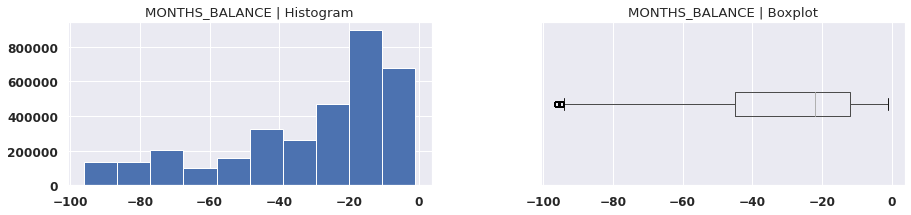

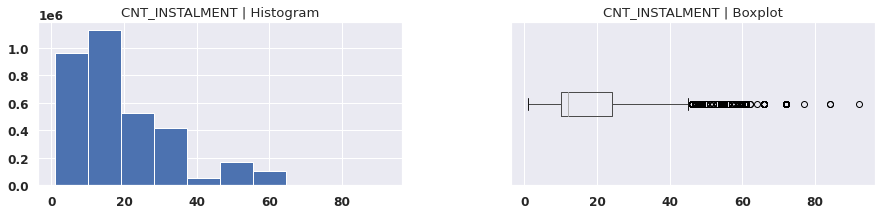

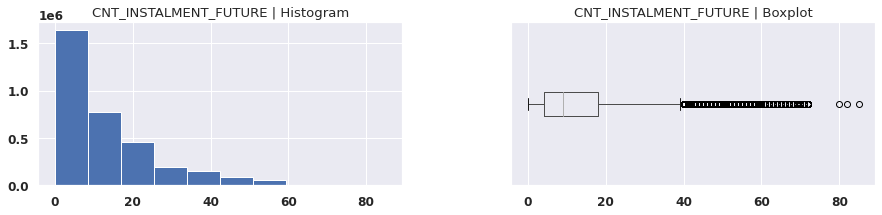

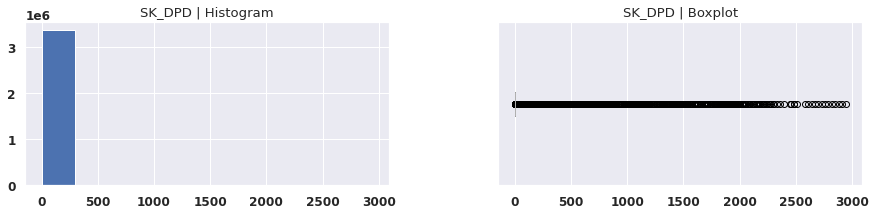

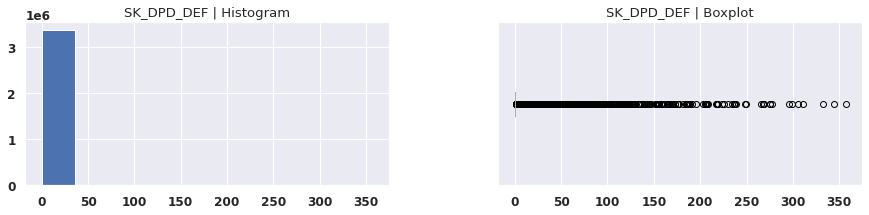

In [124]:
# Dessiner les plots pour les variables numeriques
variables = ['MONTHS_BALANCE', 'CNT_INSTALMENT', 'SK_DPD_DEF']
num_plot(df_POS_CASH_balance, num_cols=num_cols, remove=[
    'SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

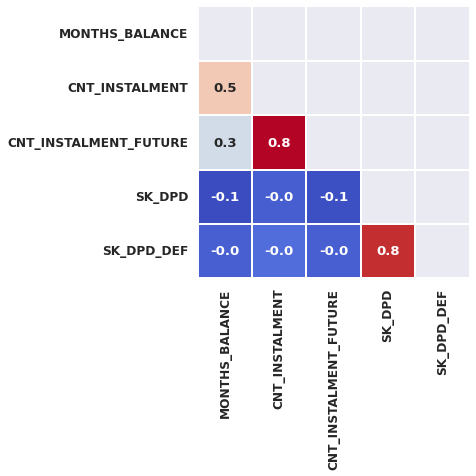

In [125]:
# Analyser la Correlation entre les variables numeriques
corr_plot(df_POS_CASH_balance, remove=['SK_ID_CURR','SK_ID_PREV'],
    corr_coef = "spearman", figsize = (5,5))

In [126]:
# Combinaison de categories 
df_POS_CASH_balance['NAME_CONTRACT_STATUS'] = np.where(
    ~(df_POS_CASH_balance['NAME_CONTRACT_STATUS'].isin([
        'Active', 'Completed'])), 'Rare', df_POS_CASH_balance[
            'NAME_CONTRACT_STATUS'])

# Codage des var categorielles avec One-Hot Encoder
df_POS_CASH_balance, get_dummies_pos_cash = get_dummies_encoder(df_POS_CASH_balance,
    nan_as_category=False)

# Agregations pour var numeriques
aggregations = {'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'CNT_INSTALMENT': ['max', 'mean', 'std', 'min', 'median'],
    'CNT_INSTALMENT_FUTURE': ['max', 'mean', 'sum', 'min', 'median', 'std'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']}
# Agregations pour var Categorielles
for cat in get_dummies_pos_cash:
    aggregations[cat] = ['mean']
# Aggregations
df_POS_CASH_balance_agg = df_POS_CASH_balance.groupby(
    'SK_ID_CURR').agg(aggregations)
df_POS_CASH_balance_agg.columns = pd.Index(
    ['POS_' + e[0] + "_" + e[1].upper()
        for e in df_POS_CASH_balance_agg.columns.tolist()])
# Count pos cash accounts
df_POS_CASH_balance_agg['POS_COUNT'] = df_POS_CASH_balance.groupby(
    'SK_ID_CURR').size()
df_POS_CASH_balance_agg.reset_index(inplace = True)

In [127]:
print('Shape du fichier \'POS_CASH_Balance\' apres agreagations & OHE: ',
    df_POS_CASH_balance_agg.shape, '\n')
df_POS_CASH_balance_agg.head(3)

Shape du fichier 'POS_CASH_Balance' apres agreagations & OHE:  (315613, 23) 



SK_ID_CURR  ...  POS_COUNT
0      100001  ...          3
1      100002  ...          3
2      100003  ...         10

[3 rows x 23 columns]

In [128]:
# 'Feather' format binaire: Plus rapide pour transferer entre systemes
# Ecrire le fichier au format 'Feather' sur disque
df_POS_CASH_balance_agg.to_feather(
    'drive/MyDrive/P7-Project/poscashbalance_agg_feather')
# pd.read_feather('poscashbalance_agg_feather')
print('Shape du fichier \'POS_CASH_balance\' apres EAD: ',
    df_POS_CASH_balance_agg.shape, "\n")

Shape du fichier 'POS_CASH_balance' apres EAD:  (315613, 23) 



In [129]:
# Nettoyer la RAM
del df_POS_CASH_balance_agg

Note:  Fichiers traites:
***df_bbb_merge_agg_1***: Fusion des fichiers:  
- df_bureau_balance_sample: Fichier bureau_balances
- df_bureau_sample: Fichier bureau  

***df_POS_CASH_Balance_agg***: Fichier POS_CASH_Balance  
 



### EDA & Feature Engineering de la table: credit_card_balance 
***Description***  
'credit_card_balance' contient un snapshot mensuel du status des prets precedants avec Home Credit (pret sous forme de credit card ou cash loan).   
Pour chaque pret (loan) dans notre fichier 'application, on peut trouver 0-n lignes correpsonantes aux status mensuels de chaque pret precedant.  

***English***: Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows. 


In [130]:
# Lire le fichier 'credit_card_balance'
df_credit_card_balance = pd.read_csv(
    'drive/MyDrive/P7-Project/credit_card_balance.csv')

# Collecter des informations générales sur les données 'df_credit_card_balance'
liste_df = {'df_credit_card_balance': df_credit_card_balance}
info_sur_df(liste_df, 'Informations sur dataframes')

+---------------------------------------------------------------------------------------------------------------------------+
|                                                Informations sur dataframes                                                |
+------------------------+---------+----------+-------------------------------------+---------------------------------------+
|          Nom           |  Lignes | Colonnes |                Nan %                |                 dtypes                |
+------------------------+---------+----------+-------------------------------------+---------------------------------------+
| df_credit_card_balance | 1210475 |    23    | SK_ID_PREV                     0.00 | SK_ID_PREV                      int64 |
|                        |         |          | SK_ID_CURR                     0.00 | SK_ID_CURR                      int64 |
|                        |         |          | MONTHS_BALANCE                 0.00 | MONTHS_BALANCE                  

In [131]:
# Detecter et afficher informations sur les variables 
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(
    df_credit_card_balance, car_th=10)
df_credit_card_balance.head()

Nombre d'Observations: 1210475
Nombre de Variables: 23
Nombre de variables de type: 
	date : 0
	categorie: 1
	numerique: 22
	categorie mais peut etre numerique: 0
	numerique mais peut etre categorie: 0


SK_ID_PREV  SK_ID_CURR  ...  SK_DPD  SK_DPD_DEF
0     2562384      378907  ...     0.0         0.0
1     2582071      363914  ...     0.0         0.0
2     1740877      371185  ...     0.0         0.0
3     1389973      337855  ...     0.0         0.0
4     1891521      126868  ...     0.0         0.0

[5 rows x 23 columns]

In [132]:
# Detecter et affichier informations sur missing values
missing_values(df_credit_card_balance, plot = False)

Number of Variables include Missing Values: 20 

                       Feature  Num_Missing  Missing_Ratio DataTypes
0          AMT_PAYMENT_CURRENT       250279   2.067610e-01   float64
1     AMT_DRAWINGS_ATM_CURRENT       247283   2.042859e-01   float64
2     CNT_DRAWINGS_POS_CURRENT       247283   2.042859e-01   float64
3   AMT_DRAWINGS_OTHER_CURRENT       247283   2.042859e-01   float64
4     AMT_DRAWINGS_POS_CURRENT       247283   2.042859e-01   float64
5   CNT_DRAWINGS_OTHER_CURRENT       247283   2.042859e-01   float64
6     CNT_DRAWINGS_ATM_CURRENT       247283   2.042859e-01   float64
7    CNT_INSTALMENT_MATURE_CUM        89202   7.369173e-02   float64
8      AMT_INST_MIN_REGULARITY        89202   7.369173e-02   float64
9    AMT_PAYMENT_TOTAL_CURRENT            1   8.261220e-07   float64
10        AMT_TOTAL_RECEIVABLE            1   8.261220e-07   float64
11                      SK_DPD            1   8.261220e-07   float64
12        NAME_CONTRACT_STATUS            1   8.261220

In [133]:
# Analyser & affichier informations sur categories
category_analyzer(df_credit_card_balance, 'NAME_CONTRACT_STATUS')

NAME_CONTRACT_STATUS
147                                      Contract
status during the month 170            Contract
status (active signed,...) on the previous credit
190    Contract status (approved, cancelled, ...)
of previous application Name: Description, dtype:
object
                 COUNT     RATIO
Active         1160819  0.958978
Completed        45342  0.037458
Signed            3687  0.003046
Demand             451  0.000373
Sent proposal      169  0.000140
Refused              4  0.000003
Approved             2  0.000002




In [134]:
# Statistiques descriptives des variables numeriques
df_credit_card_balance.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe(
    [.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

MONTHS_BALANCE   AMT_BALANCE  ...       SK_DPD   SK_DPD_DEF
mean      -34.173638  5.593166e+04  ...     9.175800     0.375113
std        27.570366  1.022810e+05  ...    98.414558    23.204015
min       -96.000000 -2.614710e+05  ...     0.000000     0.000000
1%        -94.000000  0.000000e+00  ...     0.000000     0.000000
10%       -78.000000  0.000000e+00  ...     0.000000     0.000000
25%       -56.000000  0.000000e+00  ...     0.000000     0.000000
50%       -26.000000  0.000000e+00  ...     0.000000     0.000000
75%       -10.000000  8.630016e+04  ...     0.000000     0.000000
80%        -8.000000  1.135171e+05  ...     0.000000     0.000000
90%        -4.000000  1.770870e+05  ...     0.000000     0.000000
95%        -3.000000  2.429734e+05  ...     0.000000     0.000000
99%        -1.000000  4.613711e+05  ...   244.000000     1.000000
max        -1.000000  1.505902e+06  ...  3229.000000  3229.000000

[13 rows x 20 columns]

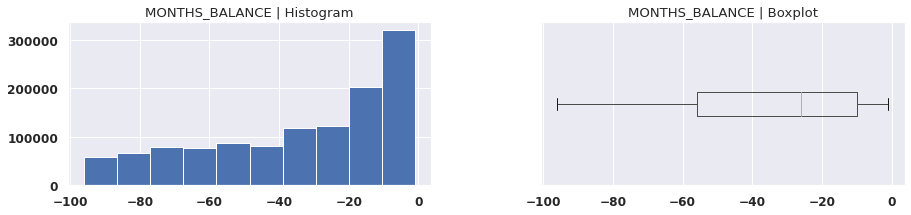

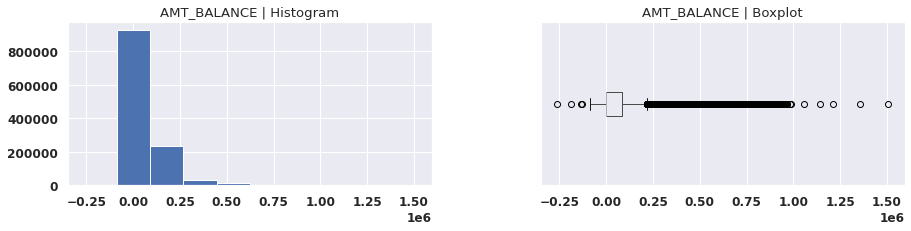

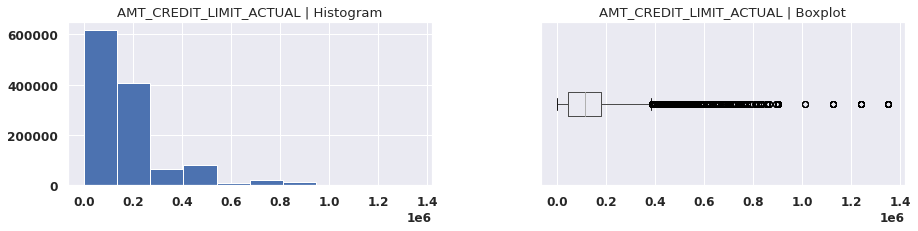

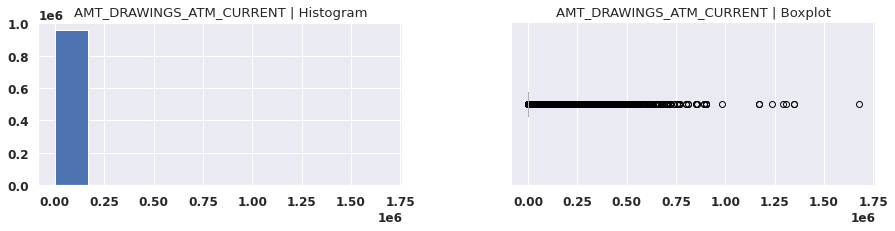

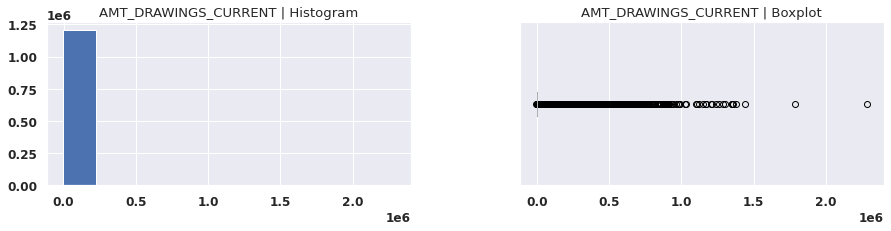

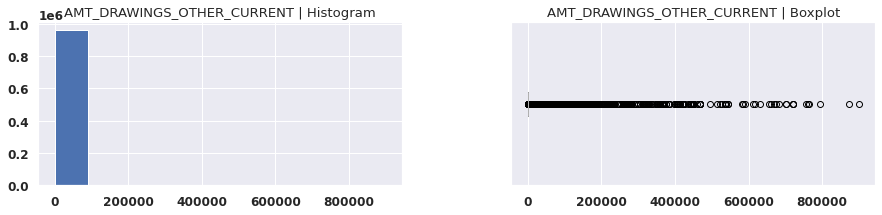

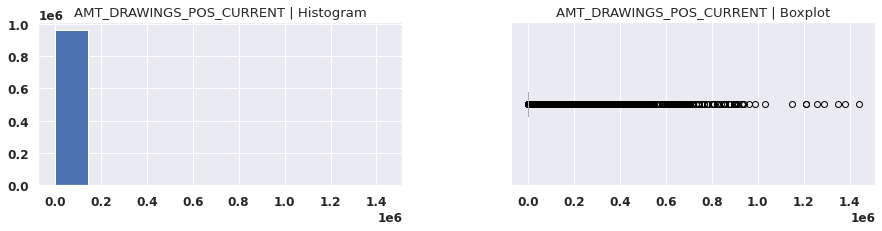

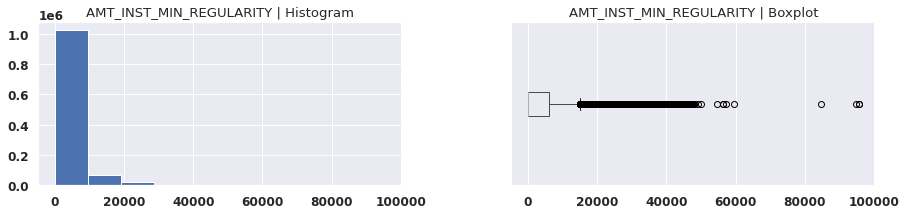

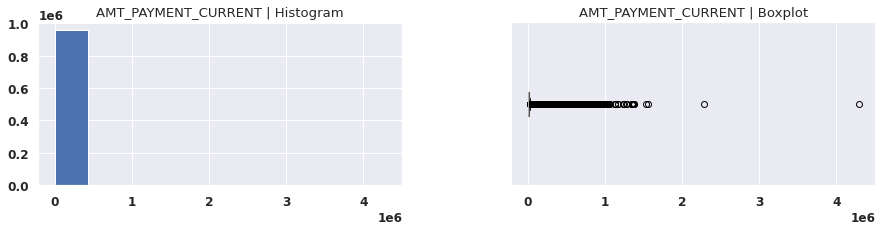

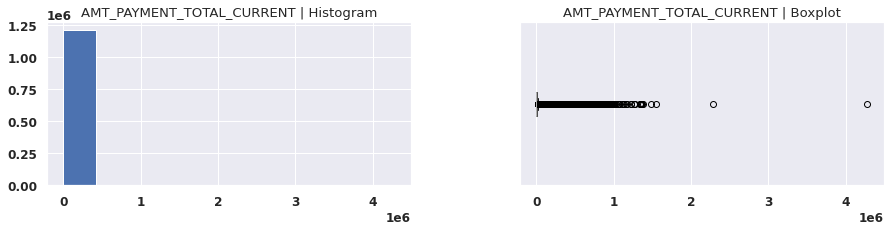

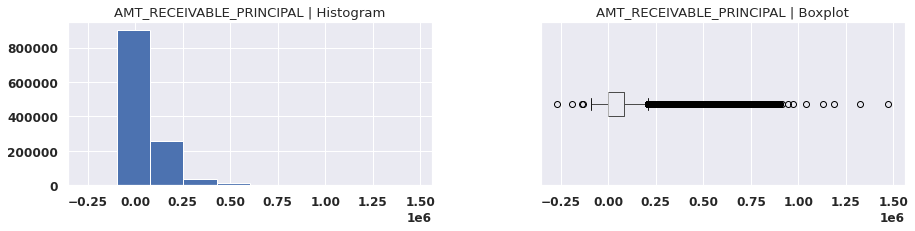

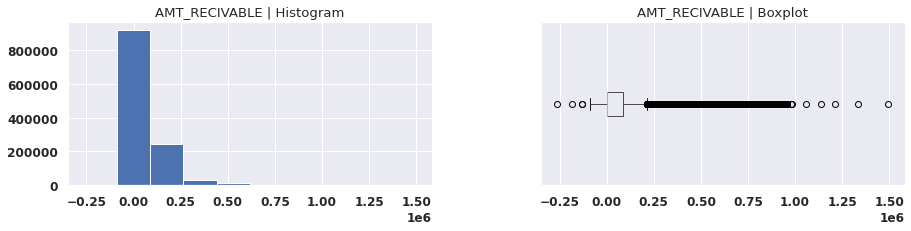

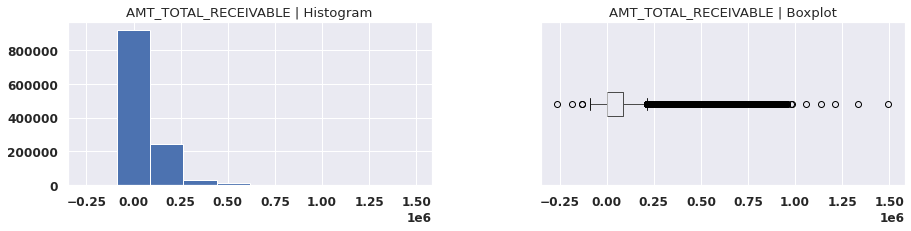

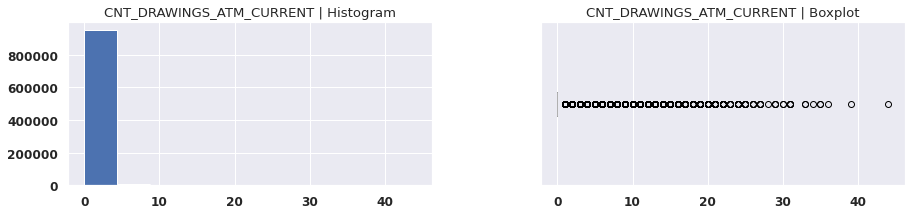

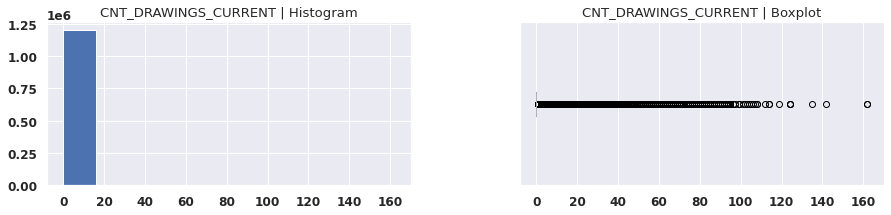

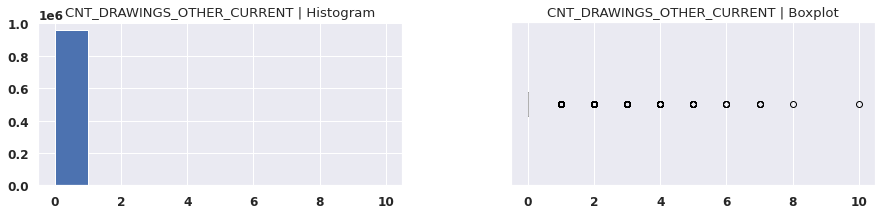

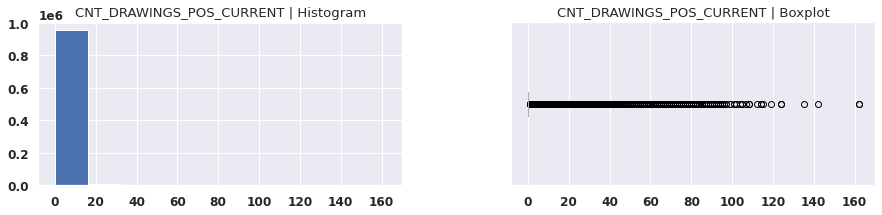

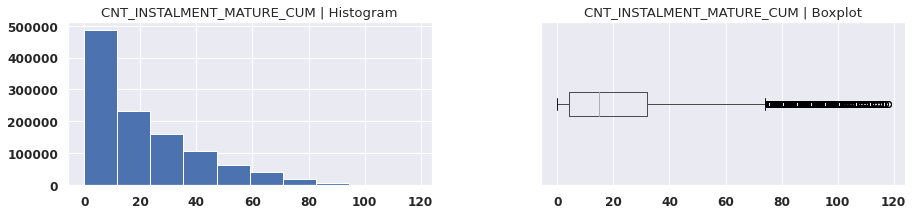

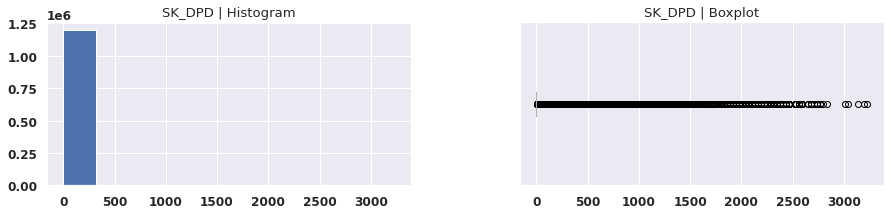

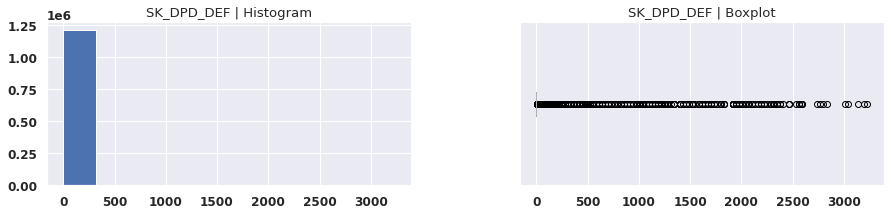

In [135]:
# Dessiner les plots pour les variables numeriques
num_plot(df_credit_card_balance, num_cols=num_cols, remove=[
    'SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

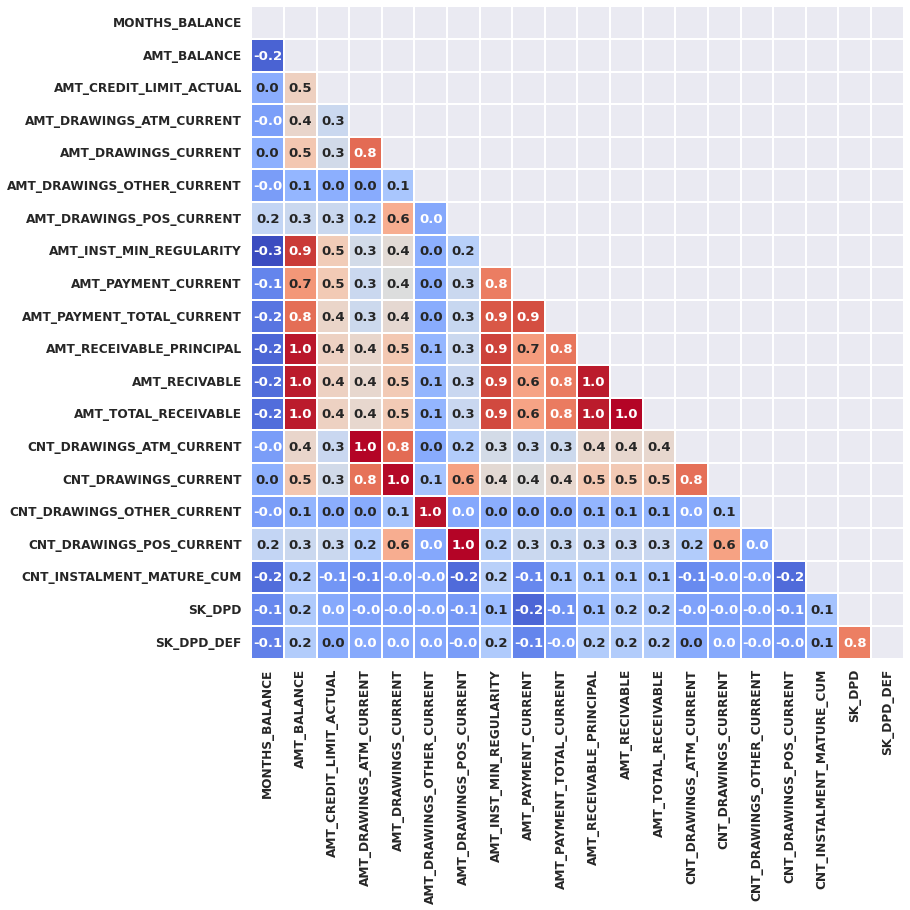

In [136]:
# Analyser la Correlation entre les variables numeriques
corr_plot(df_credit_card_balance, remove=['SK_ID_CURR','SK_ID_PREV'],
    corr_coef = "spearman", figsize = (12,12))

In [137]:
# Combinaison de categories 
df_credit_card_balance['NAME_CONTRACT_STATUS'] = np.where(
    ~(df_credit_card_balance['NAME_CONTRACT_STATUS'].isin([
        'Active', 'Completed'])), 'Rare',
            df_credit_card_balance['NAME_CONTRACT_STATUS'])
# Codage des var categorielles avec One-Hot Encoder
df_credit_card_balance, get_dummies_card_balance = get_dummies_encoder(
    df_credit_card_balance, nan_as_category=False)

# Aagregations
df_credit_card_balance.drop(['SK_ID_PREV'], axis=1, inplace=True)
df_credit_card_balance_agg = df_credit_card_balance.groupby('SK_ID_CURR').agg(
    ['min', 'max', 'mean', 'sum', 'std'])
df_credit_card_balance_agg.columns = pd.Index(
    ['CC_' + e[0] + "_" + e[1].upper() for 
        e in df_credit_card_balance_agg.columns.tolist()])
# Compter les lignes dans 'credit card' pour chaque clients
df_credit_card_balance_agg['CC_COUNT'] = df_credit_card_balance.groupby(
    'SK_ID_CURR').size()
df_credit_card_balance_agg.reset_index(inplace = True)

In [138]:
print('Shape du fichier \'Credit_card_balance\' :',
    df_credit_card_balance_agg.shape, '\n')
df_credit_card_balance_agg.head()

Shape du fichier 'Credit_card_balance' : (100373, 117) 



SK_ID_CURR  ...  CC_COUNT
0      100006  ...         3
1      100011  ...        23
2      100013  ...        22
3      100021  ...         4
4      100023  ...         1

[5 rows x 117 columns]

In [139]:
# 'Feather' format binaire: Plus rapide pour transferer entre systemes
# Ecrire le fichier au format 'Feather' sur disque
df_credit_card_balance_agg.to_feather('drive/MyDrive/P7-Project/creditcardbalance_agg_feather')
# pd.read_feather('credit_card_balance_agg_feather')
print('Shape du fichier \'df_credit_card_balance_agg\' apres EAD: ',
    df_credit_card_balance_agg.shape, "\n")

Shape du fichier 'df_credit_card_balance_agg' apres EAD:  (100373, 117) 



In [140]:
# Nettoyer la RAM
del df_credit_card_balance_agg

Note:  Fichiers traites:
***df_bbb_merge_agg_1***: Fusion des fichiers:  
- df_bureau_balance_sample: Fichier bureau_balances
- df_bureau_sample: Fichier bureau  

***df_POS_CASH_Balance_agg***: Fichier POS_CASH_Balance  
***df_credit_card_balance_agg***: Fichier credit_card_balance  


### EDA & Feature Engineering de la table: installments_payments 
***Description***  
'installments_payments' contient l'historique de remboursement des crédits anciens de Home Credit, qui correspondent au clients dans 'applications'.   
Pour chaque pret (loan) dans notre fichier 'application', on peut trouver 0-n lignes correpsonantes aux remboursements faits pour chaque pret precedant fait par le client.  
***English***: Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [141]:
# Lire le fichier 'installments_payments'
df_installments_payments = pd.read_csv(
    'drive/MyDrive/P7-Project/installments_payments.csv')

# Collecter des informations générales sur les données 'df_installments_payments'
liste_df = {'df_installments_payments': df_installments_payments}
info_sur_df(liste_df, 'Informations sur dataframes')

+-------------------------------------------------------------------------------------------------------------------+
|                                            Informations sur dataframes                                            |
+--------------------------+---------+----------+-------------------------------+-----------------------------------+
|           Nom            |  Lignes | Colonnes |             Nan %             |               dtypes              |
+--------------------------+---------+----------+-------------------------------+-----------------------------------+
| df_installments_payments | 2485740 |    8     | SK_ID_PREV                0.0 | SK_ID_PREV                  int64 |
|                          |         |          | SK_ID_CURR                0.0 | SK_ID_CURR                float64 |
|                          |         |          | NUM_INSTALMENT_VERSION    0.0 | NUM_INSTALMENT_VERSION    float64 |
|                          |         |          | NUM_IN

In [142]:
# Detecter et afficher informations sur les variables 
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(
    df_installments_payments, car_th=10)
df_installments_payments.head()

Nombre d'Observations: 2485740
Nombre de Variables: 8
Nombre de variables de type: 
	date : 0
	categorie: 0
	numerique: 8
	categorie mais peut etre numerique: 0
	numerique mais peut etre categorie: 0


SK_ID_PREV  SK_ID_CURR  ...  AMT_INSTALMENT  AMT_PAYMENT
0     1054186    161674.0  ...        6948.360     6948.360
1     1330831    151639.0  ...        1716.525     1716.525
2     2085231    193053.0  ...       25425.000    25425.000
3     2452527    199697.0  ...       24350.130    24350.130
4     2714724    167756.0  ...        2165.040     2160.585

[5 rows x 8 columns]

In [143]:
# Detecter et affichier informations sur missing values
missing_values(df_installments_payments, plot = False)

Number of Variables include Missing Values: 7 

                  Feature  Num_Missing  Missing_Ratio DataTypes
0              SK_ID_CURR            1   4.022947e-07   float64
1  NUM_INSTALMENT_VERSION            1   4.022947e-07   float64
2   NUM_INSTALMENT_NUMBER            1   4.022947e-07   float64
3         DAYS_INSTALMENT            1   4.022947e-07   float64
4      DAYS_ENTRY_PAYMENT            1   4.022947e-07   float64
5          AMT_INSTALMENT            1   4.022947e-07   float64
6             AMT_PAYMENT            1   4.022947e-07   float64 



In [144]:
# Statistiques descriptives des variables numeriques
df_installments_payments.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe(
    [.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

NUM_INSTALMENT_VERSION  ...   AMT_PAYMENT
mean                0.855137  ...  1.725822e+04
std                 0.999203  ...  5.540994e+04
min                 0.000000  ...  0.000000e+00
1%                  0.000000  ...  3.735000e+00
10%                 0.000000  ...  3.326400e+02
25%                 0.000000  ...  3.395610e+03
50%                 1.000000  ...  8.121510e+03
75%                 1.000000  ...  1.605600e+04
80%                 1.000000  ...  1.927912e+04
90%                 1.000000  ...  3.090613e+04
95%                 2.000000  ...  4.741925e+04
99%                 4.000000  ...  1.788900e+05
max                43.000000  ...  3.473583e+06

[13 rows x 6 columns]

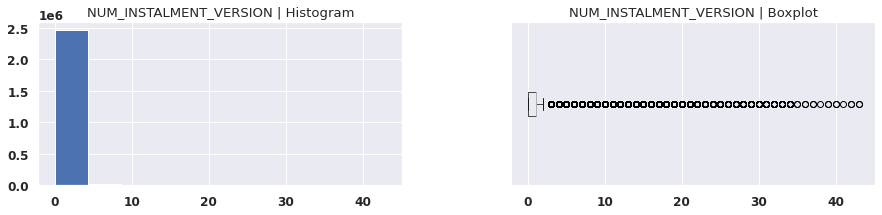

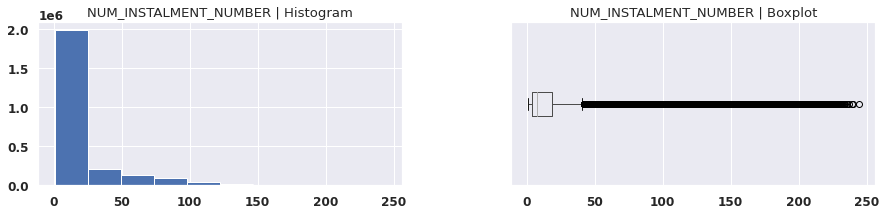

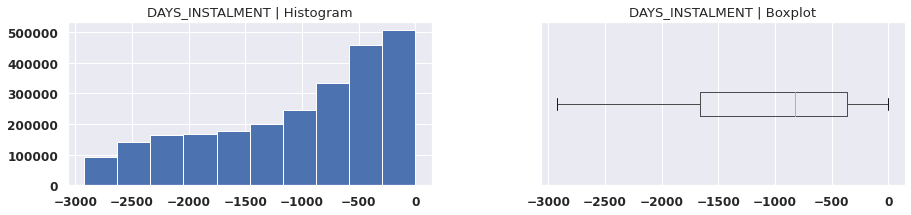

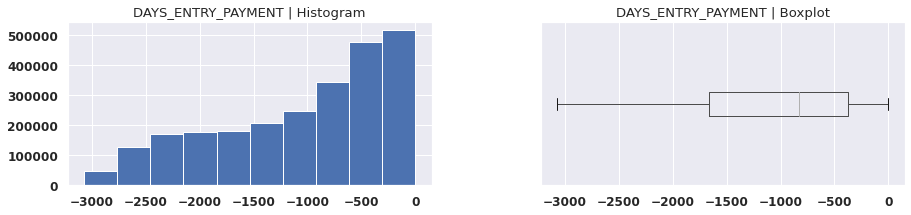

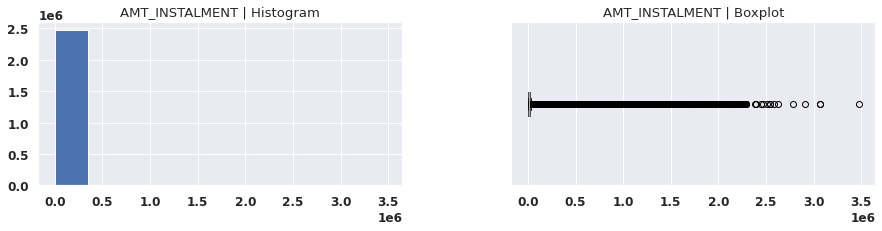

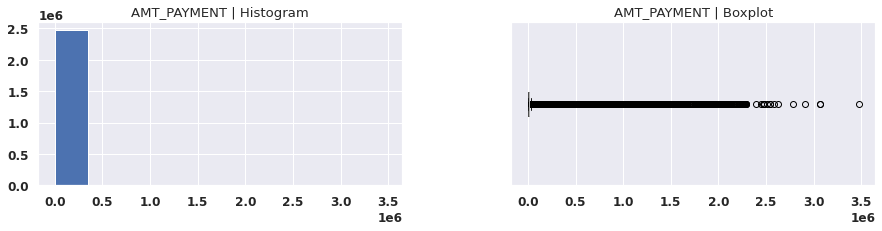

In [145]:
# Dessiner les plots pour les variables numeriques
num_plot(df_installments_payments, num_cols=num_cols, remove=[
    'SK_ID_CURR','SK_ID_PREV'], figsize = (15,3))

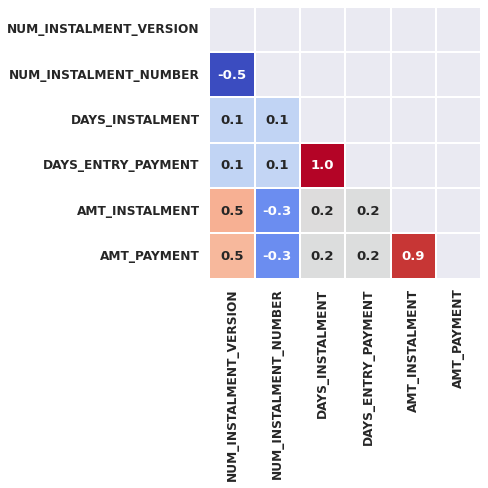

In [ ]:
# Analyser la Correlation entre les variables numeriques
corr_plot(df_installments_payments, remove=['SK_ID_CURR','SK_ID_PREV'],
    corr_coef = "spearman", figsize = (5,5))

In [146]:
# Detecter et lister les variables a correlation elevee dans df_bbb_merge
high_correlation(df_installments_payments, remove=[
    'SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", corr_value = 0.7)

DAYS_INSTALMENT
-------------------------------
DAYS_ENTRY_PAYMENT    0.999413
Name: DAYS_INSTALMENT, dtype: float64


DAYS_ENTRY_PAYMENT
-------------------------------
DAYS_INSTALMENT    0.999413
Name: DAYS_ENTRY_PAYMENT, dtype: float64


AMT_INSTALMENT
-------------------------------
AMT_PAYMENT    0.916294
Name: AMT_INSTALMENT, dtype: float64


AMT_PAYMENT
-------------------------------
AMT_INSTALMENT    0.916294
Name: AMT_PAYMENT, dtype: float64




In [147]:
# Nouveaux features: Pourcentage & difference entre montant paye & due
df_installments_payments['PAYMENT_PERC'] = df_installments_payments[
    'AMT_PAYMENT'] / df_installments_payments['AMT_INSTALMENT']
df_installments_payments['PAYMENT_DIFF'] = df_installments_payments[
    'AMT_INSTALMENT'] - df_installments_payments['AMT_PAYMENT']
# Nouveaux features: Days past due & Days after due
df_installments_payments['DPD'] = df_installments_payments[
    'DAYS_ENTRY_PAYMENT'] - df_installments_payments['DAYS_INSTALMENT']
df_installments_payments['DBD'] = df_installments_payments[
    'DAYS_INSTALMENT'] - df_installments_payments['DAYS_ENTRY_PAYMENT']
df_installments_payments['DPD'] = df_installments_payments['DPD'].apply(
    lambda x: x if x > 0 else 0)
df_installments_payments['DBD'] = df_installments_payments['DBD'].apply(
    lambda x: x if x > 0 else 0)
# Aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'NUM_INSTALMENT_NUMBER': ['max', 'mean', 'sum', 'median', 'std'],
    'DAYS_INSTALMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum', 'median', 'std'],
    'DPD': ['max', 'mean', 'sum', 'median', 'std'],
    'DBD': ['max', 'mean', 'sum', 'median', 'std'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'std', 'median'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'std', 'median']
}

df_installments_payments_agg = df_installments_payments.groupby(
    'SK_ID_CURR').agg(aggregations)
df_installments_payments_agg.columns = pd.Index(
    ['INS_' + e[0] + "_" + e[1].upper() for e in df_installments_payments_agg.columns.tolist()])
# Count installments accounts
# Compter les lignes dans 'installments' pour chaque clients
df_installments_payments_agg['INS_COUNT'] = df_installments_payments.groupby(
    'SK_ID_CURR').size()

df_installments_payments_agg.reset_index(inplace = True)

In [148]:
print('Shape du fichier \'installments_payments\' :',
    df_installments_payments_agg.shape, '\n')
df_installments_payments_agg.head()

Shape du fichier 'installments_payments' : (95137, 49) 



SK_ID_CURR  ...  INS_COUNT
0    100001.0  ...          2
1    100002.0  ...         14
2    100003.0  ...         20
3    100004.0  ...          1
4    100005.0  ...          5

[5 rows x 49 columns]

In [149]:
# 'Feather' format binaire: Plus rapide pour transferer entre systemes
# Ecrire le fichier au format 'Feather' sur disque
df_installments_payments_agg.to_feather(
    'drive/MyDrive/P7-Project/installments_payments_agg_feather')
# pd.read_feather('credit_card_balance_agg_feather')
print('Shape du fichier \'df_installments_payments_agg\' apres EAD: ',
    df_installments_payments_agg.shape, "\n")

Shape du fichier 'df_installments_payments_agg' apres EAD:  (95137, 49) 



In [150]:
# Nettoyer la RAM
del df_installments_payments_agg

Note:  Fichiers traites:
***df_bbb_merge_agg_1***: Fusion des fichiers:  
- df_bureau_balance_sample: Fichier bureau_balances
- df_bureau_sample: Fichier bureau  

***df_POS_CASH_Balance_agg***: Fichier POS_CASH_Balance  
***df_credit_card_balance_agg***: Fichier credit_card_balance  
***df_installments_payments_agg***: Fichier installments_payments  


### EDA & Feature Engineering de la table: previous_application 
***Description***  
Contient toutes les anciennes demandes faites par les clients (figurants dans 'applications') a Home Credit.  
Pour chaque pret (loan) dans notre fichier 'application', on peut trouver 0-n lignes (anciennes demandes) faites par le client.  
***English***:  
- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

In [151]:
# Lire le fichier 'previous_application'
df_previous_application = pd.read_csv(
    'drive/MyDrive/P7-Project/previous_application.csv')
# Collecter des informations générales sur les données 'df_previous_application'
liste_df = {'df_previous_application': df_previous_application}
info_sur_df(liste_df, 'Informations sur dataframes')

+-----------------------------------------------------------------------------------------------------------------------------+
|                                                 Informations sur dataframes                                                 |
+-------------------------+--------+----------+--------------------------------------+----------------------------------------+
|           Nom           | Lignes | Colonnes |                Nan %                 |                 dtypes                 |
+-------------------------+--------+----------+--------------------------------------+----------------------------------------+
| df_previous_application | 543969 |    37    | SK_ID_PREV                      0.00 | SK_ID_PREV                       int64 |
|                         |        |          | SK_ID_CURR                      0.00 | SK_ID_CURR                       int64 |
|                         |        |          | NAME_CONTRACT_TYPE              0.00 | NAME_CONTRACT_TYP

In [152]:
# Detecter et afficher informations sur les variables 
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(
    df_previous_application, car_th=10)
df_previous_application.head()

Nombre d'Observations: 543969
Nombre de Variables: 37
Nombre de variables de type: 
	date : 0
	categorie: 14
	numerique: 19
	categorie mais peut etre numerique: 4
	numerique mais peut etre categorie: 2


SK_ID_PREV  SK_ID_CURR  ... DAYS_TERMINATION  NFLAG_INSURED_ON_APPROVAL
0     2030495      271877  ...            -37.0                        0.0
1     2802425      108129  ...         365243.0                        1.0
2     2523466      122040  ...         365243.0                        1.0
3     2819243      176158  ...           -177.0                        1.0
4     1784265      202054  ...              NaN                        NaN

[5 rows x 37 columns]

In [153]:
# Detecter et affichier informations sur missing values
missing_values(df_previous_application, plot = False)

Number of Variables include Missing Values: 20 

                      Feature  Num_Missing  Missing_Ratio DataTypes
0    RATE_INTEREST_PRIVILEGED       542021       0.996419   float64
1       RATE_INTEREST_PRIMARY       542021       0.996419   float64
2           RATE_DOWN_PAYMENT       289328       0.531883   float64
3            AMT_DOWN_PAYMENT       289328       0.531883   float64
4             NAME_TYPE_SUITE       267306       0.491399    object
5   NFLAG_INSURED_ON_APPROVAL       217628       0.400074   float64
6          DAYS_FIRST_DRAWING       217628       0.400074   float64
7              DAYS_FIRST_DUE       217628       0.400074   float64
8   DAYS_LAST_DUE_1ST_VERSION       217628       0.400074   float64
9               DAYS_LAST_DUE       217628       0.400074   float64
10           DAYS_TERMINATION       217628       0.400074   float64
11            AMT_GOODS_PRICE       124593       0.229044   float64
12                AMT_ANNUITY       120753       0.221985   float64

In [154]:
# Lister les variables categorielles
print(cat_cols, cat_but_car)

['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_YIELD_GROUP', 'NFLAG_LAST_APPL_IN_DAY', 'NFLAG_INSURED_ON_APPROVAL'] ['NAME_CASH_LOAN_PURPOSE', 'NAME_GOODS_CATEGORY', 'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION']


In [155]:
# Analyser & affichier informations sur categories
cat_list = cat_cols + cat_but_car
print(len(cat_list), '\n')
for col in cat_list:
    category_analyzer(df_previous_application, col)

18 

NAME_CONTRACT_TYPE
2
Identification if loan is cash or revolving 175
Contract product type (Cash loan, consumer loan
[POS] ,...) of the previous application Name:
Description, dtype: object
                  COUNT     RATIO
Cash loans       241038  0.443110
Consumer loans   240155  0.441487
Revolving loans   62670  0.115209
XNA                 106  0.000195


WEEKDAY_APPR_PROCESS_START
32                 On which day of the week did
the client apply for the loan 181    On which day
of the week did the client apply for previous
application Name: Description, dtype: object
           COUNT     RATIO
TUESDAY    83201  0.152952
WEDNESDAY  83016  0.152612
MONDAY     82328  0.151347
FRIDAY     81871  0.150507
THURSDAY   81024  0.148950
SATURDAY   78367  0.144065
SUNDAY     54162  0.099568


FLAG_LAST_APPL_PER_CONTRACT
183    Flag if it was last application for the
previous contract. Sometimes by mistake of client
or our clerk there could be more applications for
one single contract Name

In [156]:
# Statistiques descriptives des variables numeriques
df_previous_application.drop(["SK_ID_CURR" ,"SK_ID_PREV"], axis = 1).describe(
    [.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:]

AMT_ANNUITY  ...  NFLAG_INSURED_ON_APPROVAL
mean   15863.610048  ...                   0.331727
std    14719.653588  ...                   0.470834
min        0.000000  ...                   0.000000
1%      2128.392000  ...                   0.000000
10%     3795.975000  ...                   0.000000
25%     6290.370000  ...                   0.000000
50%    11250.000000  ...                   0.000000
75%    20490.885000  ...                   1.000000
80%    23496.705000  ...                   1.000000
90%    34445.475000  ...                   1.000000
95%    45205.605000  ...                   1.000000
99%    69364.215000  ...                   1.000000
max   418058.145000  ...                   1.000000

[13 rows x 19 columns]

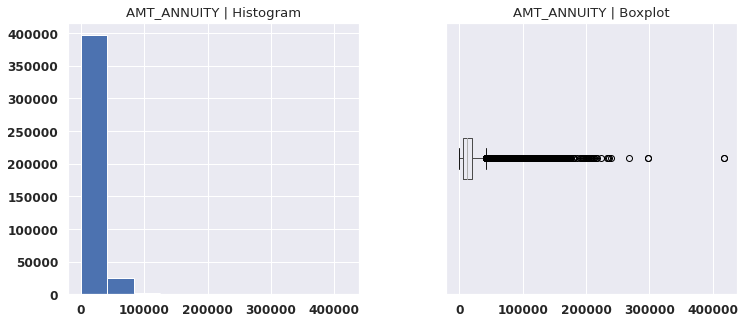

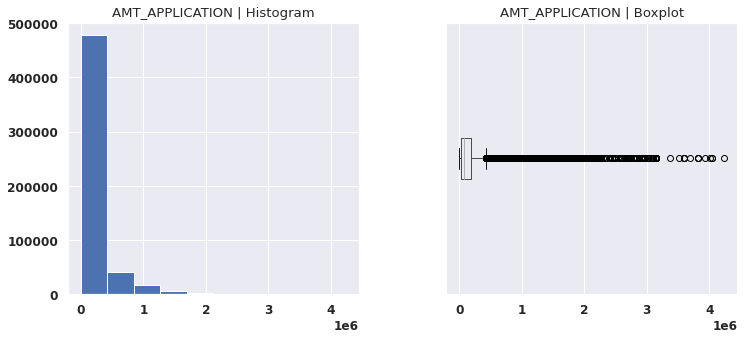

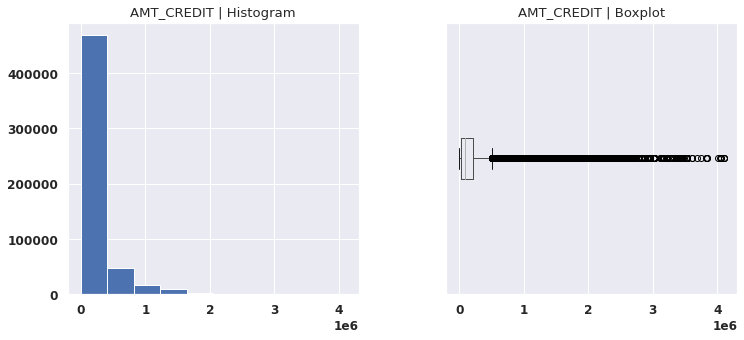

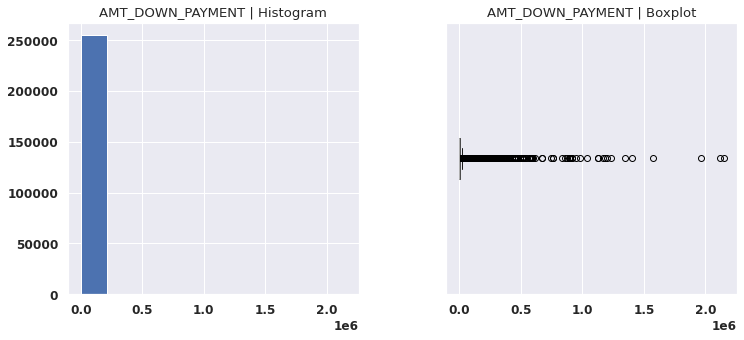

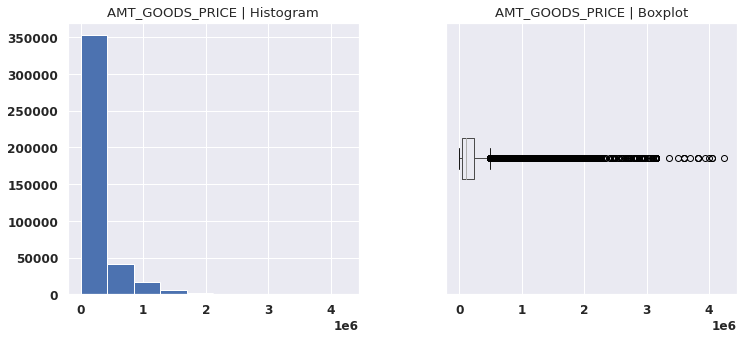

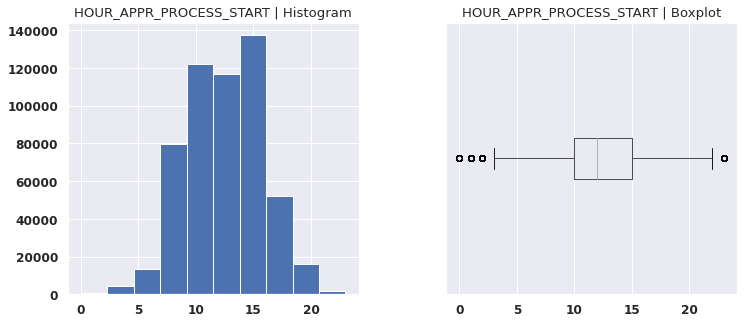

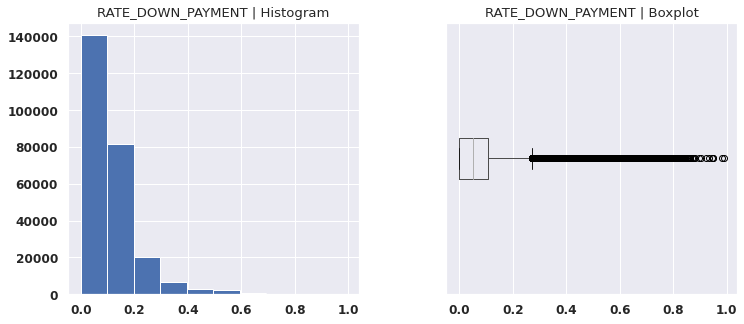

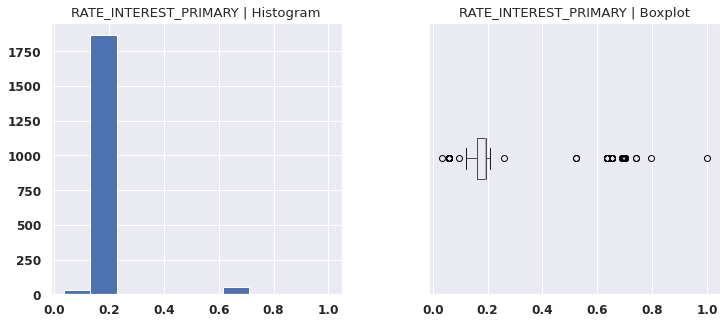

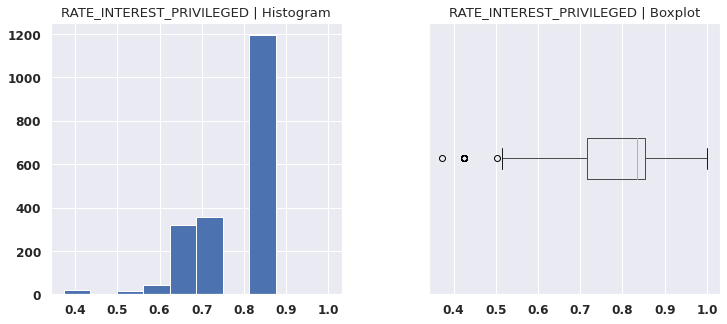

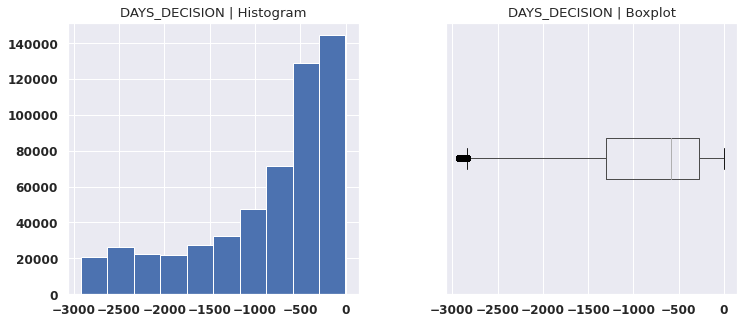

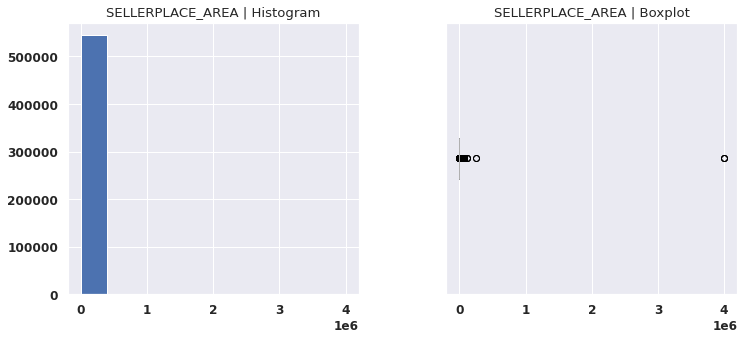

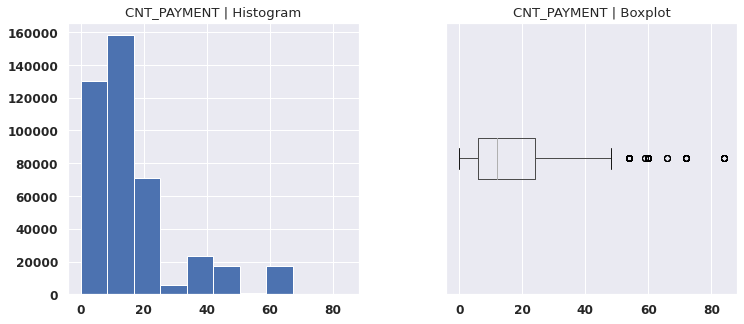

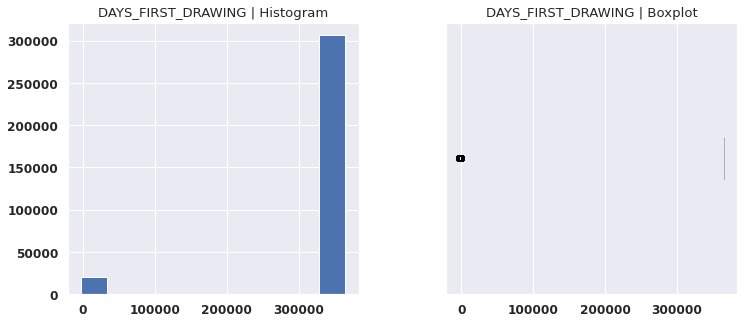

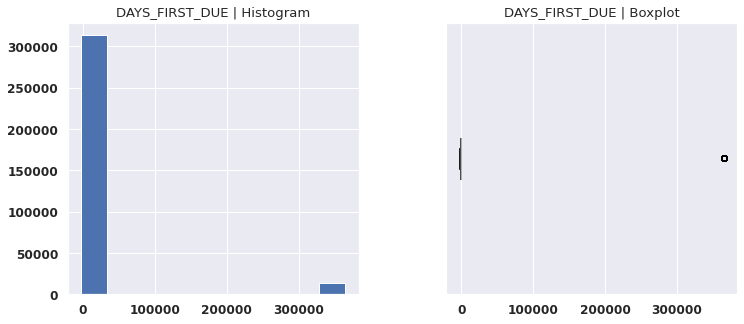

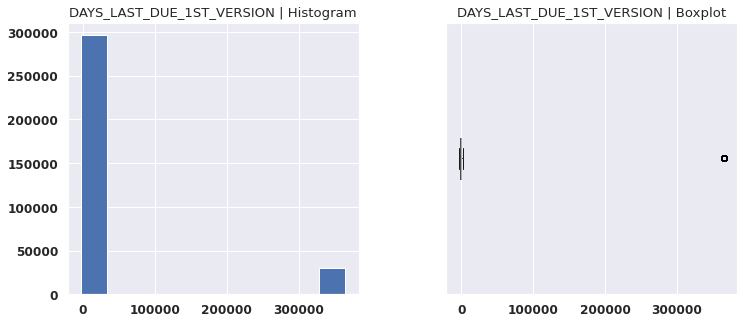

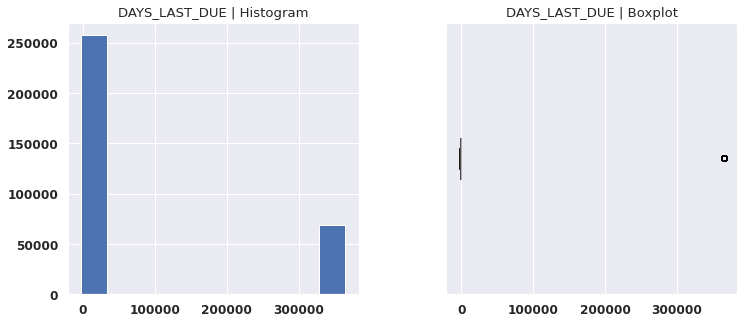

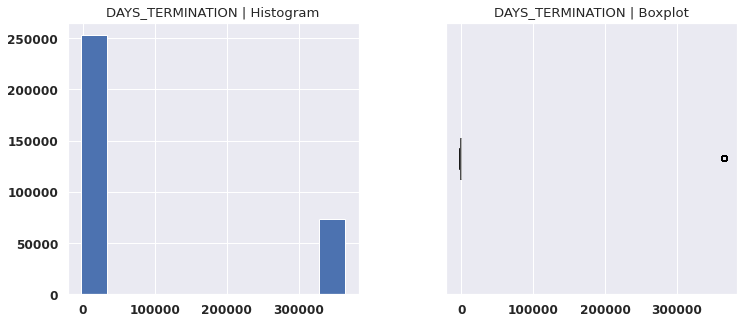

In [157]:
# Dessiner les plots pour les variables numeriques
num_plot(df_previous_application, num_cols=num_cols, remove=[
    'SK_ID_CURR','SK_ID_PREV'], figsize = (12,5))

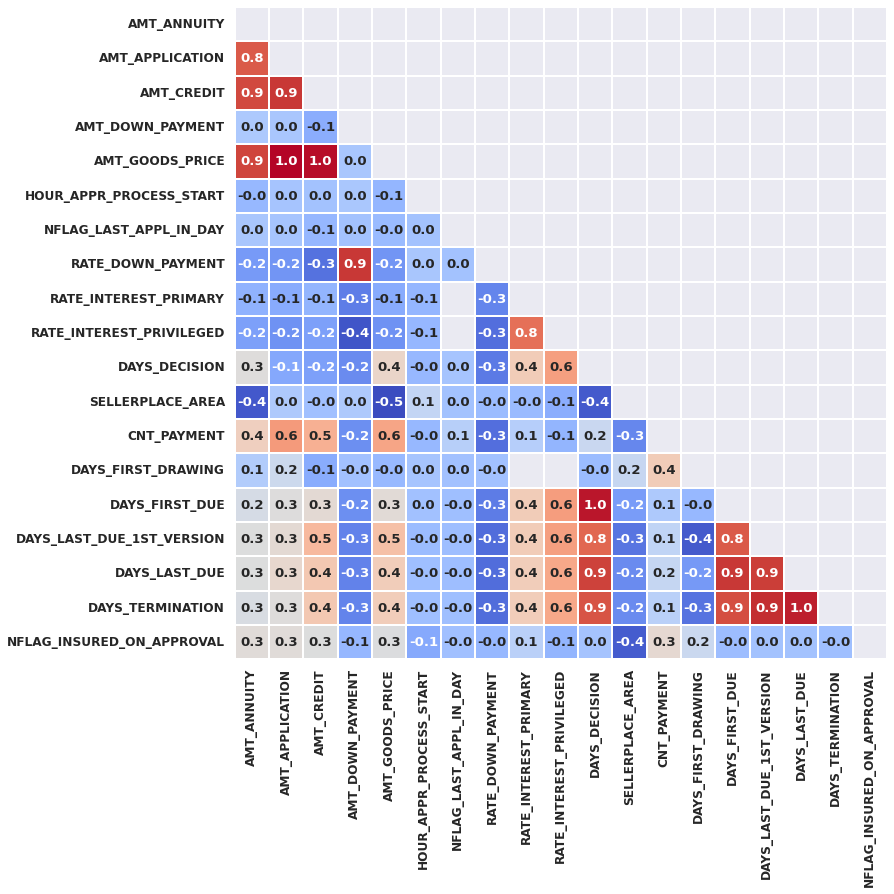

In [158]:
# Analyser la Correlation entre les variables numeriques
corr_plot(df_previous_application, remove=['SK_ID_CURR','SK_ID_PREV'],
    corr_coef = "spearman", figsize = (12,12))

In [159]:
# Detecter et lister les variables a correlation elevee
high_correlation(df_previous_application, remove=[
    'SK_ID_CURR','SK_ID_PREV'], corr_coef = "spearman", corr_value = 0.7)

AMT_ANNUITY
-------------------------------
AMT_GOODS_PRICE    0.888857
AMT_CREDIT         0.879727
AMT_APPLICATION    0.830788
Name: AMT_ANNUITY, dtype: float64


AMT_APPLICATION
-------------------------------
AMT_GOODS_PRICE    0.999888
AMT_CREDIT         0.918075
AMT_ANNUITY        0.830788
Name: AMT_APPLICATION, dtype: float64


AMT_CREDIT
-------------------------------
AMT_GOODS_PRICE    0.984796
AMT_APPLICATION    0.918075
AMT_ANNUITY        0.879727
Name: AMT_CREDIT, dtype: float64


AMT_DOWN_PAYMENT
-------------------------------
RATE_DOWN_PAYMENT    0.918156
Name: AMT_DOWN_PAYMENT, dtype: float64


AMT_GOODS_PRICE
-------------------------------
AMT_APPLICATION    0.999888
AMT_CREDIT         0.984796
AMT_ANNUITY        0.888857
Name: AMT_GOODS_PRICE, dtype: float64


RATE_DOWN_PAYMENT
-------------------------------
AMT_DOWN_PAYMENT    0.918156
Name: RATE_DOWN_PAYMENT, dtype: float64


RATE_INTEREST_PRIMARY
-------------------------------
RATE_INTEREST_PRIVILEGED    0.76808

In [160]:
# Combinaison de categories avec la fonction 'rare_encoder'
rare_cols_list = [
    'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'CHANNEL_TYPE',
    'NAME_GOODS_CATEGORY', 'NAME_SELLER_INDUSTRY', 'NAME_TYPE_SUITE']

for col in rare_cols_list:
    rare_encoder(df_previous_application, col, rare_perc = 0.01)

In [161]:
rare_encoder(df_previous_application, 'NAME_PORTFOLIO', rare_perc = 0.1) 

In [162]:
# Combinaison & standardisation de categories
df_previous_application['NAME_CASH_LOAN_PURPOSE'] = np.where(
    ~df_previous_application['NAME_CASH_LOAN_PURPOSE'].isin(
        ['XAP', 'XNA']), 'Other', df_previous_application[
            'NAME_CASH_LOAN_PURPOSE'])

df_previous_application['PRODUCT_COMBINATION_CATS'] = np.where(
    df_previous_application[
        'PRODUCT_COMBINATION'].str.contains('Cash'), 'CASH', 'POS')

df_previous_application['PRODUCT_COMBINATION_CATS'] = np.where(
    df_previous_application['PRODUCT_COMBINATION'].str.contains('Card'), 'CARD',
        df_previous_application["PRODUCT_COMBINATION_CATS"])

In [163]:
# New categorical variables
df_previous_application['PRODUCT_COMBINATION_POS_WITH'] = np.where(
    (df_previous_application['PRODUCT_COMBINATION'].str.contains('POS') & (
        df_previous_application['PRODUCT_COMBINATION'].str.contains(
            'without'))), 'WITHOUT', 'OTHER')

df_previous_application["PRODUCT_COMBINATION_POS_WITH"] = np.where(
    (df_previous_application["PRODUCT_COMBINATION"].str.contains("POS") & (
        df_previous_application["PRODUCT_COMBINATION"].str.contains(
            "with interest"))), "WITH",
                df_previous_application["PRODUCT_COMBINATION_POS_WITH"])

df_previous_application["PRODUCT_COMBINATION_POS_TYPE"] = np.where(
    (df_previous_application["PRODUCT_COMBINATION"].str.contains("POS") & (
        df_previous_application["PRODUCT_COMBINATION"].str.contains(
            "household"))), "household", "OTHER")

df_previous_application["PRODUCT_COMBINATION_POS_TYPE"] = np.where(
    (df_previous_application["PRODUCT_COMBINATION"].str.contains("POS") & (
        df_previous_application["PRODUCT_COMBINATION"].str.contains(
            "industry"))), "industry", df_previous_application[
                "PRODUCT_COMBINATION_POS_TYPE"])

df_previous_application["PRODUCT_COMBINATION_POS_TYPE"] = np.where(
    (df_previous_application["PRODUCT_COMBINATION"].str.contains("POS") & (
        df_previous_application["PRODUCT_COMBINATION"].str.contains(
            "mobile"))), "mobile", df_previous_application[
                "PRODUCT_COMBINATION_POS_TYPE"])

df_previous_application["PRODUCT_COMBINATION_POS_TYPE"] = np.where(
    (df_previous_application["PRODUCT_COMBINATION"].str.contains("POS") & (
        df_previous_application["PRODUCT_COMBINATION"].str.contains(
            "other"))), "posother", df_previous_application[
                "PRODUCT_COMBINATION_POS_TYPE"])

df_previous_application["PRODUCT_COMBINATION_CASH_TYPE"] = np.where(
    (df_previous_application["PRODUCT_COMBINATION"].str.contains("Cash") & (
        df_previous_application["PRODUCT_COMBINATION"].str.contains(
            "X-Sell"))), "xsell", "OTHER")

df_previous_application["PRODUCT_COMBINATION_CASH_TYPE"] = np.where(
    (df_previous_application["PRODUCT_COMBINATION"].str.contains("Cash") & (
        df_previous_application["PRODUCT_COMBINATION"].str.contains(
            "Street"))), "street", df_previous_application[
                "PRODUCT_COMBINATION_CASH_TYPE"])

In [164]:
# Eliminer variables non pertinantes
df_previous_application.drop(["WEEKDAY_APPR_PROCESS_START", 
    "FLAG_LAST_APPL_PER_CONTRACT", "NFLAG_LAST_APPL_IN_DAY",
        "NFLAG_LAST_APPL_IN_DAY"], axis = 1, inplace = True)

In [165]:
# Encoder les variables categorielles avec 'one_hot_encoder' 
df_previous_application, get_dummies_previous_app = get_dummies_encoder(
    df_previous_application, nan_as_category=True)

In [166]:
# Remplacer 'Days '365243' par 'nan'. 365243 indique inconnue
df_previous_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
df_previous_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
df_previous_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
df_previous_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
df_previous_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

In [167]:
# Ajouter nouveau feature: ratio montant demande / montant accepte
df_previous_application['APP_CREDIT_PERC'] = df_previous_application[
    'AMT_APPLICATION'] / df_previous_application['AMT_CREDIT']

In [168]:
# Agreagations - Variables numeriques
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean', "median", "std"],
    'AMT_APPLICATION': ['min', 'max', 'mean', "median", "std"],
    'AMT_CREDIT': ['min', 'max', 'mean', "median", "std"],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', "median", "std"],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', "median", "std"],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean', "median", "std"],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean', "median", "std"],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean', "std"],
    'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean', "std"],
    'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean', "std"],
    'DAYS_DECISION': ['min', 'max', 'mean', "median", "std"],
    'CNT_PAYMENT': ['mean', 'sum', "median", "std"],
    'SELLERPLACE_AREA': ['min', 'max', 'mean', "median", "std"],
    'DAYS_FIRST_DRAWING': ['min', 'max', 'mean', "median", "std"],
    'DAYS_FIRST_DUE': ['min', 'max', 'mean', "median", "std"],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean', "median", "std"],
    'DAYS_LAST_DUE': ['min', 'max', 'mean', "median", "std"],
    'DAYS_TERMINATION': ['min', 'max', 'mean', "median", "std"],
    # Cette variable est en fait categorielle 
    "NFLAG_INSURED_ON_APPROVAL": ["mean"]
}
# Agreagations - Variables categorielles
cat_aggregations = {}
for cat in get_dummies_previous_app:
    cat_aggregations[cat] = ['mean']

# Agreagations
df_previous_application_agg = df_previous_application.groupby(
    'SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})

df_previous_application_agg.columns = pd.Index(
    ['PREV_' + e[0] + "_" + e[1].upper() 
        for e in df_previous_application_agg.columns.tolist()])

In [169]:
# Agregation sur 'Approved Applications' seulement
approved = df_previous_application[df_previous_application[
    'NAME_CONTRACT_STATUS_Approved'] == 1]

approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)

approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() 
    for e in approved_agg.columns.tolist()])

df_previous_application_agg = pd.merge(
    df_previous_application_agg,approved_agg, how='left', on='SK_ID_CURR')

In [170]:
# Agregation sur 'Refused Applications' seulement
refused = df_previous_application[df_previous_application[
    'NAME_CONTRACT_STATUS_Refused'] == 1]

refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)

refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper()
    for e in refused_agg.columns.tolist()])

df_previous_application_agg = pd.merge(
    df_previous_application_agg, refused_agg, how='left', on='SK_ID_CURR')

In [171]:
# #####################################################
df_previous_application_agg.reset_index(inplace = True)
# #####################################################

In [172]:
print('Shape du fichier \'previous_application\' :',
    df_previous_application_agg.shape, '\n')
df_previous_application_agg.head()

Shape du fichier 'previous_application' : (242942, 378) 



SK_ID_CURR  ...  REFUSED_NFLAG_INSURED_ON_APPROVAL_MEAN
0      100001  ...                                     NaN
1      100006  ...                                     NaN
2      100007  ...                                     NaN
3      100008  ...                                     NaN
4      100009  ...                                     NaN

[5 rows x 378 columns]

In [173]:
# 'Feather' format binaire: Plus rapide pour transferer entre systemes
# Ecrire le fichier au format 'Feather' sur disque
df_previous_application_agg.to_feather('drive/MyDrive/P7-Project/previous_application_agg_feather')
# pd.read_feather('credit_card_balance_agg_feather')
print('Shape du fichier \'df_previous_application_agg\' apres EAD: ',
    df_previous_application_agg.shape, "\n")

Shape du fichier 'df_previous_application_agg' apres EAD:  (242942, 378) 



In [174]:
# Nettoyer la RAM
del df_previous_application_agg

Note:  Fichiers traites:
***df_bbb_merge_agg_1***: Fusion des fichiers:  
- df_bureau_balance_sample: Fichier bureau_balances
- df_bureau_sample: Fichier bureau  

***df_POS_CASH_Balance_agg***: Fichier POS_CASH_Balance  
***df_credit_card_balance_agg***: Fichier credit_card_balance  
***df_installments_payments_agg***: Fichier installments_payments  
***df_previous_application_agg***: Fichier previous_application  


### Fusion des datasets separes en un seul dataset final

In [175]:
# Lire les fichiers sauvegardes en format binaire feather'application_train'
df_application = pd.read_feather("drive/MyDrive/P7-Project/applicationfeather")
df_bbb = pd.read_feather("drive/MyDrive/P7-Project/bureau_bureaubalance_agg_feather")
df_pos = pd.read_feather("drive/MyDrive/P7-Project/poscashbalance_agg_feather")
df_credit_card = pd.read_feather("drive/MyDrive/P7-Project/creditcardbalance_agg_feather")
df_prev_app = pd.read_feather("drive/MyDrive/P7-Project/previous_application_agg_feather")
df_ins_pay = pd.read_feather("drive/MyDrive/P7-Project/installments_payments_agg_feather")

# Collecter des informations générales sur les données lues
liste_df = {'df_application': df_application,
            'df_bbb': df_bbb,
            'df_pos': df_pos,
            'df_credit_card': df_credit_card,
            'df_prev_app': df_prev_app,
            'df_ins_pay': df_ins_pay}
info_sur_df(liste_df, 'Informations sur dataframes')

+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                              Informations sur dataframes                                                              |
+----------------+--------+----------+--------------------------------------------------------+---------------------------------------------------------+
|      Nom       | Lignes | Colonnes |                         Nan %                          |                          dtypes                         |
+----------------+--------+----------+--------------------------------------------------------+---------------------------------------------------------+
| df_application | 295338 |    95    |      index                                   0.0       |      index                                    int64     |
|                |        |          |      SK_ID_CURR                      

In [176]:
# Prevoir n_rows et n_cols du fichier resultat
rows_df_application = df_application.shape[0]
cols_df_application = df_application.shape[1]

rows_df_pos = df_pos.shape[0]
cols_df_pos = df_pos.shape[1]

rows_df_bbb = df_bbb.shape[0]
cols_df_bbb = df_bbb.shape[1]

rows_df_credit_card = df_credit_card.shape[0]
cols_df_credit_card = df_credit_card.shape[1]

rows_df_ins_pay = df_ins_pay.shape[0]
cols_df_ins_pay = df_ins_pay.shape[1]

rows_df_prev_app = df_prev_app.shape[0]
cols_df_prev_app = df_prev_app.shape[1]

# Apres la fusion des fichiers deux a deux
rows_df = rows_df_application
cols_df = cols_df_application + cols_df_pos - 1
cols_df = cols_df + cols_df_bbb - 1
cols_df = cols_df + cols_df_credit_card - 1
cols_df = cols_df + cols_df_ins_pay - 1
cols_df = cols_df + cols_df_prev_app - 1

print('Nombre de lignes fichier final: {}'. format(rows_df))
print('Nombre de colonnes fichier final: {}'. format(cols_df))


Nombre de lignes fichier final: 295338
Nombre de colonnes fichier final: 1111


In [177]:
# Fusionner les fichiers 
for table in [df_prev_app, df_ins_pay, df_pos, df_credit_card, df_bbb]:
    df_application = pd.merge(df_application, table , how = "left", on = "SK_ID_CURR")
    
print('df_application.shape : ', df_application.shape)

df_application.shape :  (295338, 1111)


In [178]:
# Nettoyer la RAM
del df_bbb, df_pos, df_credit_card, df_prev_app, df_ins_pay

In [179]:
# Standardiser les noms de colonnes
df_application.columns = list(map(lambda x: str(x).replace(" ", "_").replace(
#    "-", "_").replace("_/_", "_").upper(), df_application.columns))
    "-", "_").replace("_/_", "_"), df_application.columns))

import re # Regular expression module
df_application = df_application.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [180]:
# 'Feather' format binaire: Plus rapide pour transferer entre systemes
# Ecrire le fichier au format 'Feather' sur disque
df_application.to_feather('drive/MyDrive/P7-Project/applicationfinalfeather')
# pd.read_feather('applicationfinalfeather')
print('Shape du fichier \'df_application Final\' apres EAD: ',
    df_application.shape, "\n")

Shape du fichier 'df_application Final' apres EAD:  (295338, 1111) 



In [183]:
# Voici les sets de variables crees par get_dummies encoder
# get_dummies_lit_application
# get_dummies_burea_balance
# get_dummies_bbb
# get_dummies_pos_cash
# get_dummies_card_balance
# get_dummies_previous_app
encoded_columns = get_dummies_lit_application + get_dummies_burea_balance + \
    get_dummies_bbb + get_dummies_pos_cash + get_dummies_card_balance + \
    get_dummies_previous_app
# Afficher 'encoded_columns' pour voir les colonnes crees par encoding
encoded_columns

['NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Rare',
 'NAME_TYPE_SUITE_Spouse, partner',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_Rare',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_FAMILY_STATUS_Civil marriage',
 'NAME_FAMILY_STATUS_Married',
 'NAME_FAMILY_STATUS_Separated',
 'NAME_FAMILY_STATUS_Single / not married',
 'NAME_FAMILY_STATUS_Widow',
 'OCCUPATION_TYPE_Accountants',
 'OCCUPATION_TYPE_Core staff',
 'OCCUPATION_TYPE_Drivers',
 'OCCUPATION_TYPE_HR staff',
 'OCCUPATION_TYPE_High skill tech staff',
 'OCCUPATION_TYPE_Laborers',
 'OCCUPATION_TYPE_Low-skill Laborers',
 'OCCUPATION_TYPE_Managers',
 'OCCUPATION_TYPE_Medicine staff',
 'OCCUPATION_TYPE_Realty agents',
 'OCCU

##II. Part-2: Modelisation

Rappel: Objectif du projet

A partir des donnees de l'application pour pret et des informations historiques dans les fichiers joints, predire le client est apte a honoirer ses engagements pour le pret demande ou non.

Target: 1 - Indique que le client a des difficultes de paiement: i.e. retard de payer > X jours sur au moins les Y premiers versements.  
Target: 0 - Tout autre cas

Features: Application features, previous application features, bureau features, installment features, credit balance features, and POS cash balance features.


###Lire & Prerparer le dataset pour classification




In [184]:
# Lecture du fichier Feather final
df_application = pd.read_feather(
    'drive/MyDrive/P7-Project/applicationfinalfeather')

# Collecter des informations générales sur les données lues
liste_df = {'df_application': df_application}
info_sur_df(liste_df, 'Informations sur dataframes')

+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                              Informations sur dataframes                                                              |
+----------------+--------+----------+--------------------------------------------------------+---------------------------------------------------------+
|      Nom       | Lignes | Colonnes |                         Nan %                          |                          dtypes                         |
+----------------+--------+----------+--------------------------------------------------------+---------------------------------------------------------+
| df_application | 295338 |   1111   | index                                             0.00 | index                                             int64 |
|                |        |          | SK_ID_CURR                           

In [185]:
df_application.drop(['index'], axis=1, inplace=True)

In [186]:
# Detecter et affichier informations sur missing values
missing_values(df_application, plot = False)

Number of Variables include Missing Values: 1017 

Full Missing Variables: ['REFUSED_DAYS_TERMINATION_MAX', 'REFUSED_DAYS_FIRST_DRAWING_MIN', 'REFUSED_DAYS_FIRST_DUE_MIN', 'REFUSED_DAYS_FIRST_DRAWING_STD', 'REFUSED_RATE_INTEREST_PRIMARY_MEAN', 'REFUSED_DAYS_FIRST_DRAWING_MEDIAN', 'REFUSED_DAYS_FIRST_DRAWING_MEAN', 'REFUSED_DAYS_FIRST_DRAWING_MAX', 'REFUSED_DAYS_TERMINATION_MEDIAN', 'REFUSED_RATE_INTEREST_PRIVILEGED_MAX', 'REFUSED_RATE_INTEREST_PRIMARY_STD', 'REFUSED_DAYS_TERMINATION_STD', 'REFUSED_NFLAG_INSURED_ON_APPROVAL_MEAN', 'REFUSED_DAYS_TERMINATION_MEAN', 'REFUSED_RATE_INTEREST_PRIVILEGED_STD', 'REFUSED_RATE_INTEREST_PRIVILEGED_MEAN', 'REFUSED_DAYS_FIRST_DUE_MAX', 'REFUSED_DAYS_FIRST_DUE_MEAN', 'REFUSED_DAYS_FIRST_DUE_MEDIAN', 'REFUSED_RATE_INTEREST_PRIMARY_MAX', 'REFUSED_DAYS_FIRST_DUE_STD', 'REFUSED_DAYS_LAST_DUE_1ST_VERSION_MIN', 'REFUSED_DAYS_LAST_DUE_1ST_VERSION_MAX', 'REFUSED_DAYS_LAST_DUE_1ST_VERSION_MEAN', 'REFUSED_DAYS_LAST_DUE_1ST_VERSION_MEDIAN', 'REFUSED_RATE_INTERES

In [187]:
# Afficher le statut des colonnes en termes de taux de remplissage / missing values
df_nans = taux_remplissage(df_application)

Taux de remplissage global: 44.230%


In [188]:
# Eliminer toutes les variables ayant un taux de remplissage < 60%
for col in df_nans.columns:
    if (df_nans.loc['% of Total observations', col] > 40):
        df_application.drop([col], axis=1, inplace=True)
df_nans = taux_remplissage(df_application)
df_nans

Taux de remplissage global: 77.021%


CLOSED_AMT_CREDIT_SUM_DEBT_MEDIAN  ...  SK_ID_CURR
Missing Values                               117129.000000  ...         0.0
% of Total observations                          39.659306  ...         0.0

[2 rows x 394 columns]

In [189]:
# Imputer les valeures non-remplies restantes par les medianes sauf TARGET
df_application.fillna(df_application.drop(['TARGET'], axis=1).median(),
                      inplace=True)
taux_remplissage(df_application)

Taux de remplissage global: 99.958%


TARGET  ...  SK_ID_CURR
Missing Values           48744.00000  ...         0.0
% of Total observations     16.50448  ...         0.0

[2 rows x 394 columns]

In [190]:
# Detecter et eliminer les variables constantes i.e. toutes les valeures 0 ou 1
col_0 = df_application.columns[df_application.isin([0]).all()]
for col in col_0:
    df_application.drop([col], axis=1, inplace=True)
df_application.shape

(295338, 379)

In [191]:
# Detecter let eliminer les variables constantes i.e. toutes les valeures 0 ou 1
col_1 = df_application.columns[df_application.isin([1]).all()]
for col in col_1:
    df_application.drop([col], axis=1, inplace=True)
df_application.shape

(295338, 379)

In [192]:
# Sauvegrader le fichier df_application final apres nettoyage
df_application.to_feather('drive/MyDrive/P7-Project/applicationcleanfeather')
# pd.read_feather('drive/MyDrive/P7-Project/applicationcleanfeather')


### Test des Modeles 

#### Lecture et preparation des donnees

In [193]:
# Lire fichier clean & selectionner observations pour entrainement
df_application = pd.read_feather(
    'drive/MyDrive/P7-Project/applicationcleanfeather')

df_train = df_application[df_application.TARGET.isnull() == False]
df_test = df_application[df_application.TARGET.isnull()]
# df_train contient les observation ayant un TARGET renseigne
# df_test contient les observation ayant un TARGET NON renseigne
# df_train sera utilise pour l'entrainement de nos modeles

In [194]:
# Collecter des informations générales sur les données lues
liste_df = {'df_test': df_test,
            'df_train': df_train}
info_sur_df(liste_df, 'Informations sur dataframes')

+--------------------------------------------------------------------------------------------------------------------------------+
|                                                  Informations sur dataframes                                                   |
+----------+--------+----------+-----------------------------------------------+-------------------------------------------------+
|   Nom    | Lignes | Colonnes |                     Nan %                     |                      dtypes                     |
+----------+--------+----------+-----------------------------------------------+-------------------------------------------------+
| df_test  | 48744  |   379    | SK_ID_CURR                                0.0 | SK_ID_CURR                                int64 |
|          |        |          | TARGET                                  100.0 | TARGET                                  float64 |
|          |        |          | NAME_CONTRACT_TYPE                        0.0 | NA

In [195]:
# Initialiser les structures & standardiser les donnees lues
predictors = [f for f in df_train.columns if f not in ['SK_ID_CURR', 'TARGET']]
target = 'TARGET'

train = df_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
test = df_test.drop(['SK_ID_CURR', 'TARGET'], axis=1)


In [196]:
# Isoler les variables binaires pour standardisation
col_binary = train.columns[train.isin([0,1]).all()]
train_non_binary = train.drop(col_binary, axis=1)
train_binary = train[col_binary]


#### Standardser & split des donnees

In [197]:
# Standardisation des donnees non binaires sur X_train
sc = StandardScaler()

sc.fit(train_non_binary)
train_non_binary = pd.DataFrame(sc.transform(train_non_binary),
                         columns=train_non_binary.columns)
train_std = pd.concat([train_binary, train_non_binary], axis=1)


In [198]:
# Reintegrer 'SK_ID_CURR', 'TARGET' dans les dataframes standardises
train_std.insert(0, 'SK_ID_CURR', df_train['SK_ID_CURR'])
train_std.insert(1, 'TARGET', df_train['TARGET'])


Spliter les donnees en Train / Test datastes

In [199]:
# Split du fichier d'entrainement en 2 sets: train et test
X_train, X_test, y_train, y_test = train_test_split(train_std,
    df_train['TARGET'], test_size=0.3, random_state=123)
print('Taille des fichiers train X, y :', X_train.shape, y_train.shape)
print('Taille des fichiers test X, y :', X_test.shape, y_test.shape)

Taille des fichiers train X, y : (172615, 379) (172615,)
Taille des fichiers test X, y : (73979, 379) (73979,)


In [200]:
X_train

SK_ID_CURR  ...  CLOSED_MONTHS_BALANCE_CLOSED_DIF_SUM
156832      281783  ...                             -0.205865
228973      365224  ...                             -0.205865
190813      321262  ...                             -0.205865
133580      254933  ...                             -0.205865
74742       186680  ...                             -0.205865
...            ...  ...                                   ...
119906      239046  ...                             -0.205865
192476      323204  ...                             -0.205865
17730       120670  ...                             -0.205865
28030       132582  ...                             -0.205865
15725       118348  ...                             -0.205865

[172615 rows x 379 columns]

In [201]:
print('\nNombre des classes dans y_train: \n{}'.format(y_train.value_counts()))
# pourcentage de 1 dans y_train
print('Pourcentage 1 dans dataset: {}'.format((y_train == 1.).sum() / y_train.shape[0] *100))
print('\nNombre des classes dans y_test: \n{}'.format(y_test.value_counts()))
# pourcentage de 1 dans y_test
print('Rapport 1 dans dataset: {}'.format((y_test == 1.).sum() / y_test.shape[0] *100))


Nombre des classes dans y_train: 
0.0    158640
1.0     13975
Name: TARGET, dtype: int64
Pourcentage 1 dans dataset: 8.096051907424036

Nombre des classes dans y_test: 
0.0    67961
1.0     6018
Name: TARGET, dtype: int64
Rapport 1 dans dataset: 8.134740939996485


***X_train, X_test, y_train, y_test sont les données divisées (split) & STANDARDISES *** 
- df_train['TARGET'] contient les labels
- df_train(['SK_ID_CURR'] contient le id des clients

In [202]:
# Travailler sur un echantillon, juste pour test ........
# ##################################
X_train = X_train.sample(frac=0.15, random_state=123)
index_1 = X_train.index
y_train = y_train.loc[index_1]

X_test = X_test.sample(frac=0.15, random_state=123)
index_2 = X_test.index
y_test = y_test.loc[index_2]

In [203]:
# Prendre une copie des données à traiter pour y revenir si necessaire
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
X_test_copy = X_test.copy()
y_test_copy = y_test.copy()

In [204]:
# Isoler les colonnes 'SK_ID_CURR' & 'TARGET'
X_train = X_train_copy.drop(['SK_ID_CURR', 'TARGET'], axis=1)
X_test =  X_test_copy.drop(['SK_ID_CURR', 'TARGET'], axis=1)

#### ***Evaluation des Modeles de Classification selectionnés***
Nous avons séléctionné trois modèles de classification pour tester:
- XGBoostClassifier
- RandomForestClassifier, et
- LogisticRegression Classifier  
On va procèder a une évaluation et une comparaison pour choisir le meilleure modèle a adopter.  
Le process de selection sera base sur:
- L'inclusion du DummyClassifier comme référence de base
- Les modeles sont comparés avec leur hyperparametres par défault. Le modele selectionné sera tuné pour ses meilleures hyperparametres.
- Les crietres de mesure de performance suivants:  
    - Accuracy: Critere générale de performance
    - F_beta: Critere spécifique configuré suivant les besoins du métier. Voir en bas ***Fonction coût métier***.
    - Roc auc: Critere spécifique de performance 


***La fonction coût est déterminée par l'analyse des erreurs de prédiction***


---



**FP (False Positive) :** les cas où la prédiction est positive (1), mais où la valeur réelle est négative (0). 

_Dans ce cas, il s'agit d'une perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé._


**FN (False Negative) :** les cas où la prédiction est négative (0), mais où la valeur réelle est positive (1). 

_Dans ce cas, il s'agit de perte réelle si le crédit client accepté se transforme en défaut de paiement._

**Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.**  

Une analyse métier plus detaillée nous permet d'estimer les couts correspondants aux FN et FP, et de décider de la relation entre ces deux mesures.   
Nous allons supposer que cette relation est de 3:1 (FN:FP), et donc introduire le ***score F_beta = 3*** dans nos calcul de test et comparaison des modeles.
**Cette métrique métier permet la quantification de l'importance relative entre recall et précision, à savoir Beta (β) dans la formule:**  

Fonction qui optimise Precision et Recall avec une importance plus forte pour le critère Precision:

\begin{aligned}{\text{F_Beta score}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,\end{aligned}

 

\begin{aligned}{\text{Precision}}&={\frac {tp}{tp+fp}}\\{\text{Recall}}&={\frac {tp}{tp+fn}}\,\end{aligned}


_Explication sur la F-measure [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)_



In [206]:
# Procédure générale d'évaluation des  modèles
start_time = time.time()
dfs = [] # contient les données resultats des folds cross validation
models = [
          ('Dummy', DummyClassifier()),
          ('XGB', XGBClassifier()),
          ('RF', RandomForestClassifier()),
          ('LOG', LogisticRegression())
#          ('SVM', SVC())
        ]
results = []
names = []
scoring = {'accuracy': 'accuracy',
           'precision_weighted': 'precision_weighted',
           'recall_weighted': 'recall_weighted',
           'f1_weighted': 'f1_weighted',
           'roc_auc': 'roc_auc',
           'fbeta': make_scorer(fbeta_score, average='weighted', beta=3)
#            'log_loss': make_scorer(log_loss)
           }
# ##########################################################
target_names = ['conform-0', 'non-conform-1']

for name, model in models:
    start_time_model = time.time()
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    cv_results = cross_validate(model, X_train, y_train,
        cv=kfold, scoring=scoring)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('\nMatrice de confusion : {}'.format(name))
    print(classification_report(y_test, y_pred, target_names=target_names))
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    end_time = time.time()
    print('{} evaluation_time: {}'.format(name, (end_time - start_time_model), '\n'))

final = pd.concat(dfs, ignore_index=True)
end_time = time.time()
print('\nTotal evaluation_time: {}'.format(end_time - start_time))


Matrice de confusion : Dummy
               precision    recall  f1-score   support

    conform-0       0.92      1.00      0.96     10193
non-conform-1       0.00      0.00      0.00       904

     accuracy                           0.92     11097
    macro avg       0.46      0.50      0.48     11097
 weighted avg       0.84      0.92      0.88     11097

Dummy evaluation_time: 0.3089756965637207

Matrice de confusion : XGB
               precision    recall  f1-score   support

    conform-0       0.92      1.00      0.96     10193
non-conform-1       0.44      0.01      0.02       904

     accuracy                           0.92     11097
    macro avg       0.68      0.50      0.49     11097
 weighted avg       0.88      0.92      0.88     11097

XGB evaluation_time: 128.00876331329346

Matrice de confusion : RF
               precision    recall  f1-score   support

    conform-0       0.92      1.00      0.96     10193
non-conform-1       0.67      0.00      0.00       904



Pour avoir une meilleure distribution des mesures pour chaque modèle, on a procedé a une 'bootstrapping' de 30 échantillons pris dans les résultats de cross-validation pour chaque modèle.
ce qui fait 4*30 = 120 échantillons pour 7 metrics chacune.


In [207]:
# Collecter & structurer les resultats des mesures de performance des modeles
bootstraps = []
# Creer une table de 30 echantillons pour chaque modele
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)

# stocker le tout dans dataframe        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics',
                       value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics

# Selectionner les metriques - PERFORMANCE
results_long_nofit = results_long.loc[~results_long['metrics'].isin(
    time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

# Selectionner les metriques - TEMPS
results_long_fit = results_long.loc[results_long['metrics'].isin(
    time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')


In [208]:
# # On peut voir le contenu des structures ainsi faites
# final.model.values
# final.loc[final.model == 'XGB'].sample(n=30, replace=True)
# bootstrap_df
# results_long

On a maintenant un set de donnees qu'on peut afficher et analyser pour selectionner le modele le plus adequat.  


Text(0.5, 1.0, 'Comparaison des Modeles - Metriques de Classification')

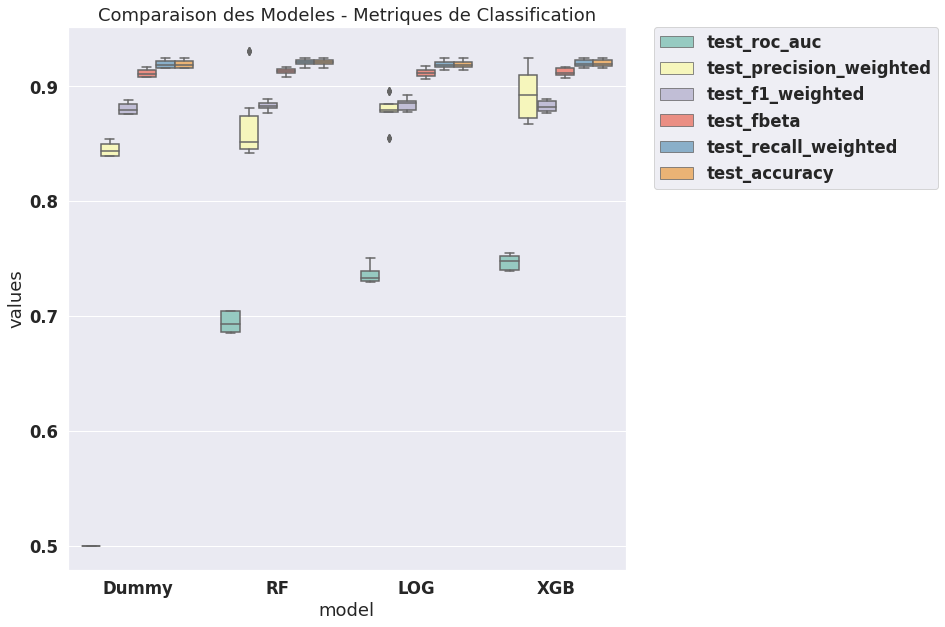

In [209]:
# Afficher sous forme de boxplot les metriques de classification des modeles
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparaison des Modeles - Metriques de Classification')
# plt.savefig('drive/MyDrive/P7-Project/bench_models_performance.png',dpi=300)

On peut voir immediatement que:
- Pour les metricuqes 'accuracy' et 'recall', les 3 modeles sont prarytiquement equivanents avec score > 0.9
- Pour les metrqiues 'precision' et 'f1', les modeles sont proches entre 0.85 et 0.9  avec avantage pour XGB
- Pour le 'roc_auc', l'avantage est clairement pour XGB, suivi par RandomForest ensuite par SVC.


Text(0.5, 1.0, 'Comparaison des Modeles - Metriques de Timing')

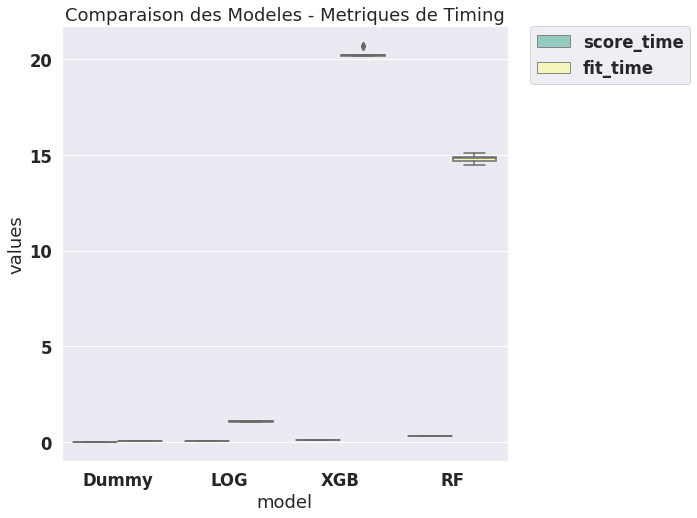

In [210]:
# Afficher sous forme de boxplot les metriques de temps des modeles
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparaison des Modeles - Metriques de Timing')
# plt.savefig('drive/MyDrive/P7-Project/bench_models_timing.png',dpi=300)

On peut voir que SVC est aussi loin des autres modeles en terme de timing.  
En terme de training fit, RF l'emporte sur XGB, mais XGB recupere sur le timing du jeux de test.


Autres infromations existent dans les tables collectees sur les performances des modeles. Comme par exemple:


In [211]:
# Afficher les metriques de classifcation sous forme de table
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_f1_weighted            ... test_precision_weighted          
                   std      mean  ...                     std      mean
model                             ...                                  
Dummy         0.004352  0.880087  ...                0.005494  0.844412
LOG           0.005130  0.884474  ...                0.012772  0.879487
RF            0.004150  0.883050  ...                0.036109  0.867129
XGB           0.004623  0.881815  ...                0.022587  0.891230

[4 rows x 12 columns]

In [212]:
# Afficher les metriques de timing sous forme de table
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

fit_time            score_time          
            std       mean        std      mean
model                                          
Dummy  0.000529   0.038924   0.000371  0.015831
LOG    0.024186   1.082494   0.000789  0.052257
RF     0.218810  14.804700   0.003197  0.319695
XGB    0.187365  20.284209   0.002779  0.111262

CONCLUSION:  
La comparaison a ete faite en se basant sur la 'moyenne' des metriques de precision, recall, f1, roc_auc ... pour analyser et selectionner un modele de calssification pour notre probelem.  
A notre, que le modele selectionne ici , le XGBoost en l'occurence, doit subir un regalge de ses hyper-parametres avant de finaliser le fit des donnees. 

#### Reglage des hyper-parametres du modele XGBoost Classifier

In [213]:
# Initialiser les structures de donnees pour entrainer le modele
predictors = [f for f in X_train.columns if f not in ['SK_ID_CURR']]
target = 'TARGET'

train_xgb = pd.concat([X_train, y_train], axis=1)
test_xgb = X_test

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.



Model Report
Accuracy : 0.9209
AUC Score (Train): 0.820391
F-beta Score (Train): 0.02144
CV Score: Mean - 0.7484367 | Std - 0.01479407 | Min - 0.7283734 | Max - 0.7631615
XGBoost Basic Model - TRAIN fit time (in Sec): 126.10803413391113


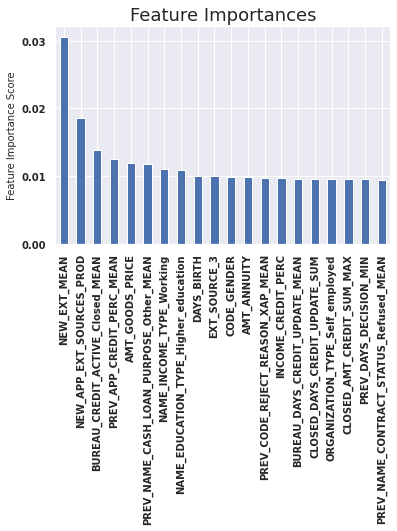

In [214]:
# Entrainer le modele de BASE pour reference
start_time = time.time()

# gbm0 = GradientBoostingClassifier(random_state=123)
gbm0 = XGBClassifier(random_state=123)
modelfit(gbm0, train_xgb, predictors, target)

end_time = time.time()
xgb_fit_time = end_time - start_time
print('XGBoost Basic Model - TRAIN fit time (in Sec): {}'.format(xgb_fit_time))

In [215]:
# Proceder mainteant au reglage (tuning) des hyper-parametres pour entrainer
# un meilleur modele XGBoostCalssifier 

Procedure de tuning des hyper-parametres:

1) Trouver le nombre d'estimateurs 'n_estimaor' avec une valeures precise de 'learning_rate'. Pour cela:   
- On demarra avec une valeur elevee de 'learning rate' comme 0.1 par exemple;
- On uItilise les parametres suivants:
    - min_samples_split = ~0.5-1% est acceptable avec calsses non-balancees
    - min_samples_leaf = 50 : pour eviter overfitting
    - max_depth = 8 : a cause du grand nombre d'observations / variables
    - max_features = 'sqrt' : pour commencer avec ... on traite apres
    - subsample = 0.8 : valeures utilisee en general, ... on traite apres

2)  Regler les 'tree-specific' hyper-parametres.  
- Regler 'max_depth' et 'num_samples_split'
- Regler 'min_samples_leaf'
- Regler 'max_features'

3) Regler 'subsample' et reduire 'Learning Rate'

In [216]:
# Trouver le meilleur 'n_estimators' avec GridSearchCV
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(
    learning_rate=0.1, min_samples_split=2000, min_samples_leaf=50, max_depth=8,
        max_features='sqrt', subsample=0.8,random_state=123),
            param_grid = param_test1, scoring='roc_auc',n_jobs=4,
            cv=5)

start_time = time.time()

gsearch1.fit(train_xgb[predictors], train_xgb[target])

end_time = time.time()
xgb_fit_time = end_time - start_time
print('XGBoost tuning - TRAIN fit time (in Sec): {}'.format(xgb_fit_time))

# print(gsearch1.cv_results_, '\n')
print(gsearch1.best_params_, '\n')
print(gsearch1.best_score_)

XGBoost tuning - TRAIN fit time (in Sec): 50.72337341308594
{'n_estimators': 80} 

0.7460893881710444


n_estmators = 80, comme valeure optimale pour ce parametre parait raisonnable.

SPossibkle autres valeures:
- Autour 20: il faut essayer de reduire la valeur de learning_rate et re-essayer
- Autour 100 ou plus: essayer d'augmenter 'learning_rate' 


In [217]:
# Proceder pour reglage de 'max_depth' et 'min_samples_split'
param_test2 = {'max_depth':range(3,12,2),
#               'min_samples_split':range(100,1001,200),
#               'min_samples_split':range(1000,2001,200)}
               'min_samples_split':range(2500,3301,200)}

start_time = time.time()

gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(
    learning_rate=0.1, n_estimators=80, max_features='sqrt', subsample=0.8,
        random_state=123), param_grid = param_test2, scoring='roc_auc',
            n_jobs=4, cv=5)
gsearch2.fit(train_xgb[predictors],train_xgb[target])

end_time = time.time()
xgb_fit_time = end_time - start_time
print('XGBoost tuning - TRAIN fit time (in Sec): {}'.format(xgb_fit_time))

# print(gsearch2.cv_results_, '\n')
print(gsearch2.best_params_, '\n')
print(gsearch2.best_score_)

XGBoost tuning - TRAIN fit time (in Sec): 210.41697072982788
{'max_depth': 7, 'min_samples_split': 3100} 

0.7484001312377742


Si le maximum de 'min_samples_split' est atteint, on doit re-tester avec des valeures plus grandes.

In [218]:
# Proceder pour reglage de 'min_samples_leaf'
param_test3 = {'min_samples_leaf':range(30,71,10)}

start_time = time.time()

gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(
    learning_rate=0.1, n_estimators=80,max_depth=7, max_features='sqrt',
        min_samples_split=3100, subsample=0.8, random_state=123),
            param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(train_xgb[predictors],train_xgb[target])

end_time = time.time()
xgb_fit_time = end_time - start_time
print('XGBoost tuning - TRAIN fit time (in Sec): {}'.format(xgb_fit_time))

# print(gsearch3.cv_results_, '\n')
print(gsearch3.best_params_, '\n')
print(gsearch3.best_score_)

XGBoost tuning - TRAIN fit time (in Sec): 47.11712598800659
{'min_samples_leaf': 60} 

0.7496035793666975


In [219]:
# Procéder pour réglage de 'max_features'
param_test4 = {# 'max_features':range(7,20,2),
               'max_features':range(19,40,2)}

start_time = time.time()

gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(
    learning_rate=0.1, n_estimators=80,max_depth=7, min_samples_split=3100,
        min_samples_leaf=60, subsample=0.8, random_state=123),
            param_grid = param_test4, scoring='roc_auc', n_jobs=4, cv=5)
gsearch4.fit(train_xgb[predictors],train_xgb[target])

end_time = time.time()
xgb_fit_time = end_time - start_time
print('XGBoost tuning - TRAIN fit time (in Sec): {}'.format(xgb_fit_time))

# print(gsearch4.cv_results_, '\n')
print(gsearch4.best_params_, '\n')
print(gsearch4.best_score_)

XGBoost tuning - TRAIN fit time (in Sec): 130.462486743927
{'max_features': 19} 

0.7496035793666975


In [220]:
# Procéder pour réglage de 'subsample'
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}

start_time = time.time()

gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(
    learning_rate=0.1, n_estimators=80,max_depth=7, min_samples_split=3100,
        min_samples_leaf=60, subsample=0.8, max_features=19, random_state=123),
            param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(train_xgb[predictors],train_xgb[target])

end_time = time.time()
xgb_fit_time = end_time - start_time
print('XGBoost tuning - TRAIN fit time (in Sec): {}'.format(xgb_fit_time))

# print(gsearch5.cv_results_, '\n')
print(gsearch5.best_params_, '\n')
print(gsearch5.best_score_)

XGBoost tuning - TRAIN fit time (in Sec): 53.502960205078125
{'subsample': 0.85} 

0.7497678133061086


Avec les differents hyper-parametres regles, on va essayer de reduire la valeur du parametre 'learning rate' en augmentant en meme temps la valeure de 'n_estimators' pour de meilleures resultats.


In [232]:
def tester_learn_estimators(learn_rate, estimators_n):
    start_time = time.time()
    gbm_tuned_x = GradientBoostingClassifier(learning_rate=learn_rate,
        n_estimators=estimators_n, max_depth=7, min_samples_split=3100, 
        min_samples_leaf=60, subsample=0.85, max_features=19, random_state=123)
    print('\nFor learn_rate = {}, & n_estimators = {}'.format(learn_rate, estimators_n))
    modelfit(gbm_tuned_x, train_xgb, predictors, target,
         printFeatureImportance=False)

    end_time = time.time()
    xgb_fit_time = end_time - start_time
    print('XGBoost tuning - TRAIN fit time (in Sec): {}'.format(xgb_fit_time))


In [233]:
list_tests = [[0.1, 80], [0.05, 120], [0.01, 600], [0.005, 1200], [0.005, 1500],
              [0.001, 2000]]
for learn_rate, n_estimators in list_tests:
    tester_learn_estimators(learn_rate, n_estimators)


For learn_rate = 0.1, & n_estimators = 80

Model Report
Accuracy : 0.9216
AUC Score (Train): 0.830104
F-beta Score (Train): 0.03104
CV Score: Mean - 0.7497678 | Std - 0.01618537 | Min - 0.7286102 | Max - 0.7674674
XGBoost tuning - TRAIN fit time (in Sec): 28.88225030899048

For learn_rate = 0.05, & n_estimators = 120

Model Report
Accuracy : 0.9204
AUC Score (Train): 0.820346
F-beta Score (Train): 0.009029
CV Score: Mean - 0.749546 | Std - 0.01625422 | Min - 0.7293976 | Max - 0.7671497
XGBoost tuning - TRAIN fit time (in Sec): 42.60270380973816

For learn_rate = 0.01, & n_estimators = 600

Model Report
Accuracy : 0.9204
AUC Score (Train): 0.823216
F-beta Score (Train): 0.009029
CV Score: Mean - 0.7510439 | Std - 0.01667164 | Min - 0.730144 | Max - 0.7697091
XGBoost tuning - TRAIN fit time (in Sec): 208.02126574516296

For learn_rate = 0.005, & n_estimators = 1200

Model Report
Accuracy : 0.9202
AUC Score (Train): 0.824334
F-beta Score (Train): 0.005562
CV Score: Mean - 0.7518475 | Std

Avec un score:  
- Accuracy : 0.9216
- AUC Score (Train): 0.830104
- F-beta Score (Train): 0.03104  
on arrete le processe de recherche des hyperparametres et l'on considere que ceux trouves sont les meilleures. 

In [234]:
gbm_final = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,
    max_depth=7, min_samples_split=3100, min_samples_leaf=60, subsample=0.85,
        max_features=19, random_state=123, warm_start=True)

### Mesure des performances du modèle calibré XGBoost Classifier

In [235]:
# Basé sur le calibrage des hyperparametres, on va pouvoir mesurer les 
# performances du Modele XGBoost ainsi calibré
start_time = time.time()

models = [
    ('XGB', gbm_final)
        ]
dfs , clf = eval_models(models)

final = pd.concat(dfs, ignore_index=True)
end_time = time.time()
print('\nTotal evaluation_time: {}'.format(end_time - start_time))

XGB evaluation_time: 28.793233633041382

Total evaluation_time: 28.793984174728394


In [236]:
# Affichier les metriques de notre modele final
df_metrics = pd.DataFrame(final)
pd.DataFrame(df_metrics.mean(axis=0)).transpose()

fit_time  score_time  ...  test_roc_auc  test_fbeta
0  4.433266    0.086697  ...      0.745099    0.862237

[1 rows x 8 columns]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


(25892, 2)
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     23819
         1.0       0.94      0.02      0.04      2073

    accuracy                           0.92     25892
   macro avg       0.93      0.51      0.50     25892
weighted avg       0.92      0.92      0.89     25892



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


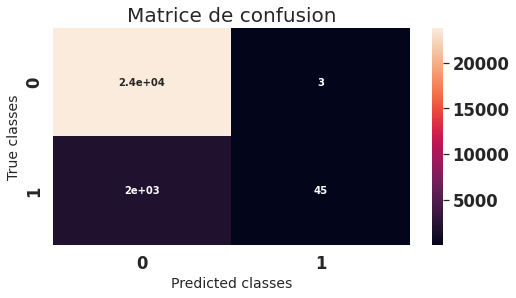

In [237]:
# Afficher la matrice de confusion et Classification report / TRAIN Data
pred_train_df = pd.DataFrame(index=X_train.index)
pred_train_df['predicted_class'] = clf.predict(X_train)
pred_train_df['TARGET'] = y_train
print(pred_train_df.shape)

plot_confusion_matrix(pred_train_df['TARGET'], pred_train_df['predicted_class'])

(11097, 2)
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     10193
         1.0       0.53      0.01      0.02       904

    accuracy                           0.92     11097
   macro avg       0.72      0.51      0.49     11097
weighted avg       0.89      0.92      0.88     11097



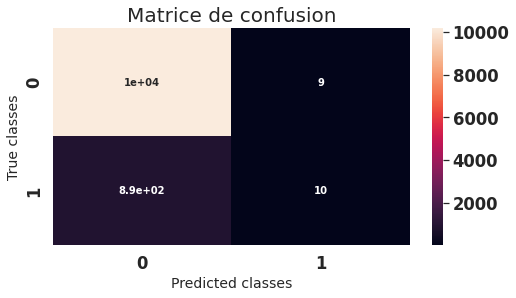

In [238]:
# Afficher la matrice de confusion et Classification report / TEST Data
pred_test_df = pd.DataFrame(index=X_test.index)
pred_test_df['predicted_class'] = clf.predict(X_test)
pred_test_df['TARGET'] = y_test
print(pred_test_df.shape)

plot_confusion_matrix(pred_test_df['TARGET'], pred_test_df['predicted_class'])

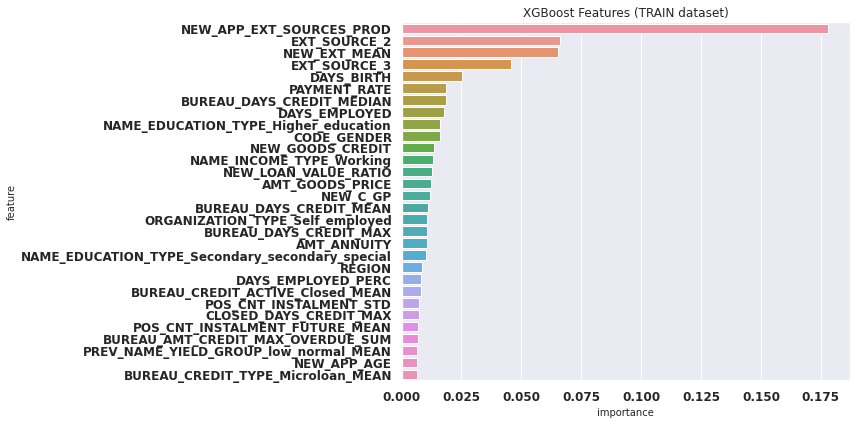

In [240]:
# Afficher le barchart des feature importances 
display_feat_imp(clf)

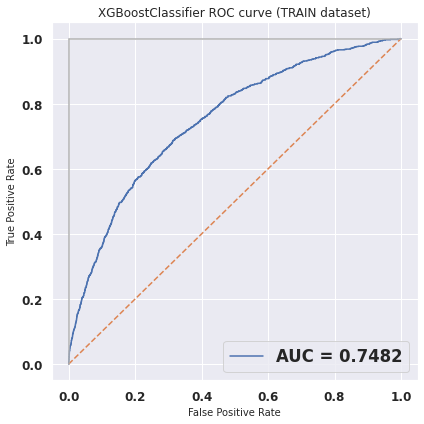

In [241]:
# Afficher le ROC AUC curve 
display_roc_auc(clf)

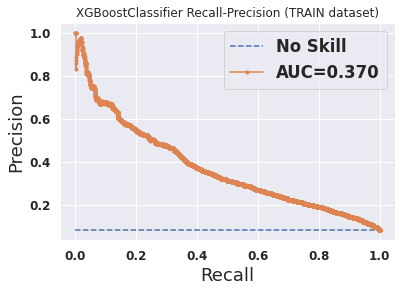

In [242]:
# Afficher 'Precision-Recall' graph - TRAIN data 
display_recall_prec_train(clf)

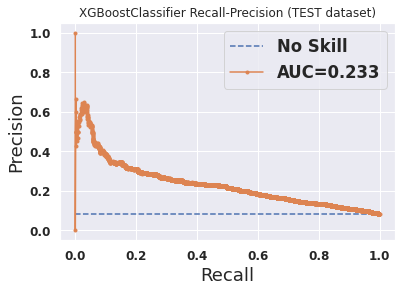

In [243]:
# Afficher 'Precision-Recall' graph - TEST data 
display_recall_prec_test(clf)

In [244]:
# Sauvegarder les data & modele entrainé traitement suivant
with open('drive/MyDrive/P7-Project/X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('drive/MyDrive/P7-Project/X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('drive/MyDrive/P7-Project/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('drive/MyDrive/P7-Project/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

with open('drive/MyDrive/P7-Project/XGB_clf_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

##III. Partie-3: Equilibrage (data balancing) 
Oversampling - Undersampling and SMOTE technqiues

On va proceder a une strategie d'equilibrage basee sur un sur-echantillonage (ovesampling) synthetique de la classe minoritaire avec SMOTE, suivi de sous-echantillonage de la class majoritaire.  
Les taux utilises seront testes, avec au demarrage:
- Taux d'Oversampling: 0.2
- Taux de Undersampling: 0.5

### Accuracy avant application de l'equilibrage

In [245]:
# Restorer les data & modele entrainés, tuné et fitté avec X_train
 # Lire fichier clean & selectionner observations pour entrainement
with open('drive/MyDrive/P7-Project/XGB_clf_model.pkl', 'rb') as f:
    clf = pickle.load(f)

with open('drive/MyDrive/P7-Project/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('drive/MyDrive/P7-Project/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('drive/MyDrive/P7-Project/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('drive/MyDrive/P7-Project/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [246]:
# Sommaire de la situation .... avant balancing
print(y_test.value_counts())
y_score = clf.predict(X_test)
print('\nAccuracy score: % .4f' %accuracy_score(y_test, y_score))

# pd.crosstab(y_test, y_score, margins=True)
df_cross_tab = pd.DataFrame(pd.crosstab(y_test, y_score, margins=True))
df_cross_tab['accuracy'] = ''
df_cross_tab.iloc[0,3] = df_cross_tab.iloc[0,0]/df_cross_tab.iloc[0,2]
df_cross_tab.iloc[1,3] = df_cross_tab.iloc[1,1]/df_cross_tab.iloc[1,2]

df_cross_tab

0.0    10193
1.0      904
Name: TARGET, dtype: int64

Accuracy score:  0.9186


col_0     0.0  1.0    All   accuracy
TARGET                              
0.0     10184    9  10193   0.999117
1.0       894   10    904  0.0110619
All     11078   19  11097

In [247]:
X_train.shape

(25892, 377)

### Application de la strategie d'équilibrage

In [253]:
# Test de meilleure rate de balancing des donnees
over_rates = [0.1, 0.2, 0.3]
under_rates = [0.4, 0.5, 0.6]
summary_res_over_rate = []
summary_res_under_rate = []
summary_res_acc_0 = []
summary_res_acc_1 = []

for i in over_rates:
    for j in under_rates:
        print('status for over_rate= {} and under_rate= {}'.format(i, j))     
        acc_0, acc_1, clf = smote_balancing(i, j)
        summary_res_over_rate.append(i)
        summary_res_under_rate.append(j)
        summary_res_acc_0.append(acc_0)
        summary_res_acc_1.append(acc_1)

summary = []
df_summary = pd.DataFrame(summary)
# inclure les donnees du status avant balancing
summary_res_over_rate.append(0)
summary_res_under_rate.append(0)
summary_res_acc_0.append(df_cross_tab.iloc[0,3])
summary_res_acc_1.append(df_cross_tab.iloc[1,3])

df_summary['over_rate'] = summary_res_over_rate
df_summary['under_rate'] = summary_res_under_rate
df_summary['accuracy_0'] = summary_res_acc_0
df_summary['accuracy_1'] = summary_res_acc_1
df_summary

status for over_rate= 0.1 and under_rate= 0.4
Counter({0.0: 23819, 1.0: 2073}) Counter({0.0: 5952, 1.0: 2381})
0.0    5952
1.0    2381
Name: TARGET, dtype: int64

Accuracy score:  0.8779
status for over_rate= 0.1 and under_rate= 0.5
Counter({0.0: 23819, 1.0: 2073}) Counter({0.0: 4762, 1.0: 2381})
0.0    4762
1.0    2381
Name: TARGET, dtype: int64

Accuracy score:  0.8524
status for over_rate= 0.1 and under_rate= 0.6
Counter({0.0: 23819, 1.0: 2073}) Counter({0.0: 3968, 1.0: 2381})
0.0    3968
1.0    2381
Name: TARGET, dtype: int64

Accuracy score:  0.8186
status for over_rate= 0.2 and under_rate= 0.4
Counter({0.0: 23819, 1.0: 2073}) Counter({0.0: 11907, 1.0: 4763})
0.0    11907
1.0     4763
Name: TARGET, dtype: int64

Accuracy score:  0.9018
status for over_rate= 0.2 and under_rate= 0.5
Counter({0.0: 23819, 1.0: 2073}) Counter({0.0: 9526, 1.0: 4763})
0.0    9526
1.0    4763
Name: TARGET, dtype: int64

Accuracy score:  0.8858
status for over_rate= 0.2 and under_rate= 0.6
Counter({0.0: 23

over_rate  under_rate  accuracy_0  accuracy_1
0        0.1         0.4    0.931227    0.276549
1        0.1         0.5    0.896890    0.350664
2        0.1         0.6    0.848916    0.476770
3        0.2         0.4    0.969979    0.132743
4        0.2         0.5    0.945649    0.211283
5        0.2         0.6    0.914844    0.294248
6        0.3         0.4    0.986265    0.063053
7        0.3         0.5    0.972923    0.121681
8        0.3         0.6    0.959580    0.164823
9        0.0         0.0    0.999117    0.011062

### Entrainer modele final avec donnees equilibrees:  
Meilleure score realise avec over_rate = 0.1 et under_rate = 0.6.  
On va donc appliquer ces rate sur nos donnees et re-evaluer notre modele.


In [254]:
# Equilibrage final des donnees
acc_0, acc_1, clf = smote_balancing(0.1, 0.6)
print(acc_0, acc_1)

Counter({0.0: 23819, 1.0: 2073}) Counter({0.0: 3968, 1.0: 2381})
0.0    3968
1.0    2381
Name: TARGET, dtype: int64

Accuracy score:  0.8218
0.8548023153144315 0.4491150442477876


In [255]:
# Basé sur l'équilibrage des données, on va re-mesurer les 
# performances du Modele XGBoost ainsi equilibre
start_time = time.time()

models = [
    ('XGB', GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,
        max_depth=7, min_samples_split=3100, min_samples_leaf=60, subsample=0.85,
            max_features=19, random_state=123, warm_start=True))
        ]
dfs , clf = eval_models(models)

final = pd.concat(dfs, ignore_index=True)
end_time = time.time()
print('\nTotal evaluation_time: {}'.format(end_time - start_time))

XGB evaluation_time: 28.651800632476807

Total evaluation_time: 28.652589559555054


In [256]:
X_train

NAME_CONTRACT_TYPE  ...  CLOSED_MONTHS_BALANCE_CLOSED_DIF_SUM
69611                    0  ...                             -0.205865
93195                    0  ...                             -0.205865
72918                    0  ...                             -0.205865
119499                   0  ...                             -0.205865
228698                   0  ...                             -0.205865
...                    ...  ...                                   ...
189477                   0  ...                             -0.205865
155416                   0  ...                             -0.205865
80862                    0  ...                             -0.205865
1064                     1  ...                             -0.205865
229888                   0  ...                             -0.205865

[25892 rows x 377 columns]

In [257]:
# Afficher les metriques de notre modele final
df_metrics = pd.DataFrame(final)
pd.DataFrame(df_metrics.mean(axis=0)).transpose()

fit_time  score_time  ...  test_roc_auc  test_fbeta
0  4.405674    0.088344  ...      0.745099    0.862237

[1 rows x 8 columns]

(25892, 2)
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     23819
         1.0       0.94      0.02      0.04      2073

    accuracy                           0.92     25892
   macro avg       0.93      0.51      0.50     25892
weighted avg       0.92      0.92      0.89     25892

(11097, 2)
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     10193
         1.0       0.53      0.01      0.02       904

    accuracy                           0.92     11097
   macro avg       0.72      0.51      0.49     11097
weighted avg       0.89      0.92      0.88     11097



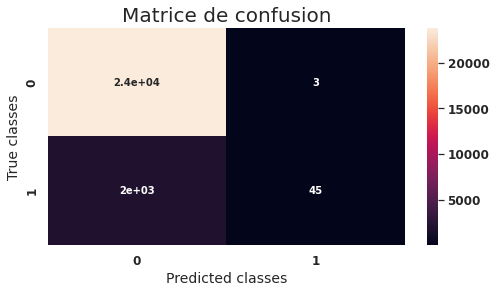

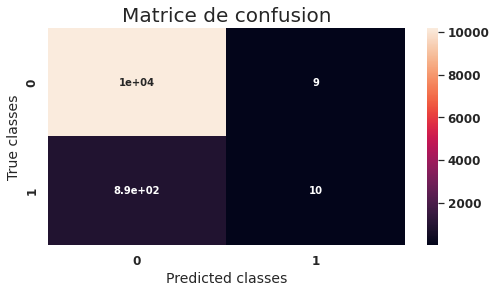

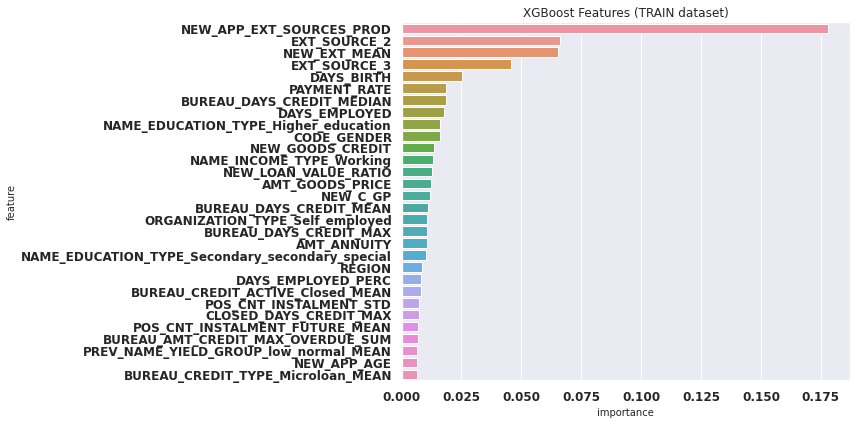

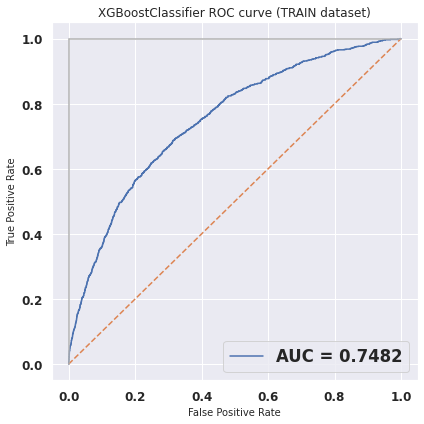

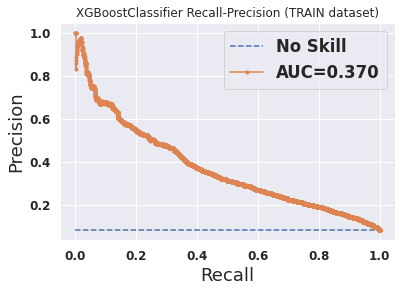

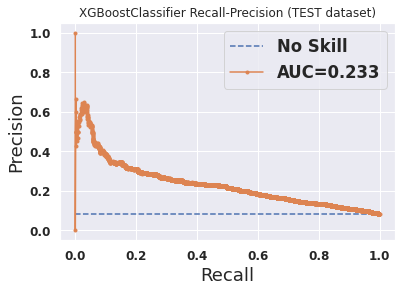

In [258]:
# ####################################################################
# Afficher la matrice de confusion et Classification report / TRAIN Data
pred_train_df = pd.DataFrame(index=X_train.index)
pred_train_df['predicted_class'] = clf.predict(X_train)
pred_train_df['TARGET'] = y_train
print(pred_train_df.shape)

plot_confusion_matrix(pred_train_df['TARGET'], pred_train_df['predicted_class'])
# ####################################################################

# Afficher la matrice de confusion et Classification report / TEST Data
pred_test_df = pd.DataFrame(index=X_test.index)
pred_test_df['predicted_class'] = clf.predict(X_test)
pred_test_df['TARGET'] = y_test
print(pred_test_df.shape)

plot_confusion_matrix(pred_test_df['TARGET'], pred_test_df['predicted_class'])
# ####################################################################

# Afficher le barchart des feature importances 
display_feat_imp(clf)
# Afficher le ROC AUC curve 
display_roc_auc(clf)
# Afficher 'Precision-Recall' graph - TRAIN data 
display_recall_prec_train(clf)
# Afficher 'Precision-Recall' graph - TEST data 
display_recall_prec_test(clf)

In [259]:
# Sauvegrader les fichiers train & test, ainsi le modele apres equilibrage
# ############################################################################
with open('drive/MyDrive/P7-Project/XGB_clf_model_f.pkl', 'wb') as f:
    pickle.dump(clf, f)
# ############################################################################
# Sauvegarder les data & modele entrainé traitement suivant
X_train.to_csv('drive/MyDrive/P7-Project/X_train_f.csv', index=False)
X_test.to_csv('drive/MyDrive/P7-Project/X_test_f.csv', index=False)
y_train.to_csv('drive/MyDrive/P7-Project/y_train_f.csv', index=False)
y_test.to_csv('drive/MyDrive/P7-Project/y_test_f.csv', index=False)
# ###########################################################################
df_application = pd.read_feather(
    'drive/MyDrive/P7-Project/applicationfeather')
df_application.to_csv('drive/MyDrive/P7-Project/applications.csv', index=False)
# ##########################################################################

### Preparer les fichiers CSV pour le 'Dashboard': 
On va creer un fichier, 'parallel' au fichier X_train, qui contient les informations des clients dans 'applications' avant standardization. Ceci facilitera l'accees a ces informations apres ptedictions pour le 'Dashaboard' mise en forme.

In [260]:
# Lire les fichiers sauvegardes
X_tra = pd.read_csv('drive/MyDrive/P7-Project/X_train_f.csv')
# X_tes = pd.read_csv('drive/MyDrive/P7-Project/X_test_f.csv')
y_tra = pd.read_csv('drive/MyDrive/P7-Project/y_train_f.csv')
# y_tes = pd.read_csv('drive/MyDrive/P7-Project/y_test_f.csv')
df_appli = pd.read_csv('drive/MyDrive/P7-Project/applications.csv')

In [261]:
X_tra.index = X_train_copy.index
# X_tra.drop(['Unnamed: 0'], axis=1, inplace=True)
X_tra.insert(0, 'SK_ID_CURR', X_train_copy['SK_ID_CURR'])
X_tra.insert(len(X_tra.columns), 'TARGET', X_train_copy['TARGET'])

In [262]:
y_tra.index = y_train_copy.index
# y_tra.drop(['Unnamed: 0'], axis=1, inplace=True)
y_tra.insert(0, 'SK_ID_CURR', X_train_copy['SK_ID_CURR'])

In [263]:
# Reverser les get_dummies si necessaires sur colonnes choisie / dans df_appli
# Reserver get_dummies pour colonne qui commence par 'NAME_FAMILY_STATUS'
filter_col = [col for col in df_application if col.startswith(
    'NAME_FAMILY_STATUS')]
# Restaurer ces colonnes dans un df temporaire
df_var_encodees = df_appli[filter_col]
df_appli.drop(df_var_encodees.columns, axis=1, inplace=True)
df_var_encodees.columns = df_var_encodees.columns.str.replace(
    'NAME_FAMILY_STATUS_', 'NAME_FAMILY_STATUS*')
# Appller la fonction de reconstruction de la variable origine
df_var_origine = undummify(df_var_encodees, prefix_sep='*')
# integrer variable origine dans df_appli
df_appli['NAME_FAMILY_STATUS'] = df_var_origine


In [264]:
# Construire un fichier 'applications' contenant uniquement les clients 
# figurants dans le X_train
df = y_tra.merge(df_appli, on=['SK_ID_CURR'], how='left')
# to_drop_cols = ['Unnamed: 0', 'TARGET_y']
to_drop_cols = ['TARGET_y']
df.drop(to_drop_cols, axis=1, inplace=True)
df.rename(columns={'TARGET_x': 'TARGET'}, inplace = True)

In [265]:
df

SK_ID_CURR  ...    NAME_FAMILY_STATUS
0          180740  ...             Separated
1          208223  ...               Married
2          184558  ...               Married
3          238579  ...               Married
4          364901  ...               Married
...           ...  ...                   ...
25887      319695  ...  Single / not married
25888      280163  ...               Married
25889      193755  ...               Married
25890      101235  ...               Married
25891      366273  ...  Single / not married

[25892 rows x 91 columns]

In [266]:
X_tra

SK_ID_CURR  ...  TARGET
69611       180740  ...     0.0
93195       208223  ...     0.0
72918       184558  ...     0.0
119499      238579  ...     0.0
228698      364901  ...     0.0
...            ...  ...     ...
189477      319695  ...     0.0
155416      280163  ...     0.0
80862       193755  ...     1.0
1064        101235  ...     0.0
229888      366273  ...     0.0

[25892 rows x 379 columns]

In [267]:
# Aligner les 2 fichiers 'X_tra' et 'df'
# X_tra, df = X_tra.align(df, join='left', axis=1)

In [268]:
X_tra.to_csv('drive/MyDrive/P7-Project/X_train_sample.csv')
df.to_csv('drive/MyDrive/P7-Project/application_sample.csv')

Nous avons maintenant les fichiers sauvegrades sur disque:
- Le modele: XGB_clf_model_f.pkl 
- Le X_train: X_train_sample.csv
- Le 'applications: application_sample.csv  

Ainsi que les fichiers pour analyse de l'interpretation:
- X_train_f.csv
- X_test_f.csv
- y_train_f.csv
- y_test_f.csv

##IV. Partie-4: Interpretation des predictions 

### Entrainer et collecter les valeures de sharp

In [269]:
# Charger le modele XGB déjà entrainé  
clf = joblib.load('drive/MyDrive/P7-Project/XGB_clf_model_f.pkl')

In [270]:
# Lire les fichiers sauvegardes
X_train = pd.read_csv('drive/MyDrive/P7-Project/X_train_f.csv')
X_test = pd.read_csv('drive/MyDrive/P7-Project/X_test_f.csv')
y_train = pd.read_csv('drive/MyDrive/P7-Project/y_train_f.csv')
y_test = pd.read_csv('drive/MyDrive/P7-Project/y_test_f.csv')

In [275]:
y_test

TARGET
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
...       ...
11092     0.0
11093     0.0
11094     0.0
11095     0.0
11096     0.0

[11097 rows x 1 columns]

In [276]:
# X_train.drop(['Unnamed: 0'], axis=1, inplace=True)
# X_test.drop(['Unnamed: 0'], axis=1, inplace=True)
# y_train.drop(['Unnamed: 0'], axis=1, inplace=True)
# y_test.drop(['Unnamed: 0'], axis=1, inplace=True)

In [277]:
# Rappel: Accuracy score du mode
clf.score(X_test, y_test)

0.9186266558529332

In [294]:
# Definir et collecter les valeures de shap - TEST dataset
start_time = time.time()

explainer = shap.Explainer(clf, X_test)
shap_values = explainer(X_test, check_additivity=False)

end_time = time.time()
explanation_time = end_time - start_time

100%|===================| 11089/11097 [00:30<00:00]       

In [295]:
# Sauvegarder les valeures de shap entrainé pour traitement ulterieure
with open('drive/MyDrive/P7-Project/shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

In [296]:
# Charger les valeures SHARP déjà calculées  
shap_values = joblib.load('drive/MyDrive/P7-Project/shap_values.pkl')

### Interpretation locale

In [297]:
# Choisir un client idx = 150 par exemple
clf.predict([X_test.iloc[150]])
clf.predict_proba([X_test.iloc[150]])
#y_test.iloc[150]

array([[0.93850543, 0.06149457]])

[[0.93850543 0.06149457]]


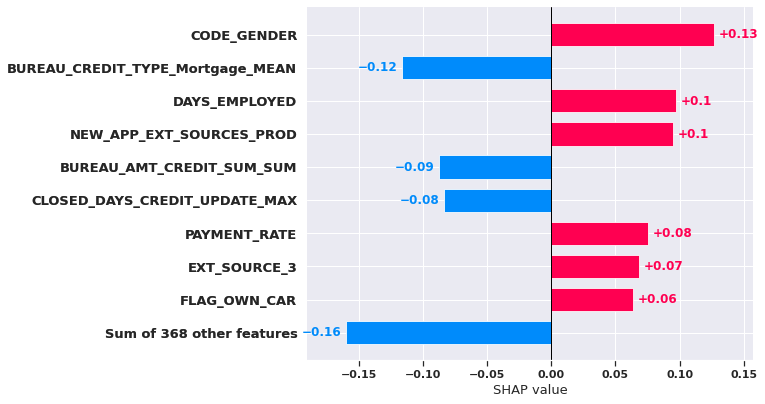

In [307]:
client_150 = pd.DataFrame(X_test.iloc[[150]])
print(clf.predict_proba(client_150))
shap.plots.bar(shap_values[150])

Ce bar plot d'analyse locale de shap, facilite l'analyse de tres pres de l'impact d'une seule observation (la 150eme du dataset) par example.  


[[0.93689503 0.06310497]]


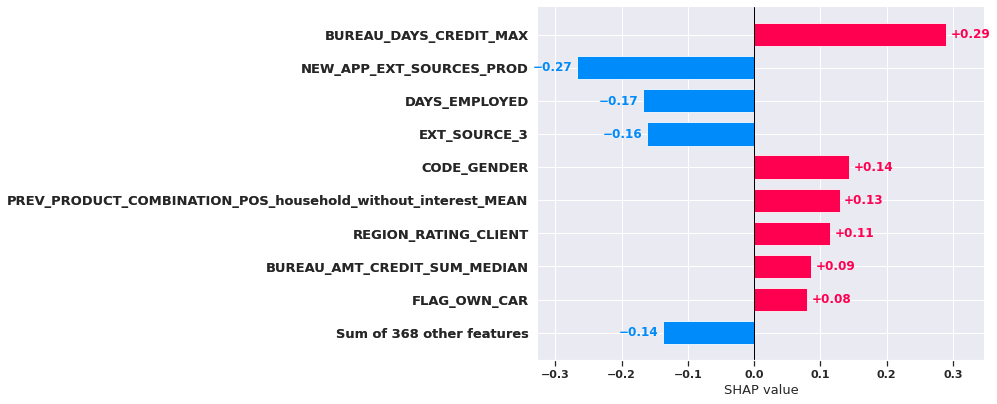

In [308]:
client_50 = pd.DataFrame(X_test.iloc[[50]])
print(clf.predict_proba(client_50))
shap.plots.bar(shap_values[50])

Alors que pour l'observation (50), on voit un ensemble d'impact qui peut etre tout a fait different, suivant les valeurs de chaque variable.

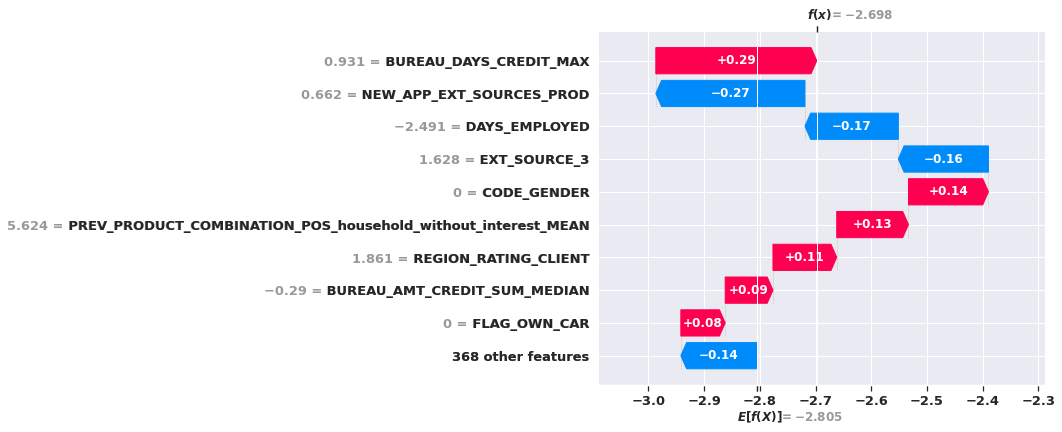

In [309]:
shap.plots.waterfall(shap_values[50])

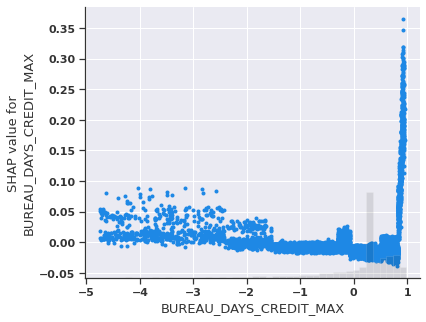

In [310]:
shap.plots.scatter(shap_values[:,'BUREAU_DAYS_CREDIT_MAX'])

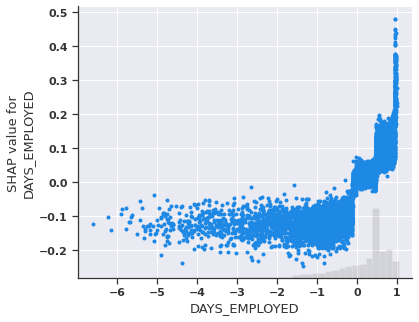

In [311]:
# Analyser le scatter valeures de shap pour la variable indiquee
shap.plots.scatter(shap_values[:,'DAYS_EMPLOYED'])

Ce 'dependence scatter plot' montre l'effet qu'une variable specifique peut avoir sur l'impact du modele.  
Ici, on voit l'impact de la variable 'DAYS_EMPLOYED' (jours travailes). Le no,bre de jours travaille etant negatif dans le fichier, il est logique que ca pousse la prediction vers un rejet (TARGET=1) quand proche de zero, et vers un acceptance (TARGET=0) quand negatif.

La zone grise en bas a droite affiche la distribution de la variable sur l'ensemble des observations. 

### Interpretation generale

In [312]:
# Charger les valeures de shap déjà entrainé  
shap_values = joblib.load('drive/MyDrive/P7-Project/shap_values.pkl')

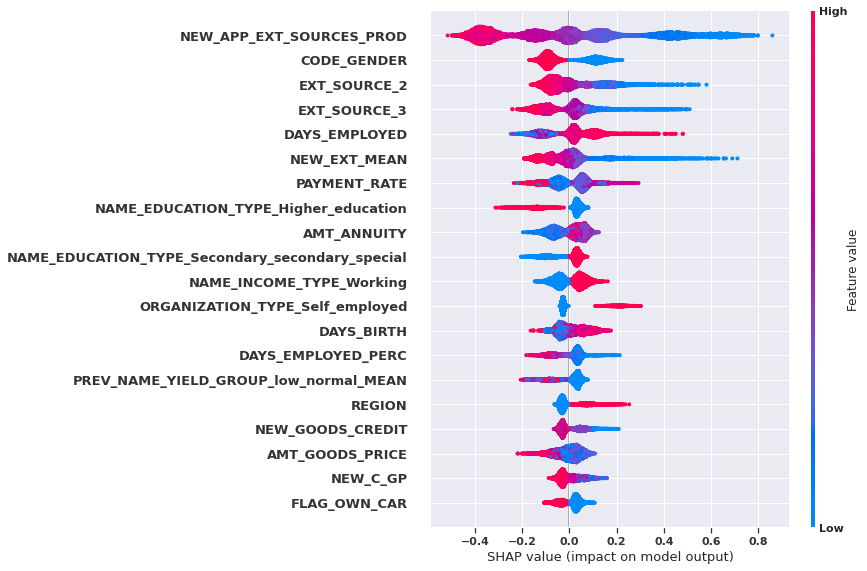

In [313]:
# Analyser la courbe sommaire - valeures shap
shap.summary_plot(shap_values, X_test)

Dans ce graphique sommaire, il faut noter dekja que l'ordre des variables presentees indique leur importance croissante sur la prediction du modele.  
Ainsi, les variables "NEW_APP_EXT_SOURCES_PROD', 'NEW_EXT_MEAN', 'EXT_SOURCE_2', et 'EXT_SOURCE_3' s'averent les plus importantes. Il faut noter que ces variables sont liees entre elles sachant que la description de 'EXT_SOURCE_2' et 'EXT_SOURCE_3' n'est pas du tout claire dans la documentation. Les 2 prenieres soint des variables construites a partir des 2 dernieres. Ces  4 variables se comportent de la meme facon: leur grande valeur influence la sortie du modele positivement, et vice vers.  
Prenon la variable 'CODE_GENDRE' qui se montre favorable avec des valeures petite (donc pres de 0, soit F), et moins favorable pour les grandes valeures (1, soit M), sachant que les points observes sont plus M que F.      
Chaque point du graphe represente une prediction du modele. L'axe x-axis represente la valeure SHAP de l'impact sur la prediction, et la barre de couleur represente la valeur prise par une variable (rouge: grande, bleu: petite).  

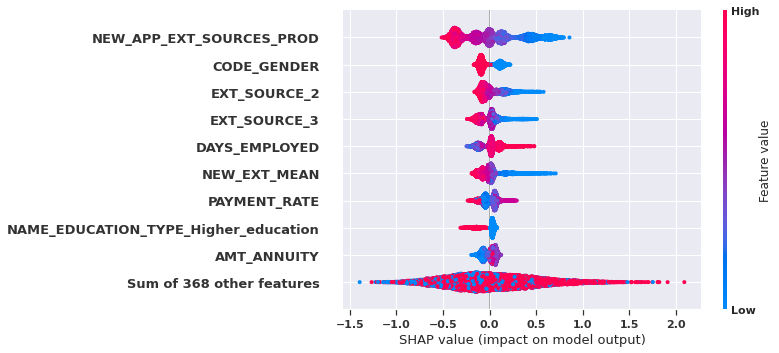

In [314]:
# Analyser la courbe beeswarm - valueres shap
shap.plots.beeswarm(shap_values)

Ce graphe est identique au precedent, sauf qu'il indique l'ensemble des variabels, et affiche l'influence des variables restantes pour comparer avec les variables les polus importantes. Ainsi, l'impact des 368 variables restantes s'eleve quand meme a plsu de 1.5 pour un 0.6  

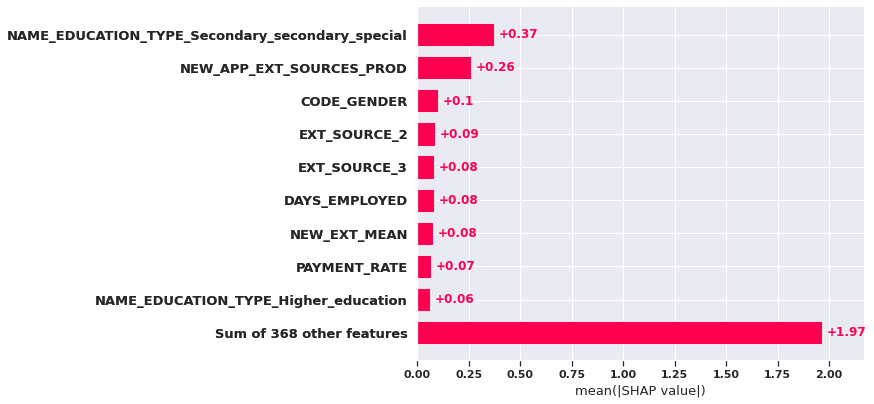

In [315]:
# Analyser la courbe en barchart - valeures shap
shap.plots.bar(shap_values.abs.mean(0))

Le bar plot de sahp represente la moyenne des valeures shap pour les variables et les classe par ordre. Aisni, la moyenne de l'impact de la variable 'CODE_GENDRE' est de +0.08.